<h1 style="text-align:center;">Thesis Algorithms and Experimental Analysis</h1>
<h3 style="text-align:center;">Jerry Mathew Oommen</h3>

<h2 style="text-align:center;">Section 1: General case (Random points)</h2>
<h3 style="text-align:center;">Objective: Maximize deliveries</h3>

### Functions to calculate the earliest and latest launch time and return time

In [7]:
import math

def calculate_es_ls(R, v, d):
    if v <= 1:
        return None

    x, y = d
    M = R / 2
    m = (R/(2*v)) * math.sqrt(v**2 - 1)
    
    if abs(y) > m:
        return None
        
    x_prime = M * math.sqrt(1 - (y**2 / m**2))
    es = x - (R/(2*v)) - x_prime
    ls = x - (R/(2*v)) + x_prime
    return round(es, 4), round(ls, 4)

def ret(s=0, v=0, d=(0, 0), clear_cache=False):
    if not hasattr(ret, "_ret_cache") or clear_cache:
        ret._ret_cache = {}

    if clear_cache:
        return

    key = (round(s, 4), d)
    if key not in ret._ret_cache:
        x, y = d
        a = math.sqrt(y**2 + (s - x)**2)
        b = s * v**2 + a * v - x
        discriminant = b**2 - s * (v**2 - 1) * (b + s + a * v - x)
        if discriminant < 0:
            ret._ret_cache[key] = math.inf
        else:
            ret._ret_cache[key] = round(s + (s + a * v - x + math.sqrt(discriminant)) / (v**2 - 1), 4)

    return ret._ret_cache[key]



### Greedy Algorithm for 1 drone

In [23]:
from collections import namedtuple

Delivery = namedtuple("Delivery", ["es", "ls", "d"])

def Greedy_Algorithm(deliveries, R, v):
    SI = []  
    L = [] 
    s = 0
    ret(clear_cache = True)
    for d in deliveries:
        result = calculate_es_ls(R, v, d)
        if result == None:
            return []
        es, ls = result
        if s <= ls:
            L.append(Delivery(es, ls, d))
    
    L.sort(key=lambda x: x.es)
    
    while L:
        x = L[0] 

        if s < x.es:
            s = x.es
        
        rmin = float("inf")
        save = None
        
        for x in (x for x in L if s >= x.es):
            r = ret(s, v, x.d)
            if r == math.inf:
                return []
            if r < rmin:
                rmin = r
                save = x
        
        if save:
            SI.append((save.d, s))
            s = rmin
            L = [x for x in L if (x.ls >= s and x.d != save.d)]
    
    return SI

### Example case for 1 drone

Delivery points with their earliest and latest start times:

1. 	 (0.09, 0.18)  	 es: -0.29  	 ls: 0.09
2. 	 (0.32, 0.18)  	 es: -0.06  	 ls: 0.33
3. 	 (0.49, 0.15)  	 es: 0.07  	 ls: 0.53
4. 	 (0.60, 0.08)  	 es: 0.13  	 ls: 0.70
5. 	 (0.61, 0.08)  	 es: 0.14  	 ls: 0.70
6. 	 (0.66, 0.02)  	 es: 0.17  	 ls: 0.77
7. 	 (0.72, 0.14)  	 es: 0.29  	 ls: 0.77
8. 	 (1.33, 0.20)  	 es: 0.99  	 ls: 1.29
9. 	 (1.37, 0.12)  	 es: 0.93  	 ls: 1.44
10. 	 (1.63, 0.07)  	 es: 1.16  	 ls: 1.73

Scheduled Deliveries:

1. 	 (0.09, 0.18) 	 Start time: 0.00 	 Return time: 0.30
2. 	 (0.60, 0.08) 	 Start time: 0.30 	 Return time: 0.55
3. 	 (0.66, 0.02) 	 Start time: 0.55 	 Return time: 0.64
4. 	 (0.61, 0.08) 	 Start time: 0.64 	 Return time: 0.85
5. 	 (1.37, 0.12) 	 Start time: 0.93 	 Return time: 1.31
6. 	 (1.63, 0.07) 	 Start time: 1.31 	 Return time: 1.57


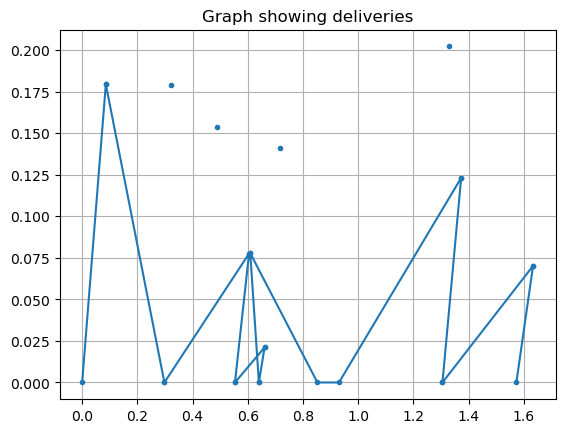

In [3]:
import matplotlib.pyplot as plt
import random

R = 0.6  
v = 1.6  
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
num_points = 10
L = []
x_max = 2

deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
deliveries.sort(key = lambda x:x[0])

print("Delivery points with their earliest and latest start times:\n") 
for i, delivery in enumerate(deliveries, start = 1):
    result = calculate_es_ls(R, v, delivery)
    if result != None:
        es, ls = result
        print(f"{i}. \t ({delivery[0]:.2f}, {delivery[1]:.2f})  \t es: {es:.2f}  \t ls: {ls:.2f}")

schedule = Greedy_Algorithm(deliveries, R, v)
print("\nScheduled Deliveries:\n")

for i, delivery in enumerate(schedule, start = 1):
    d, s = delivery
    r = ret(s, v, d)
    print(f"{i}. \t ({d[0]:.2f}, {d[1]:.2f}) \t Start time: {s:.2f} \t Return time: {r:.2f}")
    L.extend([(s,0), (d), (r, 0)])

x, y = zip(*L)
plt.plot(x, y, marker='.') 
p, q = zip(*deliveries)
plt.scatter(p, q, marker='.') 
plt.title('Graph showing deliveries')
plt.grid(True)
plt.show()

### Sequential Greedy Algorithm for k drones 

In [26]:
def Sequential_Greedy(deliveries, R, v, num_drones, x_max):    
    s = 0
    L = []
    L_not = []
    SI_list = []
    ret(clear_cache = True)
    
    for d in deliveries:
        result = calculate_es_ls(R, v, d)
        if result != None:
            es, ls = result
            if s <= ls:
                L.append(Delivery(es, ls, d))
            else:
                L_not.append(Delivery(es, ls, d))

    L.sort(key=lambda x: x.es)

    for _ in range(num_drones):
        s = 0
        SI = []
        s_list = []
        L_next = []

        while L and s < x_max:
            x = L[0] 

            if s < x.es:
                s = x.es

            rmin = float("inf")
            save = None

            for x in (x for x in L if s >= x.es):
                r = ret(s, v, x.d)
                if r < rmin:
                    rmin = r
                    save = x

            if save:
                SI.append((save.d, s))
                s = rmin
                L_next.extend([x for x in L if x.ls < s and x.d != save.d])
                L = [x for x in L if x.ls >= s and  x.d != save.d]

        L = L_next.copy()
        L.sort(key=lambda x: x.es)
        SI_list.append(SI)

    return SI_list, L_not, L

### Example case for Sequential Greedy Algorithm for k drones

Delivery points with their earliest and latest start times:

1. 	 (0.01, 0.11)  	 es: -0.45  	 ls: 0.09
2. 	 (0.02, 0.14)  	 es: -0.40  	 ls: 0.08
3. 	 (0.05, 0.07)  	 es: -0.42  	 ls: 0.15
4. 	 (0.10, 0.14)  	 es: -0.33  	 ls: 0.16
5. 	 (0.12, 0.06)  	 es: -0.36  	 ls: 0.22
6. 	 (0.16, 0.11)  	 es: -0.29  	 ls: 0.24
7. 	 (0.17, 0.08)  	 es: -0.30  	 ls: 0.27
8. 	 (0.22, 0.01)  	 es: -0.27  	 ls: 0.33
9. 	 (0.27, 0.07)  	 es: -0.20  	 ls: 0.37
10. 	 (0.29, 0.17)  	 es: -0.10  	 ls: 0.31
11. 	 (0.31, 0.23)  	 es: 0.05  	 ls: 0.19
12. 	 (0.34, 0.23)  	 es: 0.07  	 ls: 0.23
13. 	 (0.34, 0.21)  	 es: 0.01  	 ls: 0.30
14. 	 (0.40, 0.02)  	 es: -0.09  	 ls: 0.51
15. 	 (0.42, 0.13)  	 es: -0.02  	 ls: 0.49
16. 	 (0.43, 0.02)  	 es: -0.05  	 ls: 0.54
17. 	 (0.44, 0.20)  	 es: 0.10  	 ls: 0.40
18. 	 (0.44, 0.01)  	 es: -0.04  	 ls: 0.56
19. 	 (0.52, 0.11)  	 es: 0.06  	 ls: 0.60
20. 	 (0.55, 0.16)  	 es: 0.14  	 ls: 0.58
21. 	 (0.56, 0.03)  	 es: 0.07  	 ls: 0.67
22. 	 (0.59, 0.06)  	 es: 0.11 

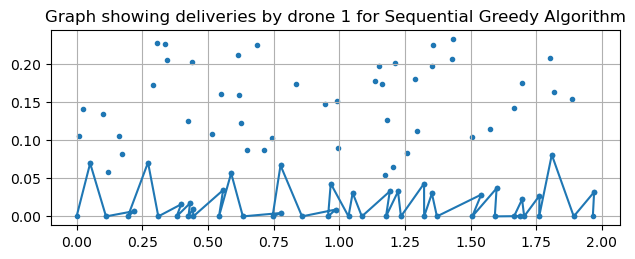

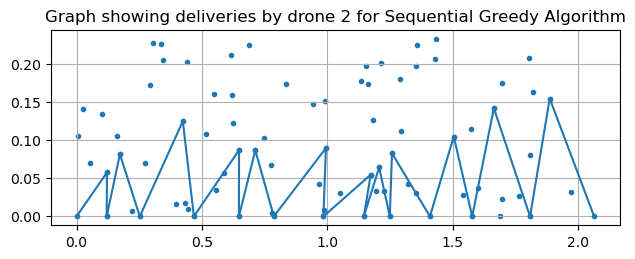

In [5]:
R = 0.6  
v = 1.6  
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
x_max = 2
num_points = 70
num_drones = 2
sm_lst = []
bg_lst = []

deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
deliveries.sort(key = lambda x:x[0])

print("Delivery points with their earliest and latest start times:\n") 
for i, delivery in enumerate(deliveries, start = 1):
    result = calculate_es_ls(R, v, delivery)
    if result != None:
        es, ls = result
        print(f"{i}. \t ({delivery[0]:.2f}, {delivery[1]:.2f})  \t es: {es:.2f}  \t ls: {ls:.2f}")

SI_list, L_not_cons, L_not_schd = Sequential_Greedy(deliveries, R, v, num_drones, x_max)

print("\nDeliveries Scheduled:")

for k in range(num_drones):
    if SI_list[k]:
        print(f"\nBy Drone {k + 1}:\n")
        sm_lst = []
        for i, delivery in enumerate(SI_list[k], start = 1):
            d, s = delivery
            r = ret(s, v, d)
            print(f"{i}. \t ({d[0]:.2f}, {d[1]:.2f}) \t Start time: {s:.2f} \t Return time: {r:.2f}")
            sm_lst.extend([(s,0), (d), (r, 0)])
        bg_lst.append(sm_lst)

if L_not_cons:
    print("\nDeliveries that are not considered i.e. latest start time less than 0:\n")
    for i, x in enumerate(L_not_cons, start = 1):
        print(f"{i}. \t ({x.d[0]:.2f}, {x.d[1]:.2f}) \t es: {x.es:.2f} \t ls: {x.ls:.2f}")
        
if L_not_schd:
    print("\nDeliveries that could not be scheduled:\n")
    for i, x in enumerate(L_not_schd, start = 1):
        print(f"{i}. \t ({x.d[0]:.2f}, {x.d[1]:.2f}) \t es: {x.es:.2f} \t ls: {x.ls:.2f}")

for k in range(len(bg_lst)):
    plt.subplot(num_drones, 1, k + 1)
    x, y = zip(*bg_lst[k])
    plt.plot(x, y, marker='.') 
    p, q = zip(*deliveries)
    plt.scatter(p, q, marker='.') 
    plt.title(f"Graph showing deliveries by drone {k + 1} for Sequential Greedy Algorithm")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Parallel Greedy Algorithm for k drones

In [27]:
def Parallel_Greedy(deliveries, R, v, num_drones, x_max):
    L = []
    L_not = []
    SI = []
    L_save = []
    L_lst = []
    s = [0 for _ in range(num_drones)]
    ret(clear_cache = True)
    
    for d in deliveries:
        result = calculate_es_ls(R, v, d)
        if result != None:
            es, ls = result
            if s[0] <= ls:
                L.append(Delivery(es, ls, d))
            else:
                L_not.append(Delivery(es, ls, d))
    
    L.sort(key = lambda x: x.es)
    
    SI = [[] for _ in range(num_drones)]
    L_lst = [L.copy() for _ in range(num_drones)]
         
    flag = True
    while flag == True:
        flag = False
        for k in range(len(L_lst)):
            if L_lst[k] and s[k] < x_max:
                flag = True
                x = L_lst[k][0] 

                if s[k] < x.es:
                    s[k] = x.es

                rmin = float("inf")
                save = None

                for y in (y for y in L_lst[k] if s[k] >= y.es):
                    r = ret(s[k], v, y.d)
                    if r < rmin:
                        rmin = r
                        save = y

                if save:
                    SI[k].append((save.d, s[k]))
                    L_save.append(save)
                    s[k] = rmin
                    L_lst[k] = [x for x in L_lst[k] if (x.ls >= s[k])]
                    for i in range(len(L_lst)):
                         L_lst[i] = [x for x in L_lst[i] if x.d != save.d]
    
    L_rem = list(set(L) - set(L_save))

    return SI, L_not, L_rem

### Example case for Parallel Greedy Algorithm for k drones

Delivery points with their earliest and latest start times:

1. 	 (0.01, 0.12)  	 es: -0.44  	 ls: 0.07
2. 	 (0.01, 0.13)  	 es: -0.43  	 ls: 0.07
3. 	 (0.01, 0.03)  	 es: -0.47  	 ls: 0.12
4. 	 (0.04, 0.14)  	 es: -0.39  	 ls: 0.09
5. 	 (0.05, 0.19)  	 es: -0.32  	 ls: 0.04
6. 	 (0.06, 0.01)  	 es: -0.43  	 ls: 0.17
7. 	 (0.07, 0.01)  	 es: -0.42  	 ls: 0.18
8. 	 (0.08, 0.13)  	 es: -0.35  	 ls: 0.14
9. 	 (0.13, 0.04)  	 es: -0.35  	 ls: 0.24
10. 	 (0.17, 0.05)  	 es: -0.31  	 ls: 0.28
11. 	 (0.20, 0.23)  	 es: -0.07  	 ls: 0.09
12. 	 (0.23, 0.23)  	 es: -0.02  	 ls: 0.11
13. 	 (0.23, 0.11)  	 es: -0.22  	 ls: 0.31
14. 	 (0.35, 0.01)  	 es: -0.14  	 ls: 0.46
15. 	 (0.36, 0.14)  	 es: -0.07  	 ls: 0.41
16. 	 (0.38, 0.11)  	 es: -0.07  	 ls: 0.46
17. 	 (0.41, 0.12)  	 es: -0.04  	 ls: 0.48
18. 	 (0.43, 0.18)  	 es: 0.05  	 ls: 0.43
19. 	 (0.44, 0.06)  	 es: -0.04  	 ls: 0.54
20. 	 (0.47, 0.18)  	 es: 0.09  	 ls: 0.47
21. 	 (0.49, 0.04)  	 es: 0.00  	 ls: 0.59
22. 	 (0.51, 0.08)  	 es: 0

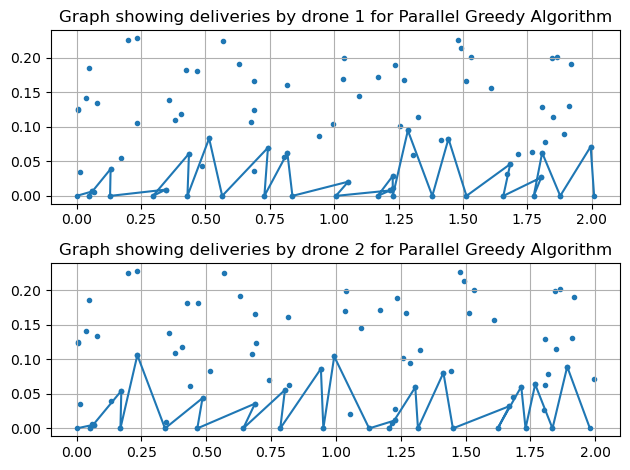

In [39]:
R = 0.6  
v = 1.6  
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
num_points = 70
x_max = 2
num_drones = 2
sm_lst = []
bg_lst = []

deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
deliveries.sort(key = lambda x:x[0])

print("Delivery points with their earliest and latest start times:\n") 
for i, delivery in enumerate(deliveries, start = 1):
    result = calculate_es_ls(R, v, delivery)
    if result != None:
        es, ls = result
        print(f"{i}. \t ({delivery[0]:.2f}, {delivery[1]:.2f})  \t es: {es:.2f}  \t ls: {ls:.2f}")

SI_list, L_not_cons, L_not_schd = Parallel_Greedy(deliveries, R, v, num_drones, x_max)

print("\nDeliveries Scheduled:")

for k in range(num_drones):
    if SI_list[k]:
        print(f"\nBy Drone {k + 1}:\n")
        sm_lst = []
        for i, delivery in enumerate(SI_list[k], start = 1):
            d, s = delivery
            r = ret(s, v, d)
            print(f"{i}. \t ({d[0]:.2f}, {d[1]:.2f}) \t Start time: {s:.2f} \t Return time: {r:.2f}")
            sm_lst.extend([(s,0), (d), (r, 0)])
        bg_lst.append(sm_lst)

if L_not_cons:
    print("\nDeliveries that are not considered i.e. latest start time less than 0:\n")
    for i, x in enumerate(L_not_cons, start = 1):
        print(f"{i}. \t ({x.d[0]:.2f}, {x.d[1]:.2f}) \t es: {x.es:.2f} \t ls: {x.ls:.2f}")

if L_not_schd:
    print("\nDeliveries that could not be scheduled:\n")
    for i, x in enumerate(L_not_schd, start = 1):
        print(f"{i}. \t ({x.d[0]:.2f}, {x.d[1]:.2f}) \t es: {x.es:.2f} \t ls: {x.ls:.2f}")

for k in range(len(bg_lst)):
    plt.subplot(num_drones, 1, k + 1)
    x, y = zip(*bg_lst[k])
    plt.plot(x, y, marker='.') 
    p, q = zip(*deliveries)
    plt.scatter(p, q, marker='.') 
    plt.title(f"Graph showing deliveries by drone {k + 1} for Parallel Greedy Algorithm")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Function for Calculating mean using IQR method

In [18]:
import numpy as np

def calculate_mean_IQR(data):
    precision = 8
    data = np.array(data)
    if data.size == 0:
        return 0  
    
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

    if filtered_data.size == 0:
        mean_filtered = np.median(data) 
    else:
        mean_filtered = np.mean(filtered_data)

    return round(mean_filtered, precision)  


### Comparison of Sequential and Parallel Greedy Algorithms

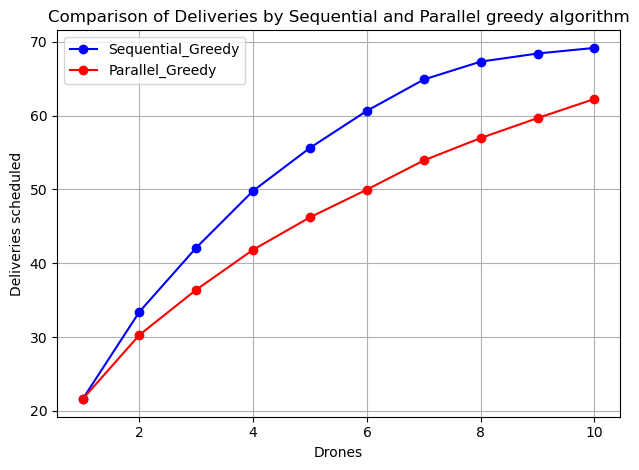

In [42]:
import math
import time
import random

R = 0.6  
v = 1.6
x_max = 2
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
num_points = 70
num_drones = 10
num_trials = 100

avg_runtime_alg_1 = []
avg_runtime_alg_2 = []
avg_count_alg_1 = []
avg_count_alg_2 = []

for k in range(1, num_drones + 1):
    lst_runtime_alg_1 = []
    lst_runtime_alg_2 = []
    
    lst_count_alg_1 = []
    lst_count_alg_2 = []
    
    for _ in range(num_trials):
        deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
        deliveries.sort(key = lambda x:x[0])

        start_time = time.time()
        SI_list_1, _, _ = Sequential_Greedy(deliveries, R, v, k, x_max)
        end_time = time.time() 
        total_time_alg_1 = end_time - start_time
        
        start_time = time.time()
        SI_list_2, _, _ = Parallel_Greedy(deliveries, R, v, k, x_max)
        end_time = time.time() 
        total_time_alg_2 = end_time - start_time
        
        count_alg_1 = sum(len(SI_list_1[j]) for j in range(k) if SI_list_1[j])
        count_alg_2 = sum(len(SI_list_2[j]) for j in range(k) if SI_list_2[j])
        
        lst_count_alg_1.append(count_alg_1)
        lst_count_alg_2.append(count_alg_2)
    
        lst_runtime_alg_1.append(total_time_alg_1)
        lst_runtime_alg_2.append(total_time_alg_2)
        
    avg_count_alg_1.append(sum(lst_count_alg_1)/len(lst_count_alg_1)) 
    avg_count_alg_2.append(sum(lst_count_alg_2)/len(lst_count_alg_2))
    
    avg_runtime_alg_1.append(calculate_mean_IQR(lst_runtime_alg_1))
    avg_runtime_alg_2.append(calculate_mean_IQR(lst_runtime_alg_2))
    
x = list(range(1, num_drones + 1))
plt.plot(x, avg_count_alg_1,'bo-', label='Sequential_Greedy')
plt.plot(x, avg_count_alg_2,'ro-', label='Parallel_Greedy')
plt.title("Comparison of Deliveries by Sequential and Parallel greedy algorithm")
plt.xlabel("Drones")
plt.ylabel("Deliveries scheduled")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Comparison of Running time of Sequential and Parallel Greedy Algorithms

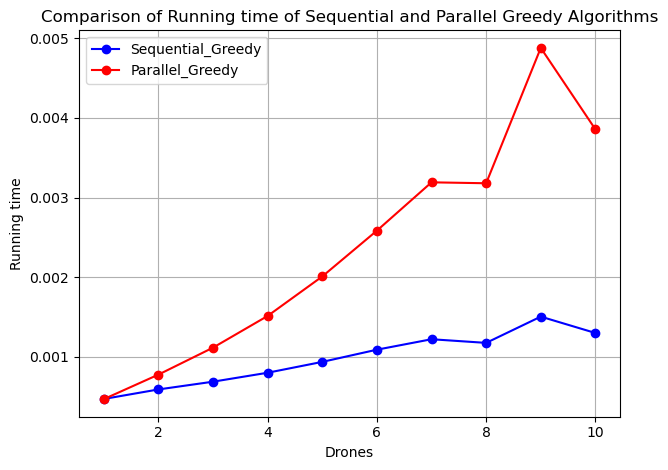

In [37]:
plt.plot(x, avg_runtime_alg_1,'bo-', label='Sequential_Greedy')
plt.plot(x, avg_runtime_alg_2,'ro-', label='Parallel_Greedy')
plt.title("Comparison of Running time of Sequential and Parallel Greedy Algorithms")
plt.xlabel("Drones")
plt.ylabel("Running time")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3-D Plot of ratio of deliveries scheduled with Sequential and Parallel Greedy Algorithms 

In [11]:
import math
import random

def calc_deliveries(num_points = 100, R = 0.6, v = 1.6, num_drones = 10): 
    x_max = 2
    m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
    num_trials = 100
    lst_avg_ratio = []
    
    for _ in range(num_trials):
        deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
        deliveries.sort(key = lambda x:x[0])

        SI_list_1, _, _ = Sequential_Greedy(deliveries, R, v, num_drones, x_max)
        SI_list_2, _, _ = Parallel_Greedy(deliveries, R, v, num_drones, x_max)

        count_alg_1 = sum(len(SI_list_1[j]) for j in range(num_drones) if SI_list_1[j])
        count_alg_2 = sum(len(SI_list_2[j]) for j in range(num_drones) if SI_list_2[j])
    
        lst_avg_ratio.append(count_alg_1/count_alg_2)
        
    return calculate_mean_IQR(lst_avg_ratio)


### 3-D Plot of ratio for varying number of points

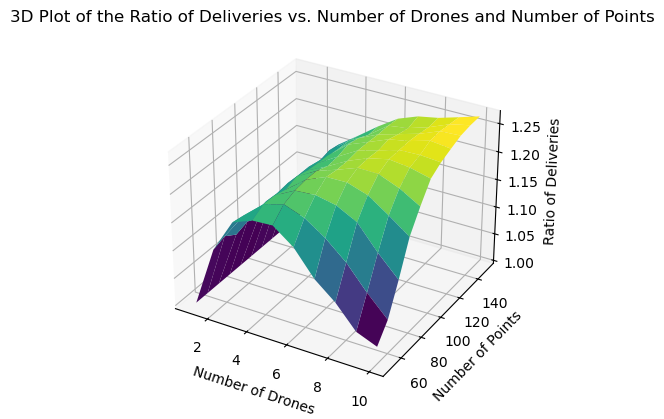

In [12]:
import matplotlib.pyplot as plt
import numpy as np

num_drones = list(range(1, 11))
num_points = list(range(50, 151, 10))
deliveries = []

x, y = np.meshgrid(num_drones, num_points)
z = np.array([[calc_deliveries(num_points = p, num_drones = d) for d in num_drones] for p in num_points])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap='viridis')

ax.set_title('3D Plot of the Ratio of Deliveries vs. Number of Drones and Number of Points')
ax.set_xlabel('Number of Drones')
ax.set_ylabel('Number of Points')
ax.set_zlabel('Ratio of Deliveries')
plt.show()


### 3-D Plot of ratio for varying range

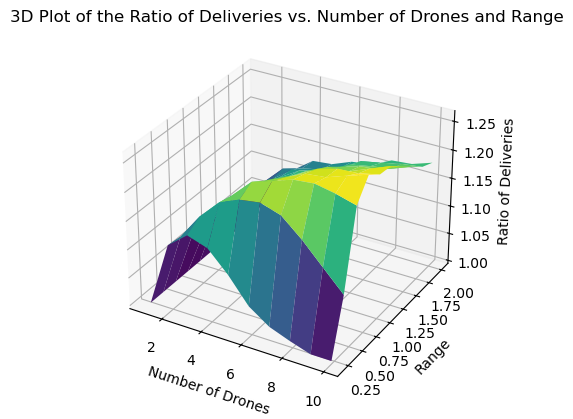

In [13]:
import matplotlib.pyplot as plt
import numpy as np

num_drones = list(range(1, 11))
R_list = [i / 10 for i in range(2, 21, 2)]
deliveries = []

x, y = np.meshgrid(num_drones, R_list)
z = np.array([[calc_deliveries(R = R_val, num_drones = d) for d in num_drones] for R_val in R_list])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap='viridis')

ax.set_title('3D Plot of the Ratio of Deliveries vs. Number of Drones and Range')
ax.set_xlabel('Number of Drones')
ax.set_ylabel('Range')
ax.set_zlabel('Ratio of Deliveries')
plt.show()


### 3-D Plot of ratio for varying velocity

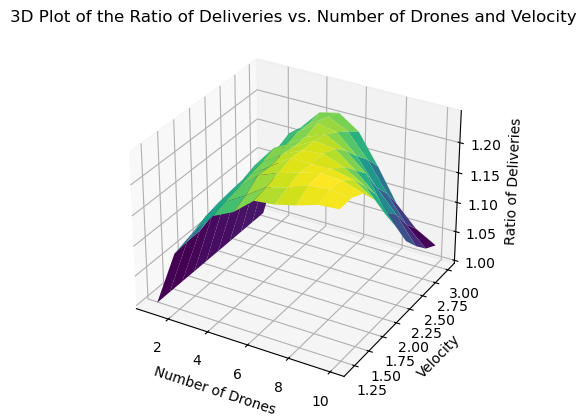

In [14]:
import matplotlib.pyplot as plt
import numpy as np

num_drones = list(range(1, 11))
v_list = [i / 10 for i in range(12, 31, 2)]
deliveries = []

x, y = np.meshgrid(num_drones, v_list)
z = np.array([[calc_deliveries(v = v_val, num_drones = d) for d in num_drones] for v_val in v_list])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap='viridis')

ax.set_title('3D Plot of the Ratio of Deliveries vs. Number of Drones and Velocity')
ax.set_xlabel('Number of Drones')
ax.set_ylabel('Velocity')
ax.set_zlabel('Ratio of Deliveries')
plt.show()


### Ratio of Greedy algorithm to Optimal algorithm

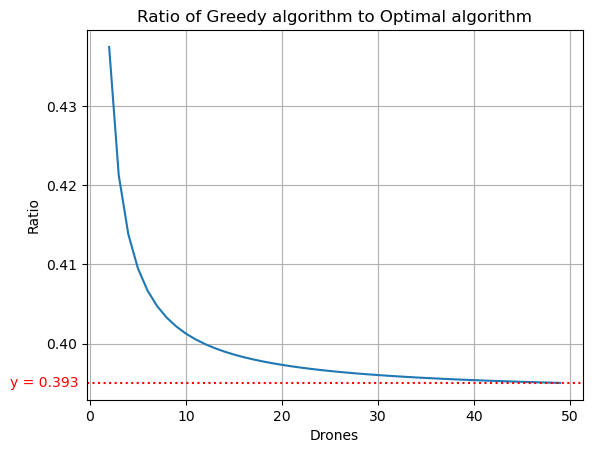

In [15]:
import numpy as np

lst = []
limit = 50

for k in range (2, limit):
    lst.append(1 - pow((1 - 1/(2*k)), k))

y_last = lst[-1]
x_l = np.linspace(0, limit, 50)
y_l = np.linspace(y_last, y_last, 50)

x = list(range(2, limit))
plt.plot(x, lst)
plt.axhline(y=y_last, color='red', linestyle=':', label='y = 0.39347')
plt.annotate('y = 0.393', xy=(0, 0.39347), xytext=(-(limit/6), 0.3945), color='red')
plt.title("Ratio of Greedy algorithm to Optimal algorithm")
plt.xlabel("Drones")
plt.ylabel("Ratio")
plt.grid(True)
plt.show()

### Minimum drones required to deliver all packages

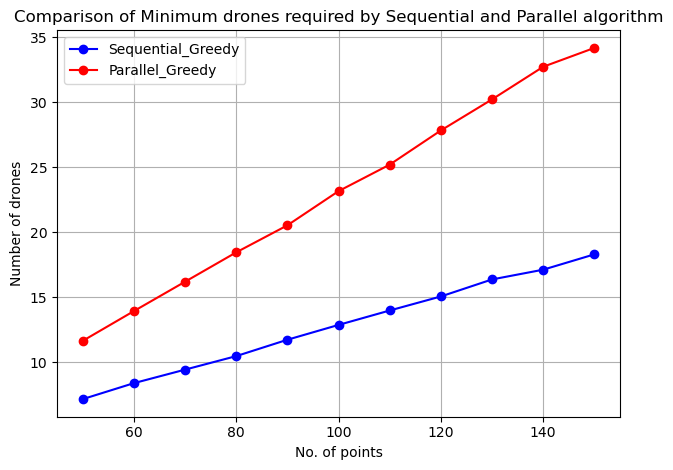

In [16]:
import math
import random
import matplotlib.pyplot as plt

def is_feasible(deliveries, R, v, num_drones, x_max, greedy_func):
    _, _, L_not_schd = greedy_func(deliveries, R, v, num_drones, x_max)
    return not L_not_schd

def binary_search_drones(deliveries, R, v, max_drones, x_max, greedy_func):
    low = 1
    high = max_drones
    min_drones = high

    while low <= high:
        mid = (low + high) // 2
        if is_feasible(deliveries, R, v, mid, x_max, greedy_func):
            min_drones = mid
            high = mid - 1
        else:
            low = mid + 1
    return min_drones

R = 0.6
v = 1.6
m = (R / (2 * v)) * math.sqrt(v**2 - 1)
x_max = 2
num_points_list = list(range(50, 151, 10))

num_trials = 100

num_drones_lst_1 = []
num_drones_lst_2 = []

for num_points in num_points_list:
    min_drones_sequential = []
    min_drones_parallel = []
    for _ in range(num_trials):
        deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
        deliveries.sort(key=lambda x: x[0])

        min_drones_sequential.append(binary_search_drones(deliveries, R, v, num_points, x_max, Sequential_Greedy))
        min_drones_parallel.append(binary_search_drones(deliveries, R, v, num_points, x_max, Parallel_Greedy))

    avg_drones_1 = sum(min_drones_sequential)/len(min_drones_sequential)
    avg_drones_2 = sum(min_drones_parallel)/len(min_drones_parallel)
    
    num_drones_lst_1.append(avg_drones_1)
    num_drones_lst_2.append(avg_drones_2)

plt.plot(num_points_list, num_drones_lst_1,'bo-', label='Sequential_Greedy')
plt.plot(num_points_list, num_drones_lst_2,'ro-', label='Parallel_Greedy')
plt.title("Comparison of Minimum drones required by Sequential and Parallel algorithm")
plt.xlabel("No. of points")
plt.ylabel("Number of drones")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<h2 style="text-align:center;">Section 2: Special case (Proper Instances)</h2>
<h3 style="text-align:center;">Objective: Maximize deliveries</h3>

### Generate proper instance

In [18]:
import math
import copy
import random

def calculate_es_ls_lr(R, v, d):
    if v <= 1:
        return None

    x, y = d
    M = R / 2
    m = (R/(2*v)) * math.sqrt(v**2 - 1)
    
    if abs(y) > m:
        return None
        
    x_prime = M * math.sqrt(1 - (y**2 / m**2))
    es = x - (R/(2*v)) - x_prime
    ls = x - (R/(2*v)) + x_prime
    lr = x + (R/(2*v)) + x_prime
    
    return round(es, 4), round(ls, 4), round(lr, 4)

def is_inside_triangle(p, A, B, C):
    def sign(p1, p2, p3):
        return (p1[0] - p3[0])*(p2[1] - p3[1]) - (p2[0] - p3[0])*(p1[1] - p3[1])
    b1 = sign(p, A, B) < 0.0
    b2 = sign(p, B, C) < 0.0
    b3 = sign(p, C, A) < 0.0
    return ((b1 == b2) and (b2 == b3))

def generate_proper_instance(n, R, v, x_max):
    D = []
    intervals = []

    if v <= 1:
        return D
    
    y_max = (R / (2 * v)) * math.sqrt(v**2 - 1)

    while len(D) < n:
        x = round(random.uniform(0, x_max), 4)
        y = round(random.uniform(0, y_max), 4)
        if x == 0 or y == 0:
            continue
        d = (x, y)
        calc = calculate_es_ls_lr(R, v, d)
        if calc is None:
            continue

        es, ls, lr = calc
        if ls < 0:
            continue

        valid = True
        for other_d in D:
            o_es, o_ls, o_lr = calculate_es_ls_lr(R, v, other_d)
            A = (o_es, 0)
            B = other_d
            C = (o_lr, 0)
            if is_inside_triangle(d, A, B, C):
                valid = False
                break

        if valid:
            new_interval = (es, ls)
            is_subset = False
            for inter in intervals:
                if (new_interval[0] > inter[0] and new_interval[1] < inter[1]) or (inter[0] > new_interval[0] and inter[1] < new_interval[1]):
                    is_subset = True
                    break
            if not is_subset:
                D.append(d)
                intervals.append(new_interval)      
        
    D = sorted(D, key=lambda x: x[0])
    
    return D

### Dynamic Programming for 1 drone

In [19]:
def compute_T_Table(D, R, v, x_max):
    n = len(D)
    T = [math.inf for _ in range(n)]
    T_prev = [math.inf for _ in range(n)]
    prev = [[-1 for _ in range(n)] for _ in range(n)]  
    s = 0
    es_ls_table = [calculate_es_ls(R, v, d) for d in D]
    ret(clear_cache = True)
    
    for j in range(n):
        result = es_ls_table[j]
        if result == None:
            continue
        es, ls = result
        if s <= ls:
            st = s
            if es > s:
                st = es
            T[j] = ret(st, v, D[j]) 
            prev[0][j] = 0
    T_prev = copy.deepcopy(T)
    T = [math.inf for _ in range(n)]
    for i in range(1, n):  
        flg = False 
        for j in range(i, n):
            result = es_ls_table[j]
            if result == None:
                continue
            es, ls = result
            for j_prime in range(j):
                s = T_prev[j_prime]
                if s <= ls and s < x_max:
                    if es > s:
                        s = es
                    candidate = ret(s, v, D[j])
                    if candidate < T[j]:
                        T[j] = candidate
                        prev[i][j] = j_prime   
                        flg = True
        if flg == True:
            T_prev = copy.deepcopy(T)
            T = [math.inf for _ in range(n)]
        else:
            break
        
    return prev
         
    
def calc_Schedule(prev):
    n = len(prev)
    schedule_indices = []
    
    def search():
        for i in range(n - 1, -1, -1):
            for j in range(n):
                if prev[i][j] != -1:
                    return(i, j)
        return (-1, -1)
    
    i, j = search()    
    if i == -1:
        return([])
    
    while i >= 0:
        schedule_indices.append(j)
        j = prev[i][j]
        i -= 1
        
    schedule_indices.reverse()
    
    return schedule_indices
    

### Example for Dynamic progarmming for 1 drone

In [18]:
R = 0.6  
v = 1.6 
x_max = 2
n = 20
s = 0
y_max = (R / (2 * v)) * math.sqrt(v**2 - 1)

points = generate_proper_instance(n, R, v, x_max)
prev = compute_T_Table(points, R, v, x_max)
schedule = calc_Schedule(prev)
lst = []

print("Deliveries that are scheduled:\n")
for i, j in enumerate(schedule, start = 1):
    r = ret(s, v, points[j])
    print(f"{i}. \t ({points[j][0]:.2f}, {points[j][1]:.2f}) \t Start time: {s:.2f} \t Return time: {r:.2f}")
    lst.extend([(s,0), (points[j][0], points[j][1]), (r, 0)])
    s = r
    

Deliveries that are scheduled:

1. 	 (0.18, 0.22) 	 Start time: 0.00 	 Return time: 0.35
2. 	 (0.55, 0.12) 	 Start time: 0.35 	 Return time: 0.57
3. 	 (0.66, 0.09) 	 Start time: 0.57 	 Return time: 0.71
4. 	 (0.89, 0.06) 	 Start time: 0.71 	 Return time: 0.87
5. 	 (0.91, 0.10) 	 Start time: 0.87 	 Return time: 1.04
6. 	 (1.14, 0.07) 	 Start time: 1.04 	 Return time: 1.16
7. 	 (1.24, 0.14) 	 Start time: 1.16 	 Return time: 1.39
8. 	 (1.59, 0.15) 	 Start time: 1.39 	 Return time: 1.64
9. 	 (1.66, 0.08) 	 Start time: 1.64 	 Return time: 1.79
10. 	 (1.98, 0.02) 	 Start time: 1.79 	 Return time: 1.94


### Sequential 1 Drone Dynamic Programming for k drones (Sequential_1DP)

In [20]:
def Sequential_1DP(points, R, v, k, x_max):
    scheds = []

    idx_pts = list(enumerate(points))
    idx_pts.sort(key=lambda t: t[1][0])

    s_pts = [p for (_, p) in idx_pts]
    s_idx = [i for (i, _) in idx_pts]

    avail = list(range(len(s_pts)))

    for _ in range(k):
        if not avail:
            break

        cur = [s_pts[i] for i in avail]
        prev = compute_T_Table(cur, R, v, x_max)
        rel = calc_Schedule(prev)

        if not rel:
            break

        abs_sorted = [avail[i] for i in rel]
        orig = [s_idx[i] for i in abs_sorted]

        scheds.append(orig)

        used = set(abs_sorted)
        avail = [i for i in avail if i not in used]

    return scheds


### Example for Sequential_1DP

In [20]:
R = 0.6  
v = 1.6 
x_max = 1
n = 10
k = 3

points = generate_proper_instance(n, R, v, x_max)
schedule_seq = Sequential_1DP(points, R, v, k, x_max)
sm_lst = []
bg_lst = []

print("Deliveries that are scheduled:")
for d in range(len(schedule_seq)):
    print(f"\nBy Drone {d+1}:\n")
    s = 0
    sm_lst = []
    for i, j in enumerate(schedule_seq[d], start = 1):
        r = ret(s, v, points[j])
        print(f"{i}. \t ({points[j][0]:.2f}, {points[j][1]:.2f}) \t Start time: {s:.2f} \t Return time: {r:.2f}")
        sm_lst.extend([(s,0), (points[j][0], points[j][1]), (r, 0)])
        s = r
    bg_lst.append(sm_lst)


Deliveries that are scheduled:

By Drone 1:

1. 	 (0.11, 0.21) 	 Start time: 0.00 	 Return time: 0.35
2. 	 (0.43, 0.17) 	 Start time: 0.35 	 Return time: 0.64
3. 	 (0.75, 0.11) 	 Start time: 0.64 	 Return time: 0.82
4. 	 (0.80, 0.10) 	 Start time: 0.82 	 Return time: 1.06

By Drone 2:

1. 	 (0.26, 0.21) 	 Start time: 0.00 	 Return time: 0.35
2. 	 (0.53, 0.19) 	 Start time: 0.35 	 Return time: 0.65
3. 	 (0.88, 0.15) 	 Start time: 0.65 	 Return time: 0.92
4. 	 (0.97, 0.14) 	 Start time: 0.92 	 Return time: 1.15

By Drone 3:

1. 	 (0.38, 0.17) 	 Start time: 0.00 	 Return time: 0.37
2. 	 (0.60, 0.20) 	 Start time: 0.37 	 Return time: 0.70


### Efficiency and runtime of Sequential 1DP

Range of Drone: 0.6
Velocity of Drone: 1.6
Total Number of points: 70
Total no. of Drones: 10
Max. Truck Distance: 2
No. of Trials: 10

1 Drone:
Sequential_1DP:		Avg. No. of Deliveries: 10.40,	Avg. Exec. Time: 0.0055 s

2 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 19.20,	Avg. Exec. Time: 0.0088 s

3 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 27.20,	Avg. Exec. Time: 0.0112 s

4 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 34.70,	Avg. Exec. Time: 0.0128 s

5 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 41.90,	Avg. Exec. Time: 0.0138 s

6 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 48.60,	Avg. Exec. Time: 0.0144 s

7 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 54.10,	Avg. Exec. Time: 0.0148 s

8 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 58.80,	Avg. Exec. Time: 0.0149 s

9 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 62.60,	Avg. Exec. Time: 0.0151 s

10 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 65.70,	Avg. Exec. Time: 0.0151 s


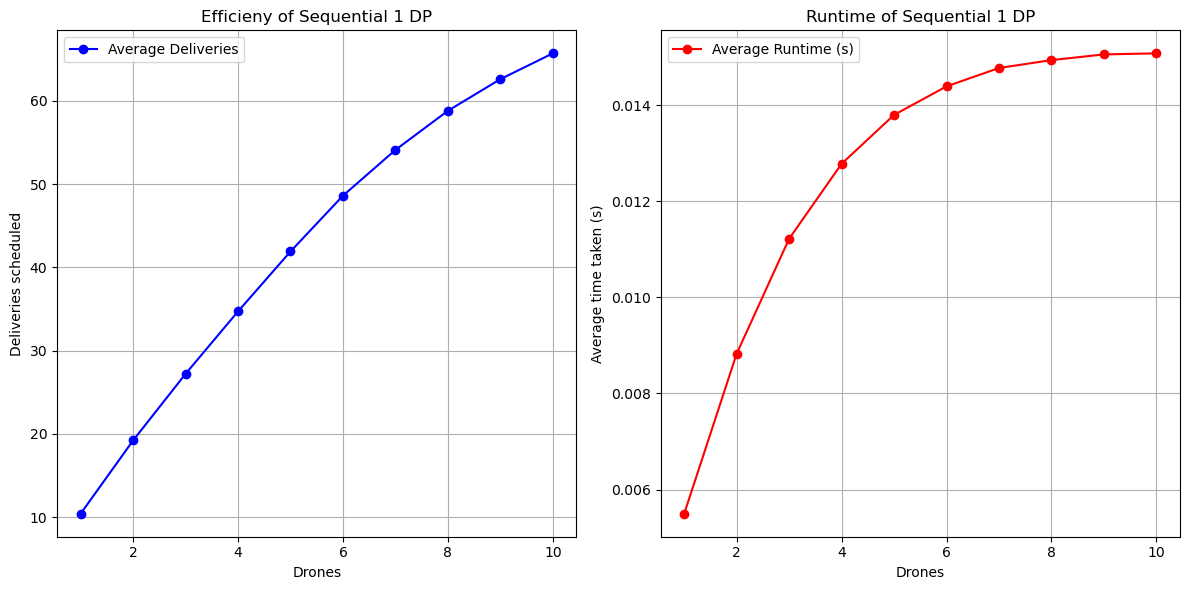

In [21]:
import math
import time
import random
import matplotlib.pyplot as plt

R = 0.6  
v = 1.6 
num_points = 70
num_drones = 10
x_max = 2
num_trials = 10
avg_count = []
avg_time = []
points = [[] for _ in range(num_trials)]

for i in range(num_trials):
    points[i] = generate_proper_instance(num_points, R, v, x_max)

print(f"Range of Drone: {R}")
print(f"Velocity of Drone: {v}")
print(f"Total Number of points: {num_points}")
print(f"Total no. of Drones: {num_drones}")
print(f"Max. Truck Distance: {x_max}")
print(f"No. of Trials: {num_trials}")

for k in range(1, num_drones + 1):
    total_count = []
    total_time = [] 
    for i in range(num_trials):
        start_time = time.time()
        schedule = Sequential_1DP(points[i], R, v, k, x_max)
        end_time = time.time()
        total_time.append(end_time - start_time)
        total_count.append(sum(len(s) for s in schedule if s))
                    
    avg = sum(total_count)/len(total_count)
    avg_count.append(avg)

    avg = calculate_mean_IQR(total_time)
    avg_time.append(avg)
        
    print(f"\n{k} Drone{'s' if k > 1 else ''}:")
    print(f"Sequential_1DP:\t\tAvg. No. of Deliveries: {avg_count[-1]:.2f},\tAvg. Exec. Time: {avg_time[-1]:.4f} s")
    
x = list(range(1, num_drones + 1))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, avg_count, 'bo-', label='Average Deliveries')
plt.title("Efficieny of Sequential 1 DP")
plt.xlabel("Drones")
plt.ylabel("Deliveries scheduled")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, avg_time, 'ro-', label='Average Runtime (s)')
plt.title("Runtime of Sequential 1 DP")
plt.xlabel("Drones")
plt.ylabel("Average time taken (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Parallel Dynamic Programming (Parallel_DP) for k drones

In [21]:
def compute_T_Table_Parallel(D, R, v, k, x_max):
    n = len(D)
    
    T = [[[math.inf for _ in range(k)] for _ in range(n)] for _ in range(n)]
    I = [[[-1 for _ in range(k)] for _ in range(n)] for _ in range(k)]
    prev = [[(-1, -1) for _ in range(n)] for _ in range(n)]
    j_prime = (-1, 0)
    ret(clear_cache = True)
    
    for i in range(k):
        for j in range(i, n):
            set1 = set()
            for d in range(i):
                prev_time = math.inf
                for jp in range(j):
                    if T[i-1][jp][d] != math.inf and prev_time > T[i-1][jp][d] and I[i-1][jp][d] not in set1:
                        prev_time = T[i-1][jp][d]
                        j_prime = jp
    
                T[i][j][d] = prev_time
                I[i][j][d] = I[i-1][j_prime][d]
                set1.add(I[i][j][d])
    
            es, ls = calculate_es_ls(R, v, D[j])
            
            T[i][j][i] = ret(max(0, es), v, D[j])
            I[i][j][i] = j
            
            for kp in range(i+1, k):
                T[i][j][kp] = 0
                
    for i in range(k, n):
        for j in range(i, n):
            prev_time = math.inf
            es, ls = calculate_es_ls(R, v, D[j])
            for d in range(k):  
                for jp in range(i - 1, j): 
                    if T[i - 1][jp][d] < prev_time and T[i - 1][jp][d] < x_max and T[i - 1][jp][d] <= ls: 
                        prev_time = T[i - 1][jp][d]
                        prev[i][j] = (jp, d)
            
            if prev_time != math.inf:
                T[i][j][prev[i][j][1]] = ret(max(es, prev_time), v, D[j])
                for kp in range(k):
                    if kp != prev[i][j][1]:
                        T[i][j][kp] = T[i - 1][prev[i][j][0]][kp]
        
    return prev, I[k-1]

def Calc_Schedule_Parallel(I_last, prev, k):
    
    n = len(prev)
    
    def search():
        for i in range(n - 1, -1, -1):
            for j in range(n):
                if prev[i][j] != (-1, -1):
                    return(i, j)
        return (-1, -1)

    i, j = search()

    schedules = [[] for _ in range(k)]
    while i >= k:
        d = prev[i][j][1]

        schedules[d].append(j)
        j = prev[i][j][0]
        i = i - 1
    
    for d in range(k):
        schedules[d].append(I_last[j][d])

    for i in range(k):
        schedules[i].reverse()

    return schedules

def Parallel_DP(points, R, v, k, x_max):
    prev, I = compute_T_Table_Parallel(points, R, v, k, x_max)    
    schedule = Calc_Schedule_Parallel(I, prev, k)
    
    return schedule

### Example for Parallel_DP

Deliveries that are scheduled:

By Drone 1:

1. 	 (0) 	 Start time: 0.00 	 Return time: 0.13
2. 	 (2) 	 Start time: 0.13 	 Return time: 0.46
3. 	 (17) 	 Start time: 0.46 	 Return time: 0.74
4. 	 (25) 	 Start time: 0.74 	 Return time: 1.11
5. 	 (39) 	 Start time: 1.11 	 Return time: 1.46
6. 	 (54) 	 Start time: 1.46 	 Return time: 1.73
7. 	 (60) 	 Start time: 1.73 	 Return time: 2.05

By Drone 2:

1. 	 (1) 	 Start time: 0.00 	 Return time: 0.31
2. 	 (9) 	 Start time: 0.31 	 Return time: 0.67
3. 	 (23) 	 Start time: 0.67 	 Return time: 1.04
4. 	 (36) 	 Start time: 1.04 	 Return time: 1.39
5. 	 (44) 	 Start time: 1.39 	 Return time: 1.74
6. 	 (64) 	 Start time: 1.74 	 Return time: 1.94
7. 	 (67) 	 Start time: 1.94 	 Return time: 2.30


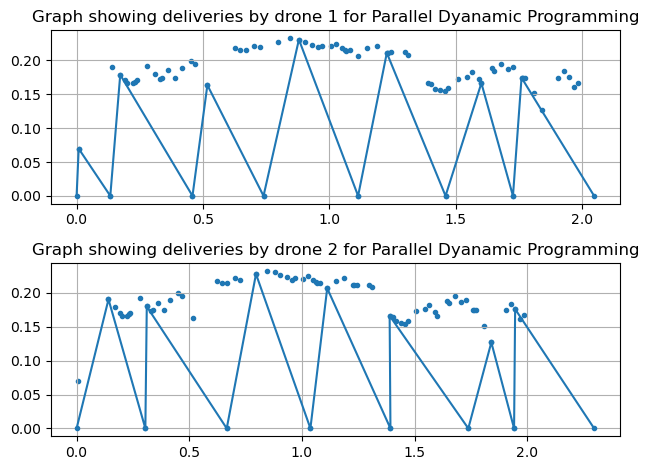

In [61]:
R = 0.6  
v = 1.6 
x_max = 2
n = 70
k = 2

points = generate_proper_instance(n, R, v, x_max)
schedule = Parallel_DP(points, R, v, k, x_max)

sm_lst = []
bg_lst = []

print("Deliveries that are scheduled:")
for d in range(k):
    print(f"\nBy Drone {d+1}:\n")
    s = 0
    sm_lst = []
    for i, j in enumerate(schedule[d], start = 1):
        r = ret(s,v,points[j])
        print(f"{i}. \t ({j}) \t Start time: {s:.2f} \t Return time: {r:.2f}")
        sm_lst.extend([(s,0), (points[j][0], points[j][1]), (r, 0)])
        s = r
    bg_lst.append(sm_lst)

for i in range(len(bg_lst)):
    plt.subplot(k, 1, i + 1)
    x, y = zip(*bg_lst[i])
    plt.plot(x, y, marker='.') 
    p, q = zip(*points)
    plt.scatter(p, q, marker='.') 
    plt.title(f"Graph showing deliveries by drone {i + 1} for Parallel Dyanamic Programming")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Efficiency and runtime of Parallel DP

Range of Drone: 0.6
Velocity of Drone: 1.6
Total Number of points: 70
Total no. of Drones: 10
Max. Truck Distance: 2
No. of Trials: 10

1 Drone:
Parallel_DP:		Avg. No. of Deliveries: 10.30,	Avg. Exec. Time: 0.0049 s

2 Drones:
Parallel_DP:		Avg. No. of Deliveries: 16.90,	Avg. Exec. Time: 0.0067 s

3 Drones:
Parallel_DP:		Avg. No. of Deliveries: 23.00,	Avg. Exec. Time: 0.0086 s

4 Drones:
Parallel_DP:		Avg. No. of Deliveries: 30.20,	Avg. Exec. Time: 0.0103 s

5 Drones:
Parallel_DP:		Avg. No. of Deliveries: 37.60,	Avg. Exec. Time: 0.0122 s

6 Drones:
Parallel_DP:		Avg. No. of Deliveries: 45.10,	Avg. Exec. Time: 0.0140 s

7 Drones:
Parallel_DP:		Avg. No. of Deliveries: 52.20,	Avg. Exec. Time: 0.0159 s

8 Drones:
Parallel_DP:		Avg. No. of Deliveries: 60.10,	Avg. Exec. Time: 0.0177 s

9 Drones:
Parallel_DP:		Avg. No. of Deliveries: 65.90,	Avg. Exec. Time: 0.0197 s

10 Drones:
Parallel_DP:		Avg. No. of Deliveries: 68.30,	Avg. Exec. Time: 0.0213 s


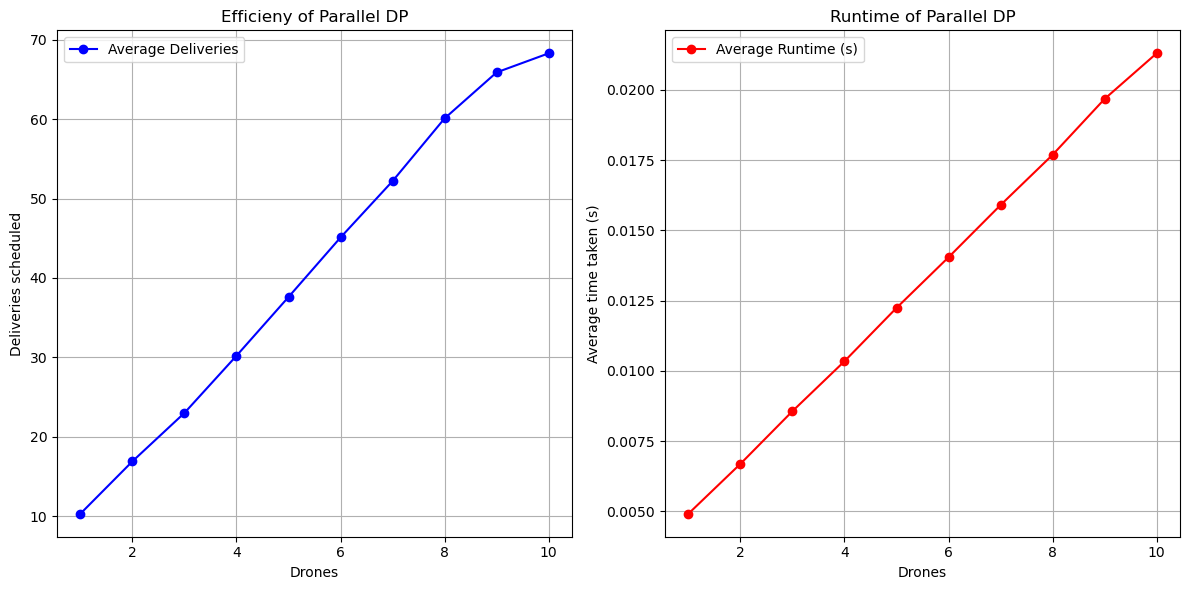

In [24]:
import math
import time
import random
import matplotlib.pyplot as plt

R = 0.6  
v = 1.6 
num_points = 70
num_drones = 10
x_max = 2
num_trials = 10
avg_count = []
avg_time = []
points = [[] for _ in range(num_trials)]

for i in range(num_trials):
    points[i] = generate_proper_instance(num_points, R, v, x_max)

print(f"Range of Drone: {R}")
print(f"Velocity of Drone: {v}")
print(f"Total Number of points: {num_points}")
print(f"Total no. of Drones: {num_drones}")
print(f"Max. Truck Distance: {x_max}")
print(f"No. of Trials: {num_trials}")

for k in range(1, num_drones + 1):
    total_count = []
    total_time = [] 
    for i in range(num_trials):
        start_time = time.time()
        schedule = Parallel_DP(points[i], R, v, k, x_max)
        end_time = time.time()
        total_time.append(end_time - start_time)
        total_count.append(sum(len(s) for s in schedule if s))
                    
    avg = sum(total_count)/len(total_count)
    avg_count.append(avg)

    avg = calculate_mean_IQR(total_time)
    avg_time.append(avg)
        
    print(f"\n{k} Drone{'s' if k > 1 else ''}:")
    print(f"Parallel_DP:\t\tAvg. No. of Deliveries: {avg_count[-1]:.2f},\tAvg. Exec. Time: {avg_time[-1]:.4f} s")
    
x = list(range(1, num_drones + 1))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, avg_count, 'bo-', label='Average Deliveries')
plt.title("Efficieny of Parallel DP")
plt.xlabel("Drones")
plt.ylabel("Deliveries scheduled")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, avg_time, 'ro-', label='Average Runtime (s)')
plt.title("Runtime of Parallel DP")
plt.xlabel("Drones")
plt.ylabel("Average time taken (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Seqeuntial 2 Drone Dynamic programming (Sequential_2DP) for k drones

In [22]:
import numpy as np
import math

def compute_T_Table_2DP(D, R, v, x_max):
    num_points = len(D)
    rows = num_points // 2
    T = [[[math.inf, math.inf] for _ in range(num_points)] for _ in range(num_points)]
    T_prev = [[[math.inf, math.inf] for _ in range(num_points)] for _ in range(num_points)]
    prev = [[[(-1, -1) for _ in range(num_points)] for _ in range(num_points)] for _ in range(rows)]
    two = 2
    s = 0
    r = [math.inf, math.inf]
    es_ls_table = [calculate_es_ls(R, v, d) for d in D]
    used_sets = [[[frozenset() for _ in range(num_points)] for _ in range(num_points)] for _ in range(rows)]
    
    for I in range(rows):
        flg = False
        for i in range(num_points):
            for j in range(num_points):
                if i == j:
                    continue
                r = [math.inf, math.inf]
                if I == 0:
                    tpl = (i, j)
                    current_set = frozenset([i, j])
                    for k in range(two):
                        result = es_ls_table[tpl[k]]
                        if result == None:
                            continue
                        es, ls = result
                        if s <= ls:
                            st = s
                            if es > s:
                                st = es
                            r[k] = ret(st, v, D[tpl[k]])
                    if r[0] != math.inf and r[1] != math.inf:
                        T[i][j] = r[:]
                        prev[I][i][j] = (0, 0)
                        used_sets[I][i][j] = current_set
                        flg = True
                else:
                    min_val = math.inf
                    for i1 in range(i):
                        for j1 in range(j):
                            if T_prev[i1][j1] == [math.inf, math.inf]:
                                continue       
                            pred_set = used_sets[I-1][i1][j1]
                            
                            if i in pred_set or j in pred_set:
                                continue

                            s = T_prev[i1][j1]
                            tpl = (i, j)
                            r = [math.inf, math.inf]
                            for k in range(two):
                                result = es_ls_table[tpl[k]]
                                if result == None:
                                    continue
                                es, ls = result
                                if s[k] <= ls and s[k] < x_max:
                                    st = s[k]
                                    if es > s[k]:
                                        st = es
                                    r[k] = ret(st, v, D[tpl[k]])

                            max_r = r[0] if r[0] > r[1] else r[1]
                            
                            if math.inf not in r and max_r < min_val:
                                T[i][j] = r[:]
                                prev[I][i][j] = (i1, j1)
                                min_val = max_r
                                current_set = pred_set.union({i, j})
                                used_sets[I][i][j] = current_set
                                flg = True
        if flg == True:
            T_prev = copy.deepcopy(T)
            T = [[[math.inf, math.inf] for _ in range(num_points)] for _ in range(num_points)]
        else:
            break
            
    return prev

    
def calc_Schedule_2DP(prev):
    two = 2
    n = len(prev)
    schedule = [[] for _ in range(two)]
    if n == 0:
        return schedule
    num_points = len(prev[0])
    
    def search():
        for I in range(n - 1, -1, -1):
            for i in range(num_points):
                for j in range(num_points):
                    if prev[I][i][j] != (-1, -1):
                        return(I, i, j)
        return (-1, -1, -1)
    
    I, i, j = search()
    if I == -1:
        return schedule
    
    schedule[0].append(i)
    schedule[1].append(j)
        
    while I > 0:
        i, j = prev[I][i][j]
        schedule[0].append(i)
        schedule[1].append(j)
        I -= 1
    
    for d in range(two):
        schedule[d].reverse()
    
    return schedule


def Sequential_2DP(points, R, v, k, x_max):
    schedules = []
    indexed = sorted(enumerate(points), key=lambda x: x[1][0])
    sorted_pts = [p for _, p in indexed]
    orig_idx = [i for i, _ in indexed]

    avail = list(range(len(sorted_pts)))
    NUM = 2

    ret(clear_cache=True)

    for _ in range(k // NUM):
        curr = [sorted_pts[p] for p in avail]
        if not curr:
            break

        prev_tbl = compute_T_Table_2DP(curr, R, v, x_max)
        rel = calc_Schedule_2DP(prev_tbl)

        taken = set()
        for route in rel:
            if route:
                gpos = [avail[r] for r in route]
                schedules.append([orig_idx[p] for p in gpos])
                taken.update(gpos)

        avail = [p for p in avail if p not in taken]

    # handle remaining single drone
    if (k % 2 == 1) and avail:
        final_pts = [sorted_pts[p] for p in avail]
        final_idx = [orig_idx[p] for p in avail]

        prev1 = compute_T_Table(final_pts, R, v, x_max)
        rel1 = calc_Schedule(prev1)

        if rel1:
            schedules.append([final_idx[r] for r in rel1])

    return schedules

### Example for Sequential_2DP

In [26]:
R = 0.6  
v = 1.6 
x_max = 2
n = 70
k = 2

points = generate_proper_instance(n, R, v, x_max)
schedule = Sequential_2DP(points, R, v, k, x_max)
        
sm_lst = []
bg_lst = []

print("Deliveries that are scheduled:")
for d in range(len(schedule)):
    print(f"\nBy Drone {d+1}:\n")
    s = 0
    sm_lst = []
    for i, j in enumerate(schedule[d], start = 1):
        r = ret(s, v, points[j])
        print(f"{i}. \t {j} \t Start time: {s:.2f} \t Return time: {r:.2f}")
        sm_lst.extend([(s,0), (points[j][0], points[j][1]), (r, 0)])
        s = r
    bg_lst.append(sm_lst)


Deliveries that are scheduled:

By Drone 1:

1. 	 0 	 Start time: 0.00 	 Return time: 0.37
2. 	 13 	 Start time: 0.37 	 Return time: 0.59
3. 	 25 	 Start time: 0.59 	 Return time: 0.87
4. 	 33 	 Start time: 0.87 	 Return time: 1.16
5. 	 41 	 Start time: 1.16 	 Return time: 1.36
6. 	 46 	 Start time: 1.36 	 Return time: 1.58
7. 	 57 	 Start time: 1.58 	 Return time: 1.79
8. 	 62 	 Start time: 1.79 	 Return time: 1.98
9. 	 66 	 Start time: 1.98 	 Return time: 2.31

By Drone 2:

1. 	 3 	 Start time: 0.00 	 Return time: 0.34
2. 	 14 	 Start time: 0.34 	 Return time: 0.60
3. 	 26 	 Start time: 0.60 	 Return time: 0.87
4. 	 36 	 Start time: 0.87 	 Return time: 1.10
5. 	 37 	 Start time: 1.10 	 Return time: 1.30
6. 	 44 	 Start time: 1.30 	 Return time: 1.53
7. 	 58 	 Start time: 1.53 	 Return time: 1.76
8. 	 63 	 Start time: 1.76 	 Return time: 2.00
9. 	 67 	 Start time: 2.00 	 Return time: 2.36


### Efficiency and Runtime of Sequential 2DP

Range of Drone: 0.6
Velocity of Drone: 1.6
Total Number of points: 70
Total no. of Drones: 10
Max. Truck Distance: 2
No. of Trials: 10

1 Drone:
Sequential_2DP:		Avg. No. of Deliveries: 10.20,	Avg. Exec. Time: 0.0051 s

2 Drones:
Sequential_2DP:		Avg. No. of Deliveries: 18.20,	Avg. Exec. Time: 15.1687 s

3 Drones:
Sequential_2DP:		Avg. No. of Deliveries: 26.60,	Avg. Exec. Time: 15.0105 s

4 Drones:
Sequential_2DP:		Avg. No. of Deliveries: 34.40,	Avg. Exec. Time: 18.8160 s

5 Drones:
Sequential_2DP:		Avg. No. of Deliveries: 41.90,	Avg. Exec. Time: 18.7293 s

6 Drones:
Sequential_2DP:		Avg. No. of Deliveries: 48.40,	Avg. Exec. Time: 19.3074 s

7 Drones:
Sequential_2DP:		Avg. No. of Deliveries: 55.00,	Avg. Exec. Time: 19.4590 s

8 Drones:
Sequential_2DP:		Avg. No. of Deliveries: 59.60,	Avg. Exec. Time: 19.8455 s

9 Drones:
Sequential_2DP:		Avg. No. of Deliveries: 64.00,	Avg. Exec. Time: 19.7412 s

10 Drones:
Sequential_2DP:		Avg. No. of Deliveries: 65.80,	Avg. Exec. Time: 19.6134 s


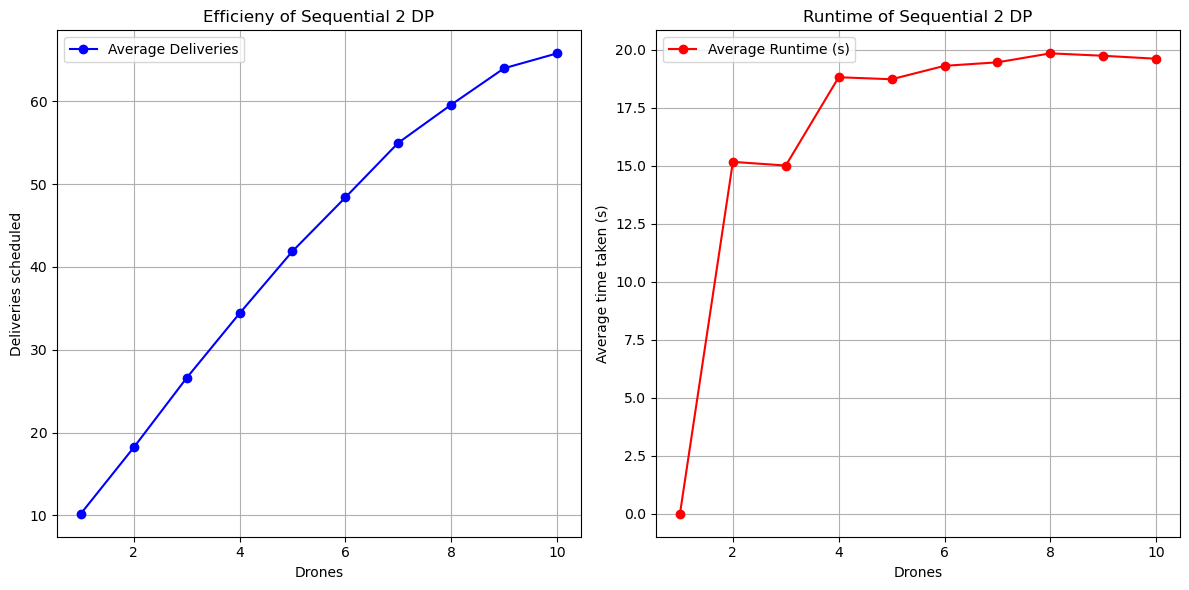

In [27]:
import math
import time
import random
import matplotlib.pyplot as plt
import gc
from math import ceil

R = 0.6  
v = 1.6 
num_points = 70
num_drones = 10
x_max = 2
num_trials = 10
avg_count = []
avg_time = []
points = [[] for _ in range(num_trials)]

for i in range(num_trials):
    points[i] = generate_proper_instance(num_points, R, v, x_max)

print(f"Range of Drone: {R}")
print(f"Velocity of Drone: {v}")
print(f"Total Number of points: {num_points}")
print(f"Total no. of Drones: {num_drones}")
print(f"Max. Truck Distance: {x_max}")
print(f"No. of Trials: {num_trials}")
    
for k in range(1, num_drones + 1):
    total_count = []
    total_time = [] 
    for i in range(num_trials):
        start_time = time.time()
        schedule = Sequential_2DP(points[i], R, v, k, x_max)
        end_time = time.time()
        total_time.append(end_time - start_time)
        total_count.append(sum(len(s) for s in schedule if s))
        
    avg = sum(total_count)/len(total_count)
    avg_count.append(avg)

    avg = calculate_mean_IQR(total_time)
    avg_time.append(avg)
        
    print(f"\n{k} Drone{'s' if k > 1 else ''}:")
    print(f"Sequential_2DP:\t\tAvg. No. of Deliveries: {avg_count[-1]:.2f},\tAvg. Exec. Time: {avg_time[-1]:.4f} s")

x = list(range(1, num_drones + 1))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, avg_count, 'bo-', label='Average Deliveries')
plt.title("Efficieny of Sequential 2 DP")
plt.xlabel("Drones")
plt.ylabel("Deliveries scheduled")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, avg_time, 'ro-', label='Average Runtime (s)')
plt.title("Runtime of Sequential 2 DP")
plt.xlabel("Drones")
plt.ylabel("Average time taken (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Seqeuntial 2 Drone Dynamic programming* (Sequential_2DP*) for k drones

In [23]:
import numpy as np
import math

def compute_T_Table_2DP_Star(D, R, v, x_max):
    num_points = len(D)
    rows = num_points * 2
    T = [[[[math.inf, math.inf] for _ in range(num_points)] for _ in range(num_points)]for _ in range(rows)]
    prev = [[[(-1, -1) for _ in range(num_points)] for _ in range(num_points)] for _ in range(rows)]
    two = 2
    s = 0
    r = [math.inf, math.inf]
    es_ls_table = [calculate_es_ls(R, v, d) for d in D]
    used_sets = [[[frozenset() for _ in range(num_points)] for _ in range(num_points)] for _ in range(rows)]
    flg_prev = False
    for I in range(rows):
        flg = False
        for i in range(num_points):
            for j in range(num_points):
                if i == j:
                    continue
                min_val = math.inf
               
                if I == 0:
                    tpl = (i, j)
                    r = [math.inf, math.inf]
                    current_set = frozenset([i, j])
                    
                    for k in range(two):
                        result = es_ls_table[tpl[k]]
                        if result == None:
                            continue
                        es, ls = result
                        if s <= ls:
                            st = s
                            if es > s:
                                st = es
                            r[k] = ret(st, v, D[tpl[k]])
                    if math.inf not in r:
                        T[I][i][j] = r[:]
                        prev[I][i][j] = (0, 0)
                        used_sets[I][i][j] = current_set
                        flg = True
                else:
                    for i1 in range(i):
                        if T[I-1][i1][j] == [math.inf, math.inf]:
                            continue       
                        
                        pred_set = used_sets[I-1][i1][j]
                            
                        if i in pred_set:
                            continue
                            
                        s = T[I-1][i1][j][0]
                        r = [math.inf, T[I-1][i1][j][1]]
                        
                        result = es_ls_table[i]
                        if result == None:
                            continue
                        es, ls = result
                        if s <= ls and s < x_max:
                            st = s
                            if es > s:
                                st = es
                            r[0] = ret(st, v, D[i])

                        max_r = r[0] if r[0] > r[1] else r[1]

                        if math.inf not in r and max_r < min_val:
                            T[I][i][j] = r[:]
                            prev[I][i][j] = (i1, j)
                            min_val = max_r
                            current_set = pred_set.union({i})
                            used_sets[I][i][j] = current_set
                            flg = True
                    
                    for j1 in range(j):
                        if T[I-1][i][j1] == [math.inf, math.inf]:
                            continue  
                            
                        pred_set = used_sets[I-1][i][j1]
                            
                        if j in pred_set:
                            continue

                        s = T[I-1][i][j1][1]
                        r = [T[I-1][i][j1][0], math.inf]
                        
                        result = es_ls_table[j]
                        if result == None:
                            continue
                        es, ls = result
                        if s <= ls and s < x_max:
                            st = s
                            if es > s:
                                st = es
                            r[1] = ret(st, v, D[j])

                        max_r = r[0] if r[0] > r[1] else r[1]

                        if math.inf not in r and max_r < min_val:
                            T[I][i][j] = r[:]
                            prev[I][i][j] = (i, j1)
                            min_val = max_r
                            current_set = pred_set.union({j})
                            used_sets[I][i][j] = current_set
                            flg = True
                            
                if I > 1:
                    for i1 in range(i):
                        for j1 in range(j):
                            if T[I-2][i1][j1] == [math.inf, math.inf]:
                                continue      
                                
                            pred_set = used_sets[I-2][i1][j1]
                            
                            if i in pred_set or j in pred_set:
                                continue

                            s = T[I-2][i1][j1]
                            tpl = (i, j)
                            r = [math.inf, math.inf]
                            for k in range(two):
                                result = es_ls_table[tpl[k]]
                                if result == None:
                                    continue
                                es, ls = result
                                if s[k] <= ls and s[k] < x_max:
                                    st = s[k]
                                    if es > s[k]:
                                        st = es
                                    r[k] = ret(st, v, D[tpl[k]])

                            max_r = r[0] if r[0] > r[1] else r[1]
                            
                            if math.inf not in r and max_r < min_val:
                                T[I][i][j] = r[:]
                                prev[I][i][j] = (i1, j1)
                                min_val = max_r
                                current_set = pred_set.union({i, j})
                                used_sets[I][i][j] = current_set
                                flg = True
        
        if not flg and not flg_prev:
            break    
        flg_prev = flg
    return prev

    
def calc_Schedule_2DP_Star(prev):
    two = 2
    n = len(prev)
    num_points = len(prev[0])
    schedule = [[] for _ in range(two)]
    if n == 0:
        return schedule
    
    def search():
        for I in range(n - 1, -1, -1):
            for i in range(num_points):
                for j in range(num_points):
                    if prev[I][i][j] != (-1, -1):
                        return(I, i, j)
        return (-1, -1, -1)
    
    I, i, j = search()
    if I == -1:
        return schedule
    schedule[0].append(i)
    schedule[1].append(j)
        
    while I > 0:
        i1, j1 = prev[I][i][j]
        if i1 != i:
            schedule[0].append(i1)
        if j1 != j:
            schedule[1].append(j1)
        if i1 == i or j1 == j:
            I -= 1
        else:
            I -= 2
        i, j = i1, j1
        
    for d in range(two):
        schedule[d].reverse()
    
    return schedule


def Sequential_2DP_Star(points, R, v, k, x_max):
    schedules = []
    indexed = sorted(enumerate(points), key=lambda x: x[1][0])
    sorted_pts = [p for _, p in indexed]
    orig_idx = [i for i, _ in indexed]

    avail = list(range(len(sorted_pts)))
    NUM = 2

    ret(clear_cache=True)

    for _ in range(k // NUM):
        curr = [sorted_pts[p] for p in avail]
        if not curr:
            break

        prev_tbl = compute_T_Table_2DP_Star(curr, R, v, x_max)
        rel = calc_Schedule_2DP_Star(prev_tbl)

        taken = set()
        for route in rel:
            if route:
                gpos = [avail[r] for r in route]
                schedules.append([orig_idx[p] for p in gpos])
                taken.update(gpos)

        avail = [p for p in avail if p not in taken]

    # handle remaining single drone
    if (k % NUM == 1) and avail:
        final_pts = [sorted_pts[p] for p in avail]
        final_idx = [orig_idx[p] for p in avail]

        prev1 = compute_T_Table(final_pts, R, v, x_max)
        rel1 = calc_Schedule(prev1)

        if rel1:
            schedules.append([final_idx[r] for r in rel1])

    return schedules

### Example for Sequential_2DP*

In [29]:
R = 0.6  
v = 1.6 
x_max = 2
n = 70
k = 2

points = generate_proper_instance(n, R, v, x_max)
schedule = Sequential_2DP_Star(points, R, v, k, x_max)
        
sm_lst = []
bg_lst = []

print("Deliveries that are scheduled:")
for d in range(len(schedule)):
    print(f"\nBy Drone {d+1}:\n")
    s = 0
    sm_lst = []
    for i, j in enumerate(schedule[d], start = 1):
        r = ret(s, v, points[j])
        print(f"{i}. \t {j} \t Start time: {s:.2f} \t Return time: {r:.2f}")
        sm_lst.extend([(s,0), (points[j][0], points[j][1]), (r, 0)])
        s = r
    bg_lst.append(sm_lst)


Deliveries that are scheduled:

By Drone 1:

1. 	 3 	 Start time: 0.00 	 Return time: 0.13
2. 	 4 	 Start time: 0.13 	 Return time: 0.29
3. 	 14 	 Start time: 0.29 	 Return time: 0.46
4. 	 16 	 Start time: 0.46 	 Return time: 0.61
5. 	 26 	 Start time: 0.61 	 Return time: 0.72
6. 	 31 	 Start time: 0.72 	 Return time: 0.97
7. 	 42 	 Start time: 0.97 	 Return time: 1.13
8. 	 45 	 Start time: 1.13 	 Return time: 1.39
9. 	 57 	 Start time: 1.39 	 Return time: 1.68
10. 	 65 	 Start time: 1.68 	 Return time: 1.92
11. 	 68 	 Start time: 1.92 	 Return time: 2.29

By Drone 2:

1. 	 1 	 Start time: 0.00 	 Return time: 0.17
2. 	 7 	 Start time: 0.17 	 Return time: 0.25
3. 	 13 	 Start time: 0.25 	 Return time: 0.48
4. 	 15 	 Start time: 0.48 	 Return time: 0.60
5. 	 25 	 Start time: 0.60 	 Return time: 0.82
6. 	 33 	 Start time: 0.82 	 Return time: 1.04
7. 	 38 	 Start time: 1.04 	 Return time: 1.33
8. 	 55 	 Start time: 1.33 	 Return time: 1.62
9. 	 66 	 Start time: 1.62 	 Return time: 1.94
10.

### Efficiency and Runtime of Sequential 2DP*

Range of Drone: 0.6
Velocity of Drone: 1.6
Total Number of points: 70
Total no. of Drones: 10
Max. Truck Distance: 2
No. of Trials: 10

1 Drone:
Sequential_2DP*:	Avg. No. of Deliveries: 10.20,	Avg. Exec. Time: 0.0052 s

2 Drones:
Sequential_2DP*:	Avg. No. of Deliveries: 18.80,	Avg. Exec. Time: 40.4883 s

3 Drones:
Sequential_2DP*:	Avg. No. of Deliveries: 27.00,	Avg. Exec. Time: 40.4858 s

4 Drones:
Sequential_2DP*:	Avg. No. of Deliveries: 34.90,	Avg. Exec. Time: 49.7887 s

5 Drones:
Sequential_2DP*:	Avg. No. of Deliveries: 42.30,	Avg. Exec. Time: 49.8825 s

6 Drones:
Sequential_2DP*:	Avg. No. of Deliveries: 48.90,	Avg. Exec. Time: 50.8579 s

7 Drones:
Sequential_2DP*:	Avg. No. of Deliveries: 54.50,	Avg. Exec. Time: 50.9939 s

8 Drones:
Sequential_2DP*:	Avg. No. of Deliveries: 59.30,	Avg. Exec. Time: 51.5237 s

9 Drones:
Sequential_2DP*:	Avg. No. of Deliveries: 62.80,	Avg. Exec. Time: 51.7093 s

10 Drones:
Sequential_2DP*:	Avg. No. of Deliveries: 65.40,	Avg. Exec. Time: 51.6091 s


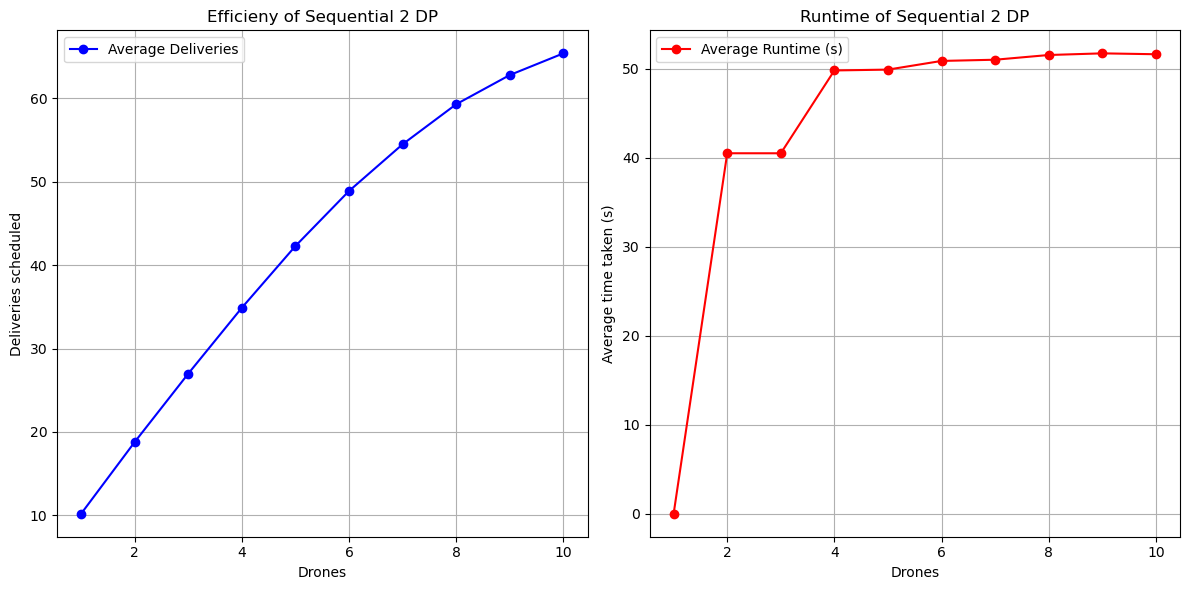

In [30]:
import math
import time
import random
import matplotlib.pyplot as plt
import gc
from math import ceil

R = 0.6  
v = 1.6 
num_points = 70
num_drones = 10
x_max = 2
num_trials = 10
avg_count = []
avg_time = []
points = [[] for _ in range(num_trials)]

for i in range(num_trials):
    points[i] = generate_proper_instance(num_points, R, v, x_max)

print(f"Range of Drone: {R}")
print(f"Velocity of Drone: {v}")
print(f"Total Number of points: {num_points}")
print(f"Total no. of Drones: {num_drones}")
print(f"Max. Truck Distance: {x_max}")
print(f"No. of Trials: {num_trials}")
    
for k in range(1, num_drones + 1):
    total_count = []
    total_time = [] 
    for i in range(num_trials):
        start_time = time.time()
        schedule = Sequential_2DP_Star(points[i], R, v, k, x_max)
        end_time = time.time()
        total_time.append(end_time - start_time)
        total_count.append(sum(len(s) for s in schedule if s))
        
    avg = sum(total_count)/len(total_count)
    avg_count.append(avg)

    avg = calculate_mean_IQR(total_time)
    avg_time.append(avg)
        
    print(f"\n{k} Drone{'s' if k > 1 else ''}:")
    print(f"Sequential_2DP*:\tAvg. No. of Deliveries: {avg_count[-1]:.2f},\tAvg. Exec. Time: {avg_time[-1]:.4f} s")

x = list(range(1, num_drones + 1))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, avg_count, 'bo-', label='Average Deliveries')
plt.title("Efficieny of Sequential 2 DP")
plt.xlabel("Drones")
plt.ylabel("Deliveries scheduled")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, avg_time, 'ro-', label='Average Runtime (s)')
plt.title("Runtime of Sequential 2 DP")
plt.xlabel("Drones")
plt.ylabel("Average time taken (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Comparison of Sequential_1DP, Sequential_2DP, Sequential_2DP*, Parallel_DP and Sequential_Greedy Algorithms

Range of Drone: 0.6
Velocity of Drone: 1.6
Total Number of points: 70
Total no. of Drones: 10
Max. Truck Distance: 2
No. of Trials: 10

1 Drone:
Sequential_1DP:		Avg. No. of Deliveries: 10.40,	Avg. Exec. Time: 0.0054 s
Parallel_DP:		Avg. No. of Deliveries: 10.40,	Avg. Exec. Time: 0.0048 s
Sequential_2DP:		Avg. No. of Deliveries: 10.40,	Avg. Exec. Time: 0.0054 s
Sequential_2DP*:	Avg. No. of Deliveries: 10.40,	Avg. Exec. Time: 0.0054 s
Sequential_Greedy:	Avg. No. of Deliveries: 10.20,	Avg. Exec. Time: 0.0003 s

2 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 19.10,	Avg. Exec. Time: 0.0088 s
Parallel_DP:		Avg. No. of Deliveries: 16.50,	Avg. Exec. Time: 0.0066 s
Sequential_2DP:		Avg. No. of Deliveries: 18.60,	Avg. Exec. Time: 15.6924 s
Sequential_2DP*:	Avg. No. of Deliveries: 19.50,	Avg. Exec. Time: 42.1715 s
Sequential_Greedy:	Avg. No. of Deliveries: 18.90,	Avg. Exec. Time: 0.0010 s

3 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 27.30,	Avg. Exec. Time: 0.0113 s
Parallel_DP:		Avg. 

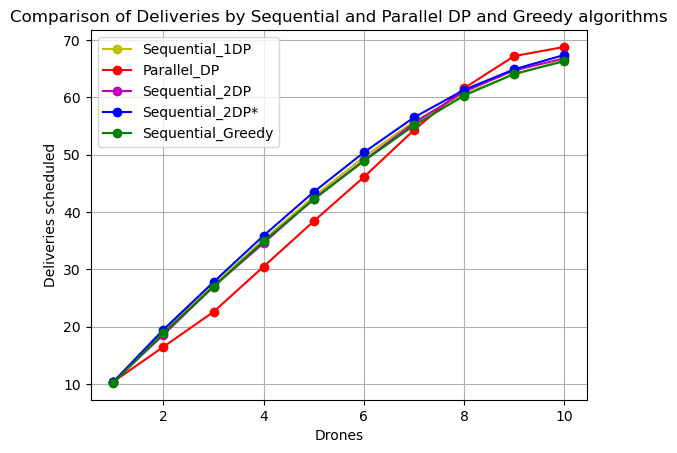

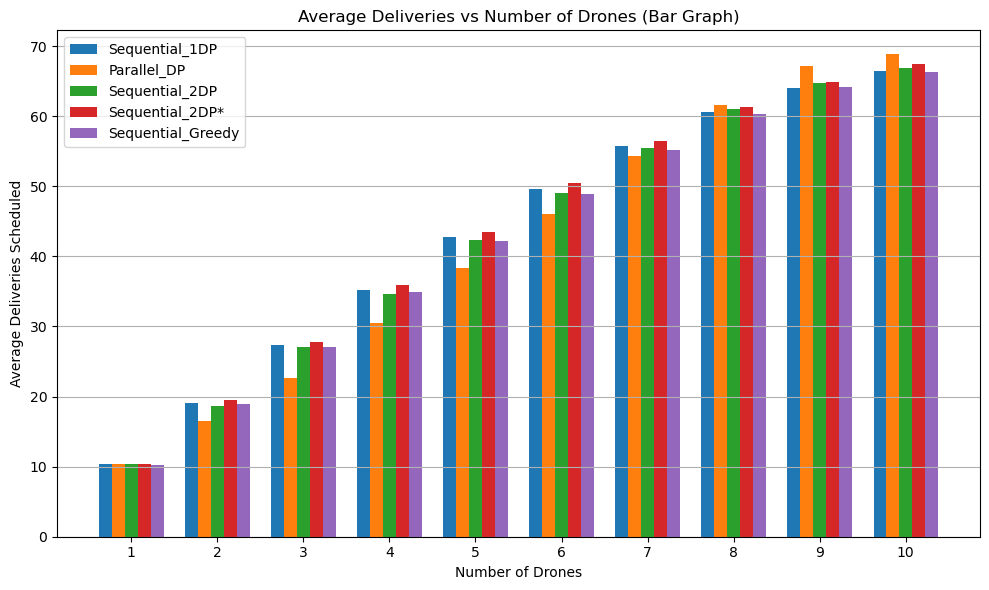

In [79]:
import math
import time
import random
import matplotlib.pyplot as plt
import gc
import numpy as np

R = 0.6  
v = 1.6 
num_points = 70
num_drones = 10
x_max = 2
num_trials = 10
num_algs = 5
avg_count = [[] for _ in range(num_algs)]
avg_time = [[] for _ in range(num_algs)]
points = [[] for _ in range(num_trials)]

for i in range(num_trials):
    points[i] = generate_proper_instance(num_points, R, v, x_max)

print(f"Range of Drone: {R}")
print(f"Velocity of Drone: {v}")
print(f"Total Number of points: {num_points}")
print(f"Total no. of Drones: {num_drones}")
print(f"Max. Truck Distance: {x_max}")
print(f"No. of Trials: {num_trials}")

gc.disable()

for k in range(1, num_drones + 1):
    total_count = [[] for _ in range(num_algs)]
    total_time = [[] for _ in range(num_algs)]
    for i in range(num_trials):
        schedule = [[] for _ in range(num_algs)] 
        
        start_time = time.time()
        schedule[0] = Sequential_1DP(points[i], R, v, k, x_max)
        end_time = time.time()
        total_time[0].append(end_time - start_time)
        
        start_time = time.time()
        schedule[1] = Parallel_DP(points[i], R, v, k, x_max)
        end_time = time.time()
        total_time[1].append(end_time - start_time)
        
        start_time = time.time()
        schedule[2] = Sequential_2DP(points[i], R, v, k, x_max)
        end_time = time.time()
        total_time[2].append(end_time - start_time)
        
        start_time = time.time()
        schedule[3] = Sequential_2DP_Star(points[i], R, v, k, x_max)
        end_time = time.time()
        total_time[3].append(end_time - start_time)
        
        start_time = time.time()
        schedule[4], _, _ = Sequential_Greedy(points[i], R, v, k, x_max)
        end_time = time.time()
        total_time[4].append(end_time - start_time)
        
        for alg_idx in range(num_algs):
            total_count[alg_idx].append(sum(len(s) for s in schedule[alg_idx] if s))
                    
    for alg_idx in range(num_algs):
        avg = sum(total_count[alg_idx])/len(total_count[alg_idx])
        avg_count[alg_idx].append(avg)
        
        avg = calculate_mean_IQR(total_time[alg_idx])
        avg_time[alg_idx].append(avg)
        
    print(f"\n{k} Drone{'s' if k > 1 else ''}:")
    print(f"Sequential_1DP:\t\tAvg. No. of Deliveries: {avg_count[0][-1]:.2f},\tAvg. Exec. Time: {avg_time[0][-1]:.4f} s")
    print(f"Parallel_DP:\t\tAvg. No. of Deliveries: {avg_count[1][-1]:.2f},\tAvg. Exec. Time: {avg_time[1][-1]:.4f} s")
    print(f"Sequential_2DP:\t\tAvg. No. of Deliveries: {avg_count[2][-1]:.2f},\tAvg. Exec. Time: {avg_time[2][-1]:.4f} s")
    print(f"Sequential_2DP*:\tAvg. No. of Deliveries: {avg_count[3][-1]:.2f},\tAvg. Exec. Time: {avg_time[3][-1]:.4f} s")
    print(f"Sequential_Greedy:\tAvg. No. of Deliveries: {avg_count[4][-1]:.2f},\tAvg. Exec. Time: {avg_time[4][-1]:.4f} s")
    
gc.enable()

x = list(range(1, num_drones + 1))

plt.plot(x, avg_count[0],'yo-', label='Sequential_1DP')
plt.plot(x, avg_count[1],'ro-', label='Parallel_DP')
plt.plot(x, avg_count[2],'mo-', label='Sequential_2DP')
plt.plot(x, avg_count[3],'bo-', label='Sequential_2DP*')
plt.plot(x, avg_count[4],'go-', label='Sequential_Greedy')
plt.title("Comparison of Deliveries by Sequential and Parallel DP and Greedy algorithms")
plt.xlabel("Drones")
plt.ylabel("Deliveries scheduled")
plt.legend()
plt.grid(True)
plt.show()

alg_labels = [
    'Sequential_1DP',
    'Parallel_DP',
    'Sequential_2DP',
    'Sequential_2DP*',
    'Sequential_Greedy'
]

x = np.arange(1, num_drones + 1)      # Drone counts
width = 0.15                          # Bar width

plt.figure(figsize=(10, 6))

for i in range(num_algs):
    plt.bar(x + (i - 2) * width, avg_count[i], width, label=alg_labels[i])

plt.xlabel("Number of Drones")
plt.ylabel("Average Deliveries Scheduled")
plt.title("Average Deliveries vs Number of Drones (Bar Graph)")
plt.xticks(x)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


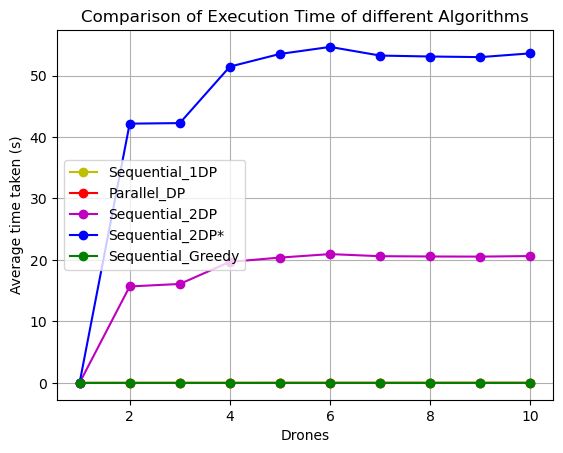

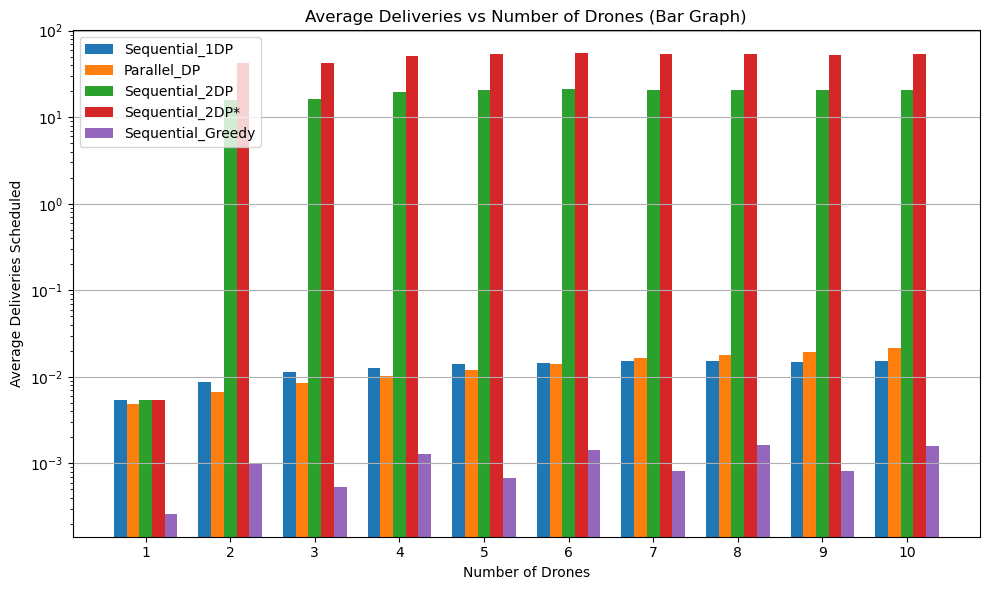

In [80]:
plt.plot(x, avg_time[0], 'yo-', label='Sequential_1DP')
plt.plot(x, avg_time[1], 'ro-', label='Parallel_DP')
plt.plot(x, avg_time[2], 'mo-', label='Sequential_2DP')
plt.plot(x, avg_time[3], 'bo-', label='Sequential_2DP*')
plt.plot(x, avg_time[4], 'go-', label='Sequential_Greedy')
plt.title("Comparison of Execution Time of different Algorithms")
plt.xlabel("Drones")
plt.ylabel("Average time taken (s)")
plt.legend()
plt.grid(True)
plt.show()

alg_labels = [
    'Sequential_1DP',
    'Parallel_DP',
    'Sequential_2DP',
    'Sequential_2DP*',
    'Sequential_Greedy'
]

x = np.arange(1, num_drones + 1)      # Drone counts
width = 0.15                          # Bar width

plt.figure(figsize=(10, 6))

for i in range(num_algs):
    plt.bar(x + (i - 2) * width, avg_time[i], width, label=alg_labels[i])

plt.xlabel("Number of Drones")
plt.ylabel("Average Deliveries Scheduled")
plt.title("Average Deliveries vs Number of Drones (Bar Graph)")
plt.xticks(x)
plt.yscale('log')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Comparison of Algorithms for Different Velocities

Range of Drone: 0.6
Total Number of points: 70
Total no. of Drones: 10
Max. Truck Distance: 2
No. of Trials: 10

Velocity of drone: 1.2

1 Drone:
Sequential_1DP:		Avg. No. of Deliveries: 7.30
Parallel_DP:		Avg. No. of Deliveries: 7.30
Sequential_2DP:		Avg. No. of Deliveries: 7.30
Sequential_2DP*:	Avg. No. of Deliveries: 7.30
Sequential_Greedy:	Avg. No. of Deliveries: 7.20

2 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 13.70
Parallel_DP:		Avg. No. of Deliveries: 12.10
Sequential_2DP:		Avg. No. of Deliveries: 13.20
Sequential_2DP*:	Avg. No. of Deliveries: 13.80
Sequential_Greedy:	Avg. No. of Deliveries: 13.60

3 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 19.80
Parallel_DP:		Avg. No. of Deliveries: 17.00
Sequential_2DP:		Avg. No. of Deliveries: 19.30
Sequential_2DP*:	Avg. No. of Deliveries: 19.90
Sequential_Greedy:	Avg. No. of Deliveries: 19.50

4 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 25.50
Parallel_DP:		Avg. No. of Deliveries: 22.30
Sequential_2DP:		Avg. No. of Deli


4 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 40.10
Parallel_DP:		Avg. No. of Deliveries: 34.80
Sequential_2DP:		Avg. No. of Deliveries: 39.80
Sequential_2DP*:	Avg. No. of Deliveries: 40.70
Sequential_Greedy:	Avg. No. of Deliveries: 39.50

5 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 48.00
Parallel_DP:		Avg. No. of Deliveries: 43.20
Sequential_2DP:		Avg. No. of Deliveries: 48.00
Sequential_2DP*:	Avg. No. of Deliveries: 48.80
Sequential_Greedy:	Avg. No. of Deliveries: 47.20

6 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 55.20
Parallel_DP:		Avg. No. of Deliveries: 52.30
Sequential_2DP:		Avg. No. of Deliveries: 54.80
Sequential_2DP*:	Avg. No. of Deliveries: 55.90
Sequential_Greedy:	Avg. No. of Deliveries: 54.20

7 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 60.80
Parallel_DP:		Avg. No. of Deliveries: 61.10
Sequential_2DP:		Avg. No. of Deliveries: 60.80
Sequential_2DP*:	Avg. No. of Deliveries: 61.50
Sequential_Greedy:	Avg. No. of Deliveries: 59.80

8 Drones:
Sequentia

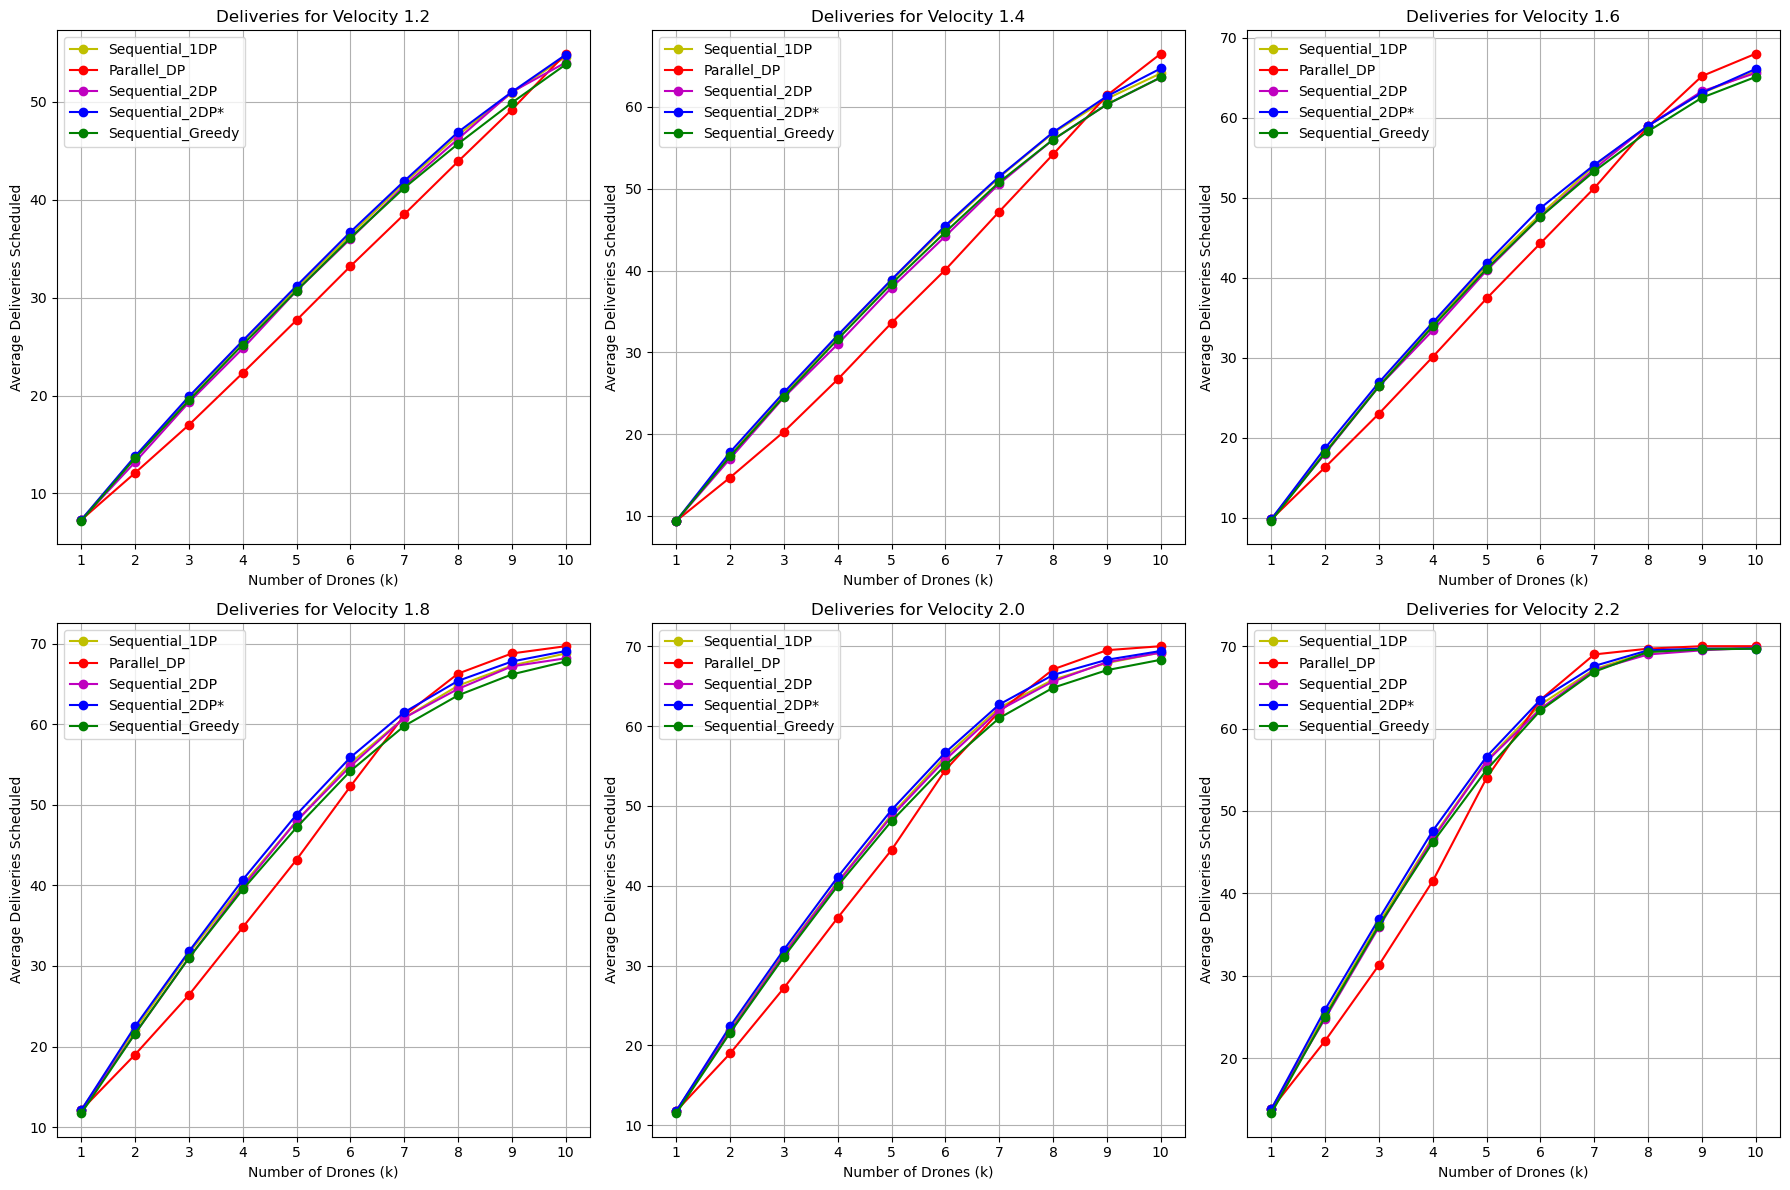

In [33]:
import matplotlib.pyplot as plt
import math

R = 0.6  
v_list = [i / 10.0 for i in range(12, 23, 2)]
num_points = 70
num_drones = 10
x_max = 2
num_trials = 10
num_algs = 5
points = [[] for _ in range(num_trials)]

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten() 

print(f"Range of Drone: {R}")
print(f"Total Number of points: {num_points}")
print(f"Total no. of Drones: {num_drones}")
print(f"Max. Truck Distance: {x_max}")
print(f"No. of Trials: {num_trials}")

for plot_idx, v in enumerate(v_list):
    avg_count = [[] for _ in range(num_algs)]
    
    for i in range(num_trials):
        points[i] = generate_proper_instance(num_points, R, v, x_max)
    
    ax = axes[plot_idx] 
    print(f"\nVelocity of drone: {v}")
    
    for k in range(1, num_drones + 1): 
        total_count = [[] for _ in range(num_algs)] 
        
        for i in range(num_trials):
            schedule = [[] for _ in range(num_algs)] 
            schedule[0] = Sequential_1DP(points[i], R, v, k, x_max)
            schedule[1] = Parallel_DP(points[i], R, v, k, x_max)
            schedule[2] = Sequential_2DP(points[i], R, v, k, x_max)
            schedule[3] = Sequential_2DP_Star(points[i], R, v, k, x_max)
            schedule[4], _, _ = Sequential_Greedy(points[i], R, v, k, x_max)

            for alg_idx in range(num_algs):
                total_count[alg_idx].append(sum(len(s) for s in schedule[alg_idx] if s))

        for alg_idx in range(num_algs):
            avg = sum(total_count[alg_idx])/len(total_count[alg_idx])
            avg_count[alg_idx].append(avg)

        print(f"\n{k} Drone{'s' if k > 1 else ''}:")
        print(f"Sequential_1DP:\t\tAvg. No. of Deliveries: {avg_count[0][-1]:.2f}")
        print(f"Parallel_DP:\t\tAvg. No. of Deliveries: {avg_count[1][-1]:.2f}")
        print(f"Sequential_2DP:\t\tAvg. No. of Deliveries: {avg_count[2][-1]:.2f}")
        print(f"Sequential_2DP*:\tAvg. No. of Deliveries: {avg_count[3][-1]:.2f}")
        print(f"Sequential_Greedy:\tAvg. No. of Deliveries: {avg_count[4][-1]:.2f}")
    
    x_plot_values = list(range(1, num_drones + 1))
    ax.plot(x_plot_values, avg_count[0], 'yo-', label='Sequential_1DP')
    ax.plot(x_plot_values, avg_count[1], 'ro-', label='Parallel_DP')
    ax.plot(x_plot_values, avg_count[2], 'mo-', label='Sequential_2DP')
    ax.plot(x_plot_values, avg_count[3], 'bo-', label='Sequential_2DP*')
    ax.plot(x_plot_values, avg_count[4], 'go-', label='Sequential_Greedy')
    ax.set_title(f"Deliveries for Velocity {v}")
    ax.set_xlabel("Number of Drones (k)")
    ax.set_ylabel("Average Deliveries Scheduled")
    ax.legend()
    ax.grid(True)
    ax.set_xticks(x_plot_values) 

for i in range(len(v_list), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Comparison of Algorithms for Different Number of Points

Range of Drone: 0.6
Velocity of drone: 1.6
Total no. of Drones: 10
Max. Truck Distance: 2
No. of Trials: 10

Number of points: 50

1 Drone:
Sequential_1DP:		Avg. No. of Deliveries: 10.50
Parallel_DP:		Avg. No. of Deliveries: 10.50
Sequential_2DP:		Avg. No. of Deliveries: 10.50
Sequential_2DP*:	Avg. No. of Deliveries: 10.50
Sequential_Greedy:	Avg. No. of Deliveries: 10.00

2 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 19.10
Parallel_DP:		Avg. No. of Deliveries: 16.60
Sequential_2DP:		Avg. No. of Deliveries: 18.60
Sequential_2DP*:	Avg. No. of Deliveries: 19.20
Sequential_Greedy:	Avg. No. of Deliveries: 18.50

3 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 27.10
Parallel_DP:		Avg. No. of Deliveries: 23.50
Sequential_2DP:		Avg. No. of Deliveries: 26.60
Sequential_2DP*:	Avg. No. of Deliveries: 27.20
Sequential_Greedy:	Avg. No. of Deliveries: 26.40

4 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 33.80
Parallel_DP:		Avg. No. of Deliveries: 31.00
Sequential_2DP:		Avg. No. of Deliv


4 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 35.80
Parallel_DP:		Avg. No. of Deliveries: 30.30
Sequential_2DP:		Avg. No. of Deliveries: 34.80
Sequential_2DP*:	Avg. No. of Deliveries: 35.90
Sequential_Greedy:	Avg. No. of Deliveries: 35.20

5 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 43.40
Parallel_DP:		Avg. No. of Deliveries: 38.50
Sequential_2DP:		Avg. No. of Deliveries: 42.90
Sequential_2DP*:	Avg. No. of Deliveries: 43.60
Sequential_Greedy:	Avg. No. of Deliveries: 42.40

6 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 50.30
Parallel_DP:		Avg. No. of Deliveries: 45.10
Sequential_2DP:		Avg. No. of Deliveries: 49.80
Sequential_2DP*:	Avg. No. of Deliveries: 50.70
Sequential_Greedy:	Avg. No. of Deliveries: 49.00

7 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 56.40
Parallel_DP:		Avg. No. of Deliveries: 52.80
Sequential_2DP:		Avg. No. of Deliveries: 56.40
Sequential_2DP*:	Avg. No. of Deliveries: 56.80
Sequential_Greedy:	Avg. No. of Deliveries: 55.10

8 Drones:
Sequentia

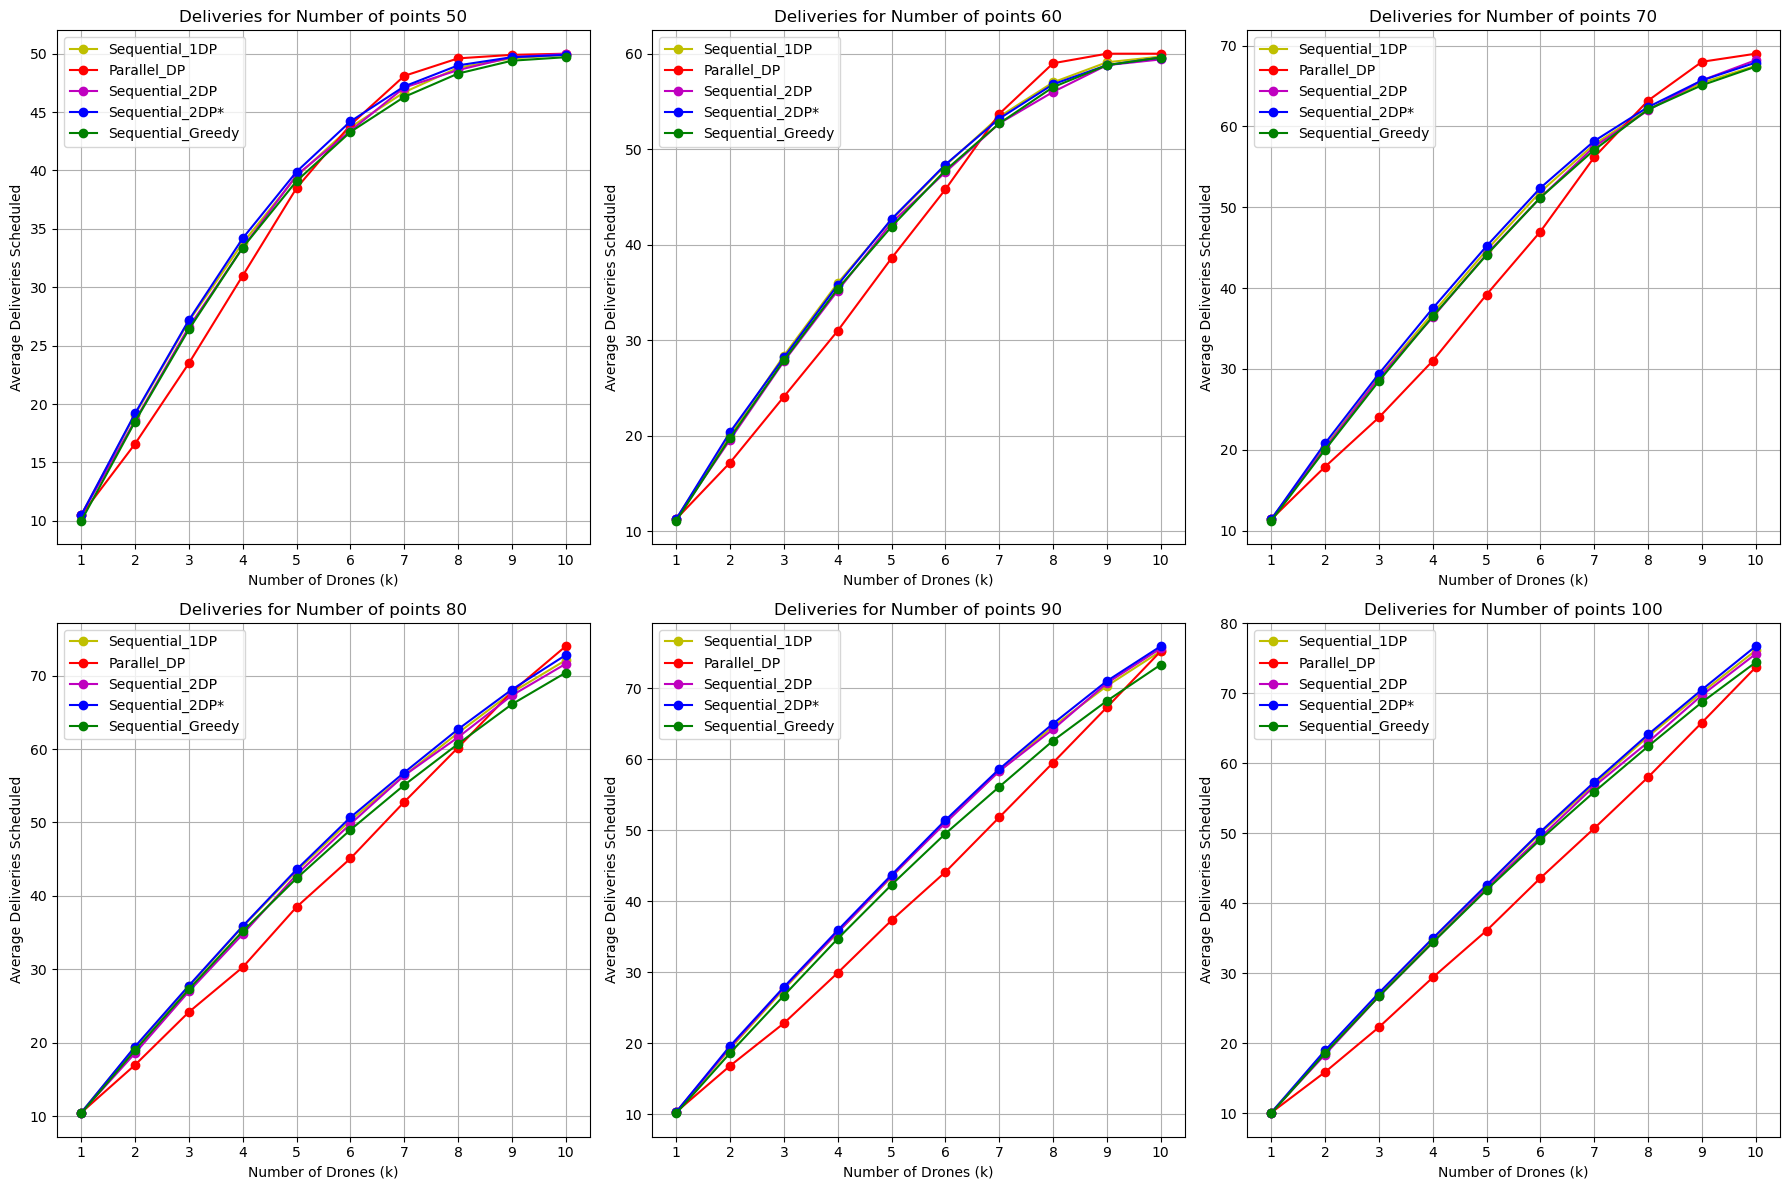

In [11]:
import matplotlib.pyplot as plt
import math

R = 0.6  
v = 1.6
num_points_list = [i for i in range(50, 101, 10)]
num_drones = 10
x_max = 2
num_trials = 10
num_algs = 5
points = [[] for _ in range(num_trials)]

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten() 

print(f"Range of Drone: {R}")
print(f"Velocity of drone: {v}")
print(f"Total no. of Drones: {num_drones}")
print(f"Max. Truck Distance: {x_max}")
print(f"No. of Trials: {num_trials}")

for plot_idx, num_points in enumerate(num_points_list):
    
    avg_count = [[] for _ in range(num_algs)]
    
    for i in range(num_trials):
        points[i] = generate_proper_instance(num_points, R, v, x_max)
    
    ax = axes[plot_idx] 
    print(f"\nNumber of points: {num_points}")
    
    for k in range(1, num_drones + 1): 
        total_count = [[] for _ in range(num_algs)] 
        
        for i in range(num_trials):
            schedule = [[] for _ in range(num_algs)] 
            schedule[0] = Sequential_1DP(points[i], R, v, k, x_max)
            schedule[1] = Parallel_DP(points[i], R, v, k, x_max)
            schedule[2] = Sequential_2DP(points[i], R, v, k, x_max)
            schedule[3] = Sequential_2DP_Star(points[i], R, v, k, x_max)
            schedule[4], _, _ = Sequential_Greedy(points[i], R, v, k, x_max)

            for alg_idx in range(num_algs):
                total_count[alg_idx].append(sum(len(s) for s in schedule[alg_idx] if s))

        for alg_idx in range(num_algs):
            avg = sum(total_count[alg_idx])/len(total_count[alg_idx])
            avg_count[alg_idx].append(avg)

        print(f"\n{k} Drone{'s' if k > 1 else ''}:")
        print(f"Sequential_1DP:\t\tAvg. No. of Deliveries: {avg_count[0][-1]:.2f}")
        print(f"Parallel_DP:\t\tAvg. No. of Deliveries: {avg_count[1][-1]:.2f}")
        print(f"Sequential_2DP:\t\tAvg. No. of Deliveries: {avg_count[2][-1]:.2f}")
        print(f"Sequential_2DP*:\tAvg. No. of Deliveries: {avg_count[3][-1]:.2f}")
        print(f"Sequential_Greedy:\tAvg. No. of Deliveries: {avg_count[4][-1]:.2f}")
    
    x_plot_values = list(range(1, num_drones + 1))
    ax.plot(x_plot_values, avg_count[0], 'yo-', label='Sequential_1DP')
    ax.plot(x_plot_values, avg_count[1], 'ro-', label='Parallel_DP')
    ax.plot(x_plot_values, avg_count[2], 'mo-', label='Sequential_2DP')
    ax.plot(x_plot_values, avg_count[3], 'bo-', label='Sequential_2DP*')
    ax.plot(x_plot_values, avg_count[4], 'go-', label='Sequential_Greedy')
    ax.set_title(f"Deliveries for Number of points {num_points}")
    ax.set_xlabel("Number of Drones (k)")
    ax.set_ylabel("Average Deliveries Scheduled")
    ax.legend()
    ax.grid(True)
    ax.set_xticks(x_plot_values) 

for i in range(len(num_points_list), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Comparison of Algorithms for Different Ranges

Velocity of drone: 1.6
Number of Points: 70
Total no. of Drones: 10
Max. Truck Distance: 2
No. of Trials: 10

Range of drone: 0.2

1 Drone:
Sequential_1DP:		Avg. No. of Deliveries: 29.90
Parallel_DP:		Avg. No. of Deliveries: 29.90
Sequential_2DP:		Avg. No. of Deliveries: 29.90
Sequential_2DP*:	Avg. No. of Deliveries: 29.90
Sequential_Greedy:	Avg. No. of Deliveries: 29.10

2 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 51.60
Parallel_DP:		Avg. No. of Deliveries: 50.00
Sequential_2DP:		Avg. No. of Deliveries: 51.80
Sequential_2DP*:	Avg. No. of Deliveries: 52.60
Sequential_Greedy:	Avg. No. of Deliveries: 50.70

3 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 65.00
Parallel_DP:		Avg. No. of Deliveries: 66.50
Sequential_2DP:		Avg. No. of Deliveries: 65.50
Sequential_2DP*:	Avg. No. of Deliveries: 65.90
Sequential_Greedy:	Avg. No. of Deliveries: 64.80

4 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 69.40
Parallel_DP:		Avg. No. of Deliveries: 69.90
Sequential_2DP:		Avg. No. of Deliv


4 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 26.90
Parallel_DP:		Avg. No. of Deliveries: 23.00
Sequential_2DP:		Avg. No. of Deliveries: 26.40
Sequential_2DP*:	Avg. No. of Deliveries: 26.90
Sequential_Greedy:	Avg. No. of Deliveries: 26.20

5 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 32.80
Parallel_DP:		Avg. No. of Deliveries: 28.30
Sequential_2DP:		Avg. No. of Deliveries: 32.40
Sequential_2DP*:	Avg. No. of Deliveries: 32.70
Sequential_Greedy:	Avg. No. of Deliveries: 32.00

6 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 38.20
Parallel_DP:		Avg. No. of Deliveries: 33.60
Sequential_2DP:		Avg. No. of Deliveries: 38.00
Sequential_2DP*:	Avg. No. of Deliveries: 38.20
Sequential_Greedy:	Avg. No. of Deliveries: 37.30

7 Drones:
Sequential_1DP:		Avg. No. of Deliveries: 43.20
Parallel_DP:		Avg. No. of Deliveries: 39.00
Sequential_2DP:		Avg. No. of Deliveries: 43.40
Sequential_2DP*:	Avg. No. of Deliveries: 43.30
Sequential_Greedy:	Avg. No. of Deliveries: 42.10

8 Drones:
Sequentia

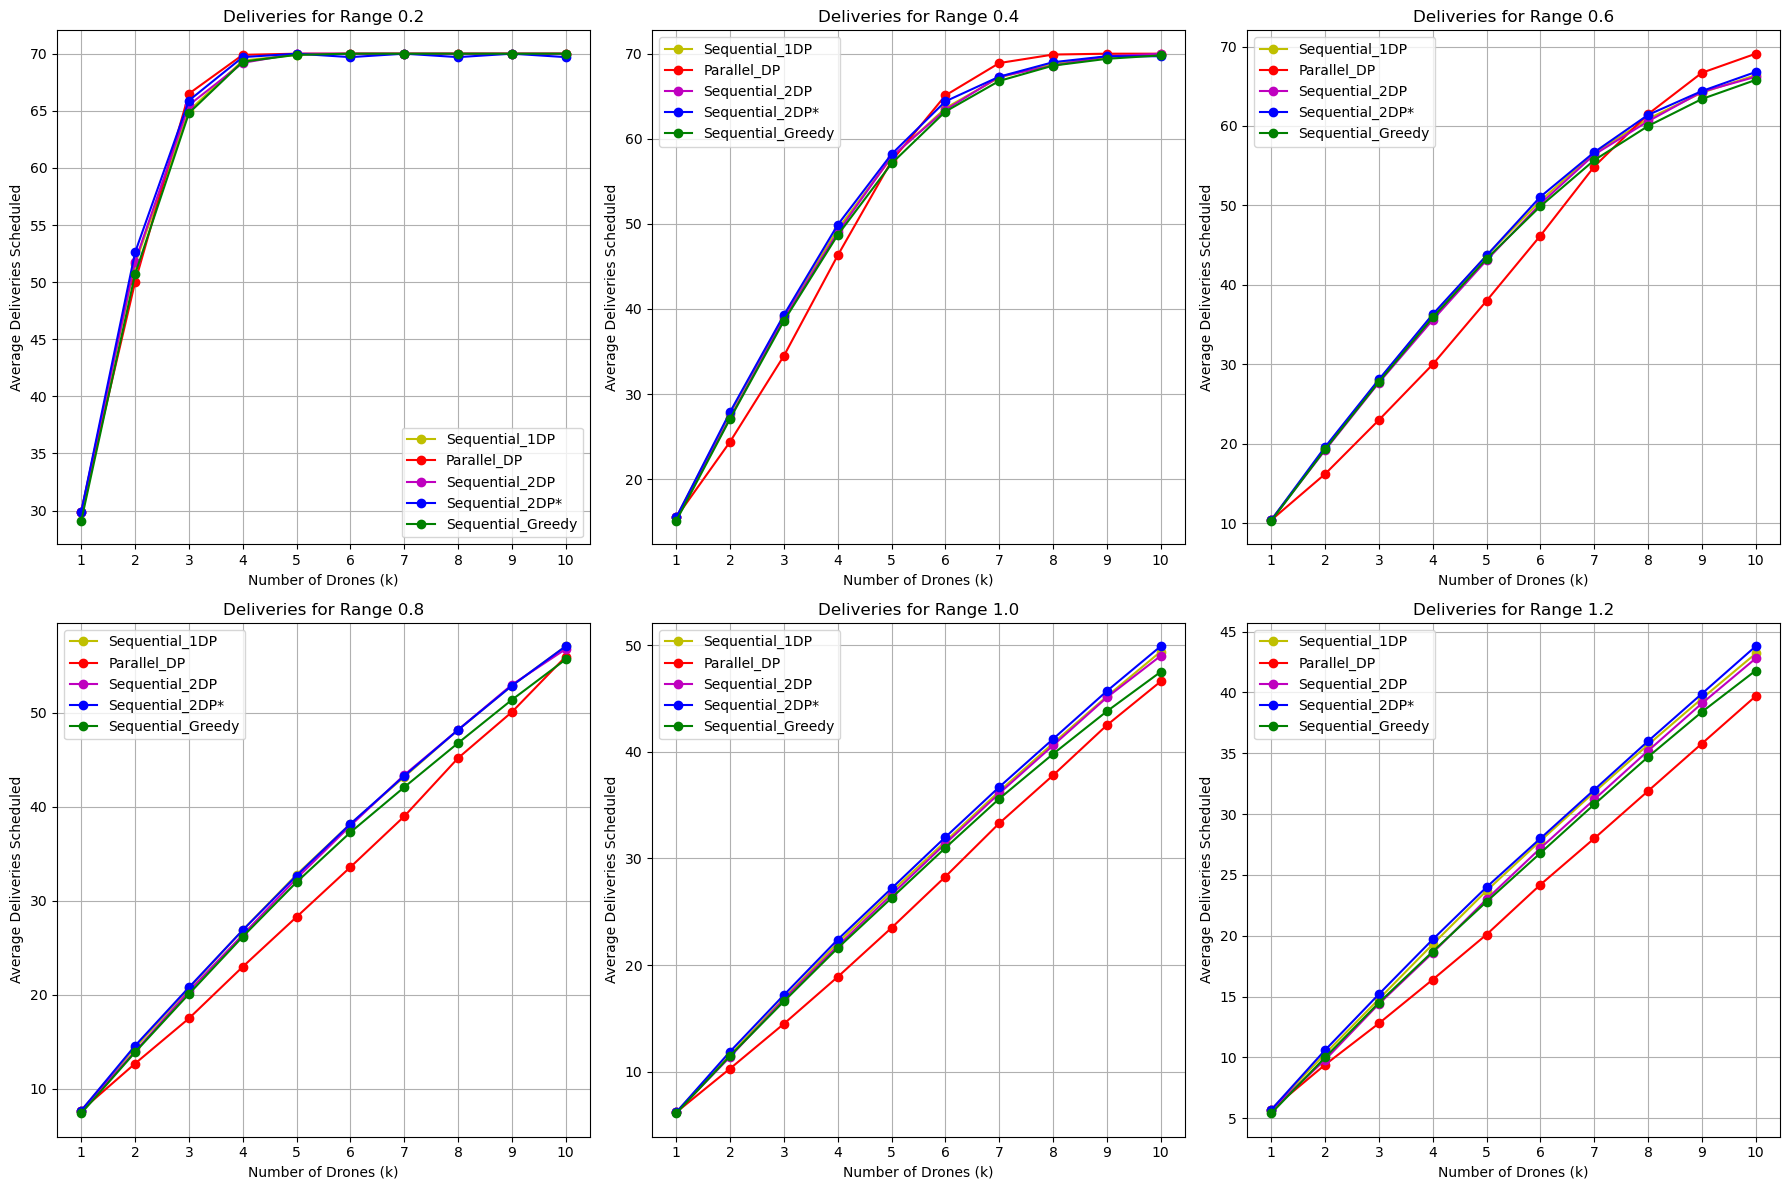

In [12]:
import matplotlib.pyplot as plt
import math

R_list = [i / 10.0 for i in range(2, 13, 2)]
v = 1.6
num_points = 70
num_drones = 10
x_max = 2
num_trials = 10
num_algs = 5
points = [[] for _ in range(num_trials)]

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten() 

print(f"Velocity of drone: {v}")
print(f"Number of Points: {num_points}")
print(f"Total no. of Drones: {num_drones}")
print(f"Max. Truck Distance: {x_max}")
print(f"No. of Trials: {num_trials}")

for plot_idx, R in enumerate(R_list):
    
    avg_count = [[] for _ in range(num_algs)]
    
    for i in range(num_trials):
        points[i] = generate_proper_instance(num_points, R, v, x_max)
    
    ax = axes[plot_idx] 
    print(f"\nRange of drone: {R}")
    
    for k in range(1, num_drones + 1): 
        total_count = [[] for _ in range(num_algs)] 
        
        for i in range(num_trials):
            schedule = [[] for _ in range(num_algs)] 
            schedule[0] = Sequential_1DP(points[i], R, v, k, x_max)
            schedule[1] = Parallel_DP(points[i], R, v, k, x_max)
            schedule[2] = Sequential_2DP(points[i], R, v, k, x_max)
            schedule[3] = Sequential_2DP_Star(points[i], R, v, k, x_max)
            schedule[4], _, _ = Sequential_Greedy(points[i], R, v, k, x_max)

            for alg_idx in range(num_algs):
                total_count[alg_idx].append(sum(len(s) for s in schedule[alg_idx] if s))

        for alg_idx in range(num_algs):
            avg = sum(total_count[alg_idx])/len(total_count[alg_idx])
            avg_count[alg_idx].append(avg)

        print(f"\n{k} Drone{'s' if k > 1 else ''}:")
        print(f"Sequential_1DP:\t\tAvg. No. of Deliveries: {avg_count[0][-1]:.2f}")
        print(f"Parallel_DP:\t\tAvg. No. of Deliveries: {avg_count[1][-1]:.2f}")
        print(f"Sequential_2DP:\t\tAvg. No. of Deliveries: {avg_count[2][-1]:.2f}")
        print(f"Sequential_2DP*:\tAvg. No. of Deliveries: {avg_count[3][-1]:.2f}")
        print(f"Sequential_Greedy:\tAvg. No. of Deliveries: {avg_count[4][-1]:.2f}")
    
    x_plot_values = list(range(1, num_drones + 1))
    ax.plot(x_plot_values, avg_count[0], 'yo-', label='Sequential_1DP')
    ax.plot(x_plot_values, avg_count[1], 'ro-', label='Parallel_DP')
    ax.plot(x_plot_values, avg_count[2], 'mo-', label='Sequential_2DP')
    ax.plot(x_plot_values, avg_count[3], 'bo-', label='Sequential_2DP*')
    ax.plot(x_plot_values, avg_count[4], 'go-', label='Sequential_Greedy')
    ax.set_title(f"Deliveries for Range {R}")
    ax.set_xlabel("Number of Drones (k)")
    ax.set_ylabel("Average Deliveries Scheduled")
    ax.legend()
    ax.grid(True)
    ax.set_xticks(x_plot_values) 

for i in range(len(R_list), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Ratio of Greedy algorithm to Optimal algorithm

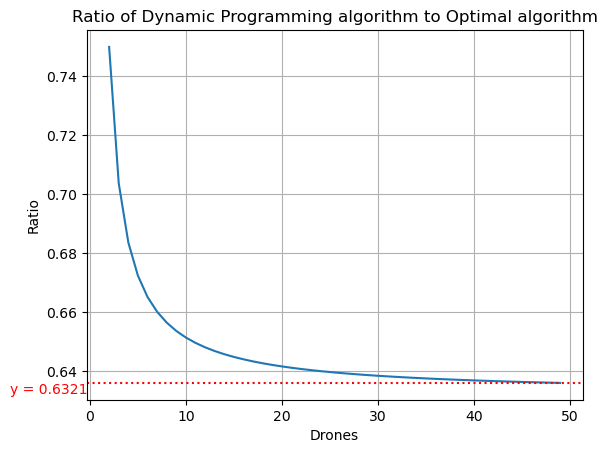

In [65]:
import numpy as np

lst = []
limit = 50

for k in range (2, limit):
    lst.append(1 - pow((1 - 1/(1*k)), k))

y_last = lst[-1]
x_l = np.linspace(0, limit, 50)
y_l = np.linspace(y_last, y_last, 50)

x = list(range(2, limit))
plt.plot(x, lst)
plt.axhline(y=y_last, color='red', linestyle=':', label='y = 0.6321')
plt.annotate('y = 0.6321', xy=(0, 0.6321), xytext=(-(limit/6), 0.6321), color='red')
plt.title("Ratio of Dynamic Programming algorithm to Optimal algorithm")
plt.xlabel("Drones")
plt.ylabel("Ratio")
plt.grid(True)
plt.show()

### Minimum drones required to deliver all packages


Number of points: 50
Sequential_1DP: 	Avg. No. of Drones: 9.30
Parallel_DP: 		Avg. No. of Drones: 8.00
Sequential_2DP: 	Avg. No. of Drones: 9.60
Sequential_2DP*: 	Avg. No. of Drones: 8.80
Sequential_Greedy: 	Avg. No. of Drones: 9.40

Number of points: 60
Sequential_1DP: 	Avg. No. of Drones: 10.40
Parallel_DP: 		Avg. No. of Drones: 8.70
Sequential_2DP: 	Avg. No. of Drones: 10.40
Sequential_2DP*: 	Avg. No. of Drones: 9.60
Sequential_Greedy: 	Avg. No. of Drones: 10.60

Number of points: 70
Sequential_1DP: 	Avg. No. of Drones: 11.80
Parallel_DP: 		Avg. No. of Drones: 10.40
Sequential_2DP: 	Avg. No. of Drones: 12.00
Sequential_2DP*: 	Avg. No. of Drones: 11.60
Sequential_Greedy: 	Avg. No. of Drones: 12.10

Number of points: 80
Sequential_1DP: 	Avg. No. of Drones: 14.00
Parallel_DP: 		Avg. No. of Drones: 12.40
Sequential_2DP: 	Avg. No. of Drones: 14.00
Sequential_2DP*: 	Avg. No. of Drones: 13.60
Sequential_Greedy: 	Avg. No. of Drones: 14.10

Number of points: 90
Sequential_1DP: 	Avg. No. of 

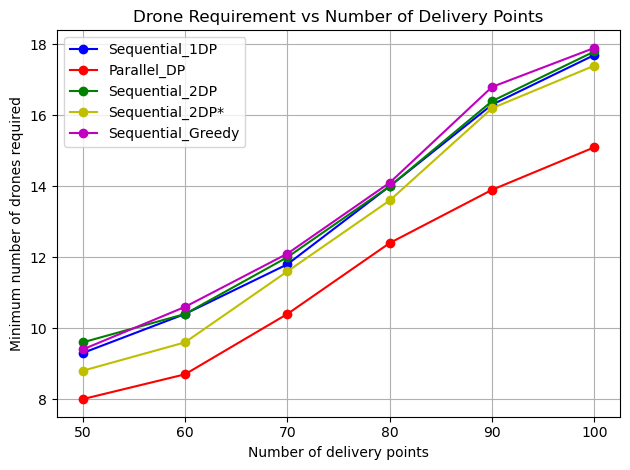

In [75]:
import math
import random
import matplotlib.pyplot as plt


R = 0.6
v = 1.6
num_points_list = [i for i in range(50, 101, 10)]
x_max = 2
num_algs = 5
num_trials = 10
avg_num_drones = [[] for _ in range(num_algs)]

def solve_with_binary_search(algorithm, deliveries, R, v, num_points, x_max):
    low = 1
    high = num_points
    min_drones = num_points

    while low <= high:
        mid = (low + high) // 2
        
        schedule = algorithm(deliveries, R, v, mid, x_max)
        L_schd = sum(len(s) for s in schedule if s)

        if L_schd >= num_points:
            min_drones = mid
            high = mid - 1
        else:
            low = mid + 1
                
    return min_drones

def calc_min_drones(algorithm, deliveries, R, v, num_points, x_max):
    if "Greedy" in algorithm.__name__: 
        schedule, _, _ = algorithm(deliveries, R, v, num_points, x_max)
    else:
        schedule = algorithm(deliveries, R, v, num_points, x_max)
    
    return sum(1 for s in schedule if s)

for num_points in num_points_list:
    num_drones = [[] for _ in range(num_algs)]
    
    for _ in range(num_trials):
        deliveries = generate_proper_instance(num_points, R, v, x_max)
        num_drones[0].append(calc_min_drones(Sequential_1DP, deliveries, R, v, num_points, x_max))
        num_drones[1].append(solve_with_binary_search(Parallel_DP, deliveries, R, v, num_points, x_max))
        num_drones[2].append(calc_min_drones(Sequential_2DP, deliveries, R, v, num_points, x_max))
        num_drones[3].append(calc_min_drones(Sequential_2DP_Star, deliveries, R, v, num_points, x_max))
        num_drones[4].append(calc_min_drones(Sequential_Greedy, deliveries, R, v, num_points, x_max))
        
    for alg_idx in range(num_algs):
        avg = sum(num_drones[alg_idx])/len(num_drones[alg_idx])
        avg_num_drones[alg_idx].append(avg)
    
    print(f"\nNumber of points: {num_points}")
    print(f"Sequential_1DP: \tAvg. No. of Drones: {avg_num_drones[0][-1]:.2f}")
    print(f"Parallel_DP: \t\tAvg. No. of Drones: {avg_num_drones[1][-1]:.2f}")
    print(f"Sequential_2DP: \tAvg. No. of Drones: {avg_num_drones[2][-1]:.2f}")
    print(f"Sequential_2DP*: \tAvg. No. of Drones: {avg_num_drones[3][-1]:.2f}")
    print(f"Sequential_Greedy: \tAvg. No. of Drones: {avg_num_drones[4][-1]:.2f}")
    
plt.plot(num_points_list, avg_num_drones[0],'bo-', label='Sequential_1DP')
plt.plot(num_points_list, avg_num_drones[1],'ro-', label='Parallel_DP')
plt.plot(num_points_list, avg_num_drones[2],'go-', label='Sequential_2DP')
plt.plot(num_points_list, avg_num_drones[3],'yo-', label='Sequential_2DP*')
plt.plot(num_points_list, avg_num_drones[4],'mo-', label='Sequential_Greedy')
plt.xlabel("Number of delivery points")
plt.ylabel("Minimum number of drones required")
plt.title("Drone Requirement vs Number of Delivery Points")

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

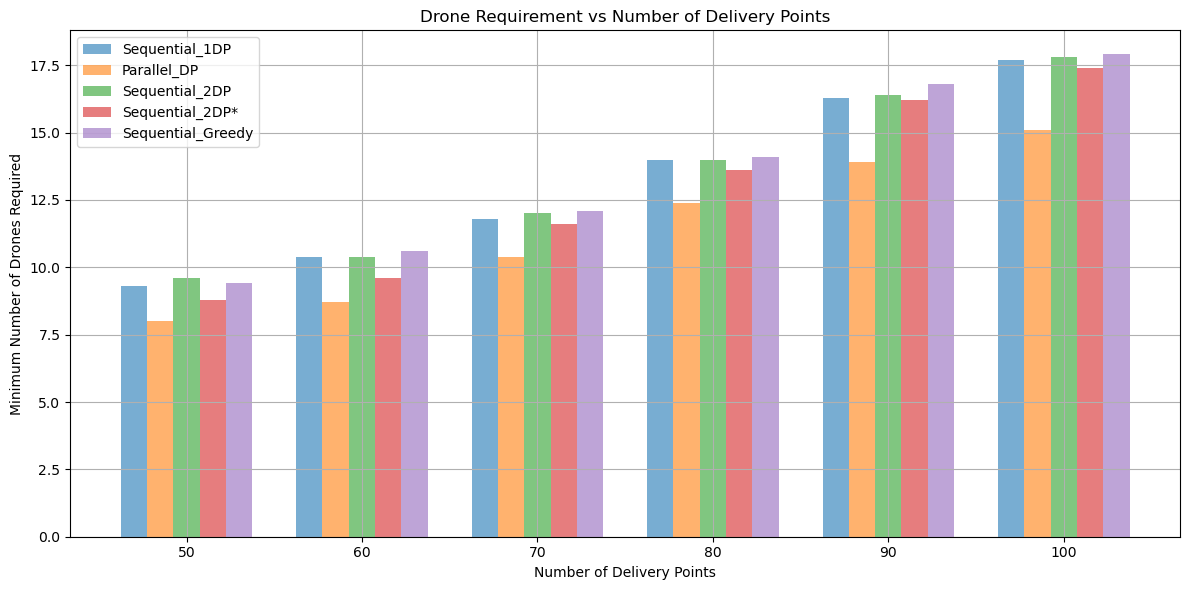

In [76]:
import numpy as np

# ---- Prepare x positions ----
x = np.arange(len(num_points_list))
width = 0.15

plt.figure(figsize=(12, 6))

plt.bar(x - 2*width, avg_num_drones[0], width, alpha=0.6, label='Sequential_1DP')
plt.bar(x - width,   avg_num_drones[1], width, alpha=0.6, label='Parallel_DP')
plt.bar(x,           avg_num_drones[2], width, alpha=0.6, label='Sequential_2DP')
plt.bar(x + width,   avg_num_drones[3], width, alpha=0.6, label='Sequential_2DP*')
plt.bar(x + 2*width, avg_num_drones[4], width, alpha=0.6, label='Sequential_Greedy')

plt.xlabel("Number of Delivery Points")
plt.ylabel("Minimum Number of Drones Required")
plt.title("Drone Requirement vs Number of Delivery Points")

plt.xticks(x, num_points_list)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<h2 style="text-align:center;">Section 3: Instance where truck can stop</h2>
<h3 style="text-align:center;">Objective: Minimize delivery time</h3>

### Algorithm1 (Naive)

In [3]:
def Alg_1(deliveries, v, x_max):
    total_Time = x_max 
    for delivery in deliveries:
        x, y = delivery
        total_Time += 2*y/v  
    
    return total_Time

### Algorithm 2 (Heuristic)

In [80]:
def calc_df(x, y):
    denom = math.sqrt(x*x + y*y)
    if denom < 1e-9:
        return math.inf
    return x / denom

def calc_Dist(d1, d2):
    x1, y1 = d1
    x2, y2 = d2
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def Alg_2(deliveries, R, v, x_Max):
    num_points = len(deliveries)
    SI = []
    incr_val = 0.001

    boundary_reached = [False for _ in range(2 * num_points)]
    ret(clear_cache=True)

    deliveries.sort(key=lambda d: d[0])

    # Initialize boundaries
    for d in deliveries:
        SI.append([d, d[0], d[0]])

    while not all(boundary_reached):
        min_df = math.inf
        min_i = None

        for i in range(num_points):
            d, s, r = SI[i]

            if not boundary_reached[2*i]:
                df = calc_df(d[0] - s, d[1])
                if df < min_df:
                    min_df = df
                    min_i = 2*i

            if not boundary_reached[2*i + 1]:
                df = calc_df(r - d[0], d[1])
                if df < min_df:
                    min_df = df
                    min_i = 2*i + 1

        if min_i is None:
            break

        i = min_i // 2
        d, s, r = SI[i]

        if r >= ret(s, v, d):
            boundary_reached[min_i] = True
            continue

        # Neighbor safety
        if i == 0:
            r_prev = 0
        else:
            r_prev = SI[i-1][2]

        if i == num_points - 1:
            s_nxt = x_Max
        else:
            s_nxt = SI[i+1][1]

        if min_i % 2 == 0:  # move s left
            t1 = (calc_Dist((s - incr_val, 0), d) + calc_Dist(d, (r, 0))) / v
            t2 = r - s + incr_val
            if s - incr_val < r_prev or t1 < t2: 
                boundary_reached[min_i] = True
            else:
                s -= incr_val
        else:  # move r right
            t1 = (calc_Dist((s, 0), d) + calc_Dist(d, (r + incr_val, 0))) / v
            t2 = r - s + incr_val
            if r + incr_val > s_nxt or t1 < t2:
                boundary_reached[min_i] = True
            else:
                r += incr_val

        SI[i][1] = s
        SI[i][2] = r
    
    total_Time = 0
    r_prev = 0
    for i in range(num_points):
        d, s, r = SI[i]

        total_Time += (s - r_prev)
        total_Time += (calc_Dist((s, 0), d) + calc_Dist(d, (r, 0))) / v

        r_prev = r
        
        
    if r_prev < x_Max:
        total_Time += x_Max - r_prev

    return SI, total_Time


### Example for Algorithm 2

Total time taken using Algorithm 1 (Naive): 3.54
Total time taken using Algorithm 2 (Heuristic): 2.42


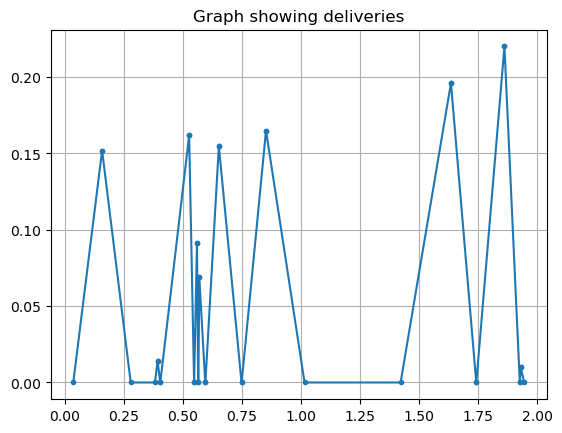

In [81]:
import matplotlib.pyplot as plt

R = 0.6  
v = 1.6
x_max = 2
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
num_points = 10

deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
deliveries.sort(key = lambda x:x[0])

alg1_tot_time = Alg_1(deliveries, v, x_max)
schedule, alg2_tot_time = Alg_2(deliveries, R, v, x_max)

print(f"Total time taken using Algorithm 1 (Naive): {alg1_tot_time:.2f}")        
print(f"Total time taken using Algorithm 2 (Heuristic): {alg2_tot_time:.2f}") 

L = []
for i, delivery in enumerate(schedule, start = 1):
    d, s, r = delivery
    L.extend([(s,0), (d), (r, 0)])

x, y = zip(*L)
plt.plot(x, y, marker='.') 
p, q = zip(*deliveries)
plt.scatter(p, q, marker='.') 
plt.title('Graph showing deliveries')
plt.grid(True)
plt.show()

### Algorithm 3 (Dynamic Programming)

In [38]:
import math

def Alg_3(deliveries, R, v, x_max, incr_val=0.01, truck_speed=1.0):

    eps = 1e-9
    N = len(deliveries)
    M = int(round(x_max / incr_val)) + 1
    INF = math.inf

    def idx_to_x(i): return i * incr_val

    # Precompute feasible return positions for each delivery from each truck launch
    feasible_returns = [[[] for _ in range(M)] for _ in range(N)]
    drone_time_cache = [[{} for _ in range(M)] for _ in range(N)]

    for j, (x2, y2) in enumerate(deliveries):
        for s_idx in range(M):
            sx = idx_to_x(s_idx)
            for rt_idx in range(s_idx, M):
                rt_x = idx_to_x(rt_idx)
                d1 = math.hypot(sx - x2, y2)
                d2 = math.hypot(rt_x - x2, y2)
                if d1 + d2 <= R + eps:
                    feasible_returns[j][s_idx].append(rt_idx)
                    drone_time_cache[j][s_idx][rt_idx] = (d1 + d2)/v

    # DP arrays
    dp = [[INF]*M for _ in range(N)]
    choice_launch = [[-1]*M for _ in range(N)]
    choice_return = [[-1]*M for _ in range(N)]

    # Base case: last delivery
    j = N-1
    for s_idx in range(M):
        sx = idx_to_x(s_idx)
        for sprime_idx in range(s_idx, M):
            s_prime = idx_to_x(sprime_idx)
            drive1 = (s_prime - sx)/truck_speed
            for rt_idx in feasible_returns[j][sprime_idx]:
                rt_x = idx_to_x(rt_idx)
                t_dr = drone_time_cache[j][sprime_idx][rt_idx]
                t_tr = (rt_x - s_prime)/truck_speed
                if t_dr < t_tr:
                    continue
                total = drive1 + t_dr + (x_max - rt_x)/truck_speed
                if total < dp[j][s_idx]:
                    dp[j][s_idx] = total
                    choice_launch[j][s_idx] = sprime_idx
                    choice_return[j][s_idx] = rt_idx

    # Main DP
    for j in range(N-2, -1, -1):
        for s_idx in range(M):
            sx = idx_to_x(s_idx)
            best = INF
            best_sp = -1
            best_rt = -1
            for sprime_idx in range(s_idx, M):
                s_prime = idx_to_x(sprime_idx)
                drive1 = (s_prime - sx)/truck_speed
                for rt_idx in feasible_returns[j][sprime_idx]:
                    t_dr = drone_time_cache[j][sprime_idx][rt_idx]
                    t_tr = (idx_to_x(rt_idx) - s_prime)/truck_speed
                    if t_dr < t_tr:
                        continue
                    next_val = dp[j+1][rt_idx]
                    if next_val == INF:
                        continue
                    total = drive1 + t_dr + next_val
                    if total < best:
                        best = total
                        best_sp = sprime_idx
                        best_rt = rt_idx
            dp[j][s_idx] = best
            choice_launch[j][s_idx] = best_sp
            choice_return[j][s_idx] = best_rt

    # Reconstruct schedule
    total_time = dp[0][0]
    if total_time == INF:
        return [], INF
    schedule = []
    cur = 0
    for j in range(N):
        sp = choice_launch[j][cur]
        rt = choice_return[j][cur]
        schedule.append((round(idx_to_x(sp),6), round(idx_to_x(rt),6)))
        cur = rt
    return schedule, total_time


### Example for Algorithm 3

Total time taken using Algorithm 1 (Naive): 2.08
Total time taken using Algorithm 3 (Dynamic Programming): 2.00


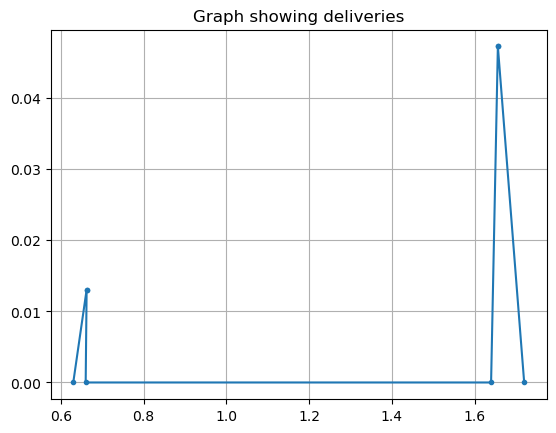

In [39]:
import matplotlib.pyplot as plt
import random

R = 0.6  
v = 1.6
x_max = 2
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
num_points = 2

deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
deliveries.sort(key = lambda x:x[0])

alg1_tot_time = Alg_1(deliveries, v, x_max)
schedule, alg3_tot_time = Alg_3(deliveries, R, v, x_max)

print(f"Total time taken using Algorithm 1 (Naive): {alg1_tot_time:.2f}")        
print(f"Total time taken using Algorithm 3 (Dynamic Programming): {alg3_tot_time:.2f}") 

L = []
for i, delivery in enumerate(schedule, start = 1):
    s, r = delivery
    L.extend([(s,0), deliveries[i-1], (r, 0)])

x, y = zip(*L)
plt.plot(x, y, marker='.') 
p, q = zip(*deliveries)
plt.scatter(p, q, marker='.') 
plt.title('Graph showing deliveries')
plt.grid(True)
plt.show()

### Algorithm 4 (Dijkstra's Algorithm)

In [40]:
import math
import heapq

def Alg_4(deliveries, R, v, x_max, incr_val=0.01, truck_speed=1.0):
    eps = 1e-9
    N = len(deliveries)
    if N == 0:
        return [], 0.0

    M = int(round(x_max / incr_val)) + 1
    INF = math.inf

    def idx_to_x(i): 
        return i * incr_val

    # --- Precompute feasible returns and drone times ---
    feasible_returns = [[[] for _ in range(M)] for _ in range(N)]
    drone_time_cache = [[{} for _ in range(M)] for _ in range(N)]

    for j, (x2, y2) in enumerate(deliveries):
        for s_idx in range(M):
            sx = idx_to_x(s_idx)
            for rt_idx in range(s_idx, M):
                rt_x = idx_to_x(rt_idx)
                d1 = math.hypot(sx - x2, y2)
                d2 = math.hypot(rt_x - x2, y2)
                if d1 + d2 <= R + eps:
                    feasible_returns[j][s_idx].append(rt_idx)
                    drone_time_cache[j][s_idx][rt_idx] = (d1 + d2) / v

    # --- Dijkstra over (mask, cur_idx) ---
    full = (1 << N) - 1

    # dist[mask][cur_idx] is too big to allocate densely; use dict-of-dicts.
    dist = {}  # (mask, cur_idx) -> best time so far
    parent = {}  # (mask, cur_idx) -> (prev_mask, prev_idx, chosen_j, launch_idx, return_idx)

    start = (0, 0)
    dist[start] = 0.0
    pq = [(0.0, 0, 0)]  # (time, mask, cur_idx)

    while pq:
        t, mask, cur_idx = heapq.heappop(pq)
        state = (mask, cur_idx)
        if t != dist.get(state, INF):
            continue

        # If all served, we can stop early: Dijkstra guarantees optimality.
        if mask == full:
            break

        cur_x = idx_to_x(cur_idx)

        # Choose next unserved delivery j
        for j in range(N):
            if (mask >> j) & 1:
                continue

            # Choose launch sprime_idx >= cur_idx
            # (This is the heavy part. For speed, you can prune or cache per (j, cur_idx).)
            for sprime_idx in range(cur_idx, M):
                s_prime = idx_to_x(sprime_idx)
                drive1 = (s_prime - cur_x) / truck_speed

                # Choose feasible return positions for this delivery given this launch
                fr = feasible_returns[j][sprime_idx]
                if not fr:
                    continue

                for rt_idx in fr:
                    rt_x = idx_to_x(rt_idx)
                    t_dr = drone_time_cache[j][sprime_idx][rt_idx]
                    t_tr = (rt_x - s_prime) / truck_speed

                    if t_dr < t_tr:
                        continue
                        
                    step = drive1 + max(t_dr, t_tr)
                    nmask = mask | (1 << j)
                    nstate = (nmask, rt_idx)
                    nt = t + step

                    if nt + 1e-12 < dist.get(nstate, INF):
                        dist[nstate] = nt
                        parent[nstate] = (mask, cur_idx, j, sprime_idx, rt_idx)
                        heapq.heappush(pq, (nt, nmask, rt_idx))

    # --- Pick best terminal among (full, cur_idx) + final drive to x_max ---
    best_total = INF
    best_end = None
    for cur_idx in range(M):
        base = dist.get((full, cur_idx), INF)
        if base == INF:
            continue
        tail = (x_max - idx_to_x(cur_idx)) / truck_speed
        total = base + tail
        if total < best_total:
            best_total = total
            best_end = (full, cur_idx)

    if best_end is None:
        return [], INF

    # --- Reconstruct schedule ---
    # We reconstruct *in the order the algorithm chose*, which is now optimal.
    schedule_rev = []
    st = best_end
    while st != start:
        pmask, pidx, j, launch_idx, ret_idx = parent[st]
        schedule_rev.append((j,
                             round(idx_to_x(launch_idx), 6),
                             round(idx_to_x(ret_idx), 6)))
        st = (pmask, pidx)

    schedule = list(reversed(schedule_rev))
    return schedule, best_total


### Example for Algorithm 4

Total time taken using Algorithm 1 (Naive): 3.62
Total time taken using Algorithm 4 (Dijkstra's): 2.30


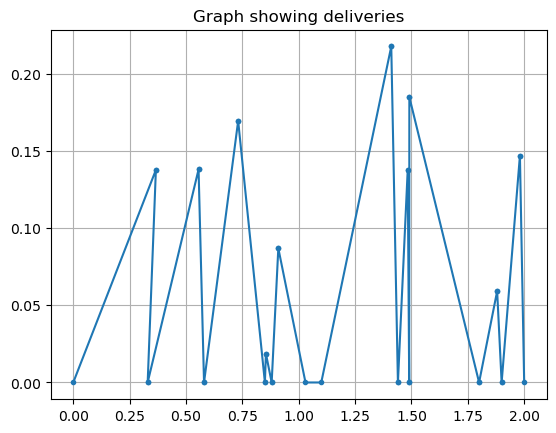

In [46]:
import matplotlib.pyplot as plt
import random
import math

R = 0.6  
v = 1.6
x_max = 2
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
num_points = 10

deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
deliveries.sort(key = lambda x:x[0])

alg1_tot_time = Alg_1(deliveries, v, x_max)
schedule, alg4_tot_time = Alg_4(deliveries, R, v, x_max)

print(f"Total time taken using Algorithm 1 (Naive): {alg1_tot_time:.2f}")        
print(f"Total time taken using Algorithm 4 (Dijkstra's): {alg4_tot_time:.2f}") 

L = []
for delivery in schedule:
    j, s, r = delivery
    L.extend([(s,0), deliveries[j], (r, 0)])

x, y = zip(*L)
plt.plot(x, y, marker='.') 
p, q = zip(*deliveries)
plt.scatter(p, q, marker='.') 
plt.title('Graph showing deliveries')
plt.grid(True)
plt.show()

### Comparison of all algorithms for different no. of points

Range of Drone: 0.6
Velocity of Drone: 1.6
No. of Trials: 10
Max. Truck Distance: 2

Total Number of points: 20
Alg_1: 5.02s, 	exec_time: 0.0000s
Alg_2: 3.58s, 	exec_time: 0.0076s
Alg_3: 3.52s, 	exec_time: 0.4535s

Total Number of points: 40
Alg_1: 7.93s, 	exec_time: 0.0000s
Alg_2: 6.22s, 	exec_time: 0.0134s
Alg_3: 6.20s, 	exec_time: 0.9107s

Total Number of points: 60
Alg_1: 10.63s, 	exec_time: 0.0000s
Alg_2: 8.87s, 	exec_time: 0.0186s
Alg_3: 8.84s, 	exec_time: 1.3143s

Total Number of points: 80
Alg_1: 14.05s, 	exec_time: 0.0000s
Alg_2: 12.24s, 	exec_time: 0.0249s
Alg_3: 12.21s, 	exec_time: 1.7688s

Total Number of points: 100
Alg_1: 16.59s, 	exec_time: 0.0000s
Alg_2: 14.77s, 	exec_time: 0.0305s
Alg_3: 14.74s, 	exec_time: 2.1411s

Total Number of points: 120
Alg_1: 19.60s, 	exec_time: 0.0000s
Alg_2: 17.76s, 	exec_time: 0.0385s
Alg_3: 17.72s, 	exec_time: 2.8131s

Total Number of points: 140
Alg_1: 22.74s, 	exec_time: 0.0000s
Alg_2: 20.91s, 	exec_time: 0.0436s
Alg_3: 20.86s, 	exec_time

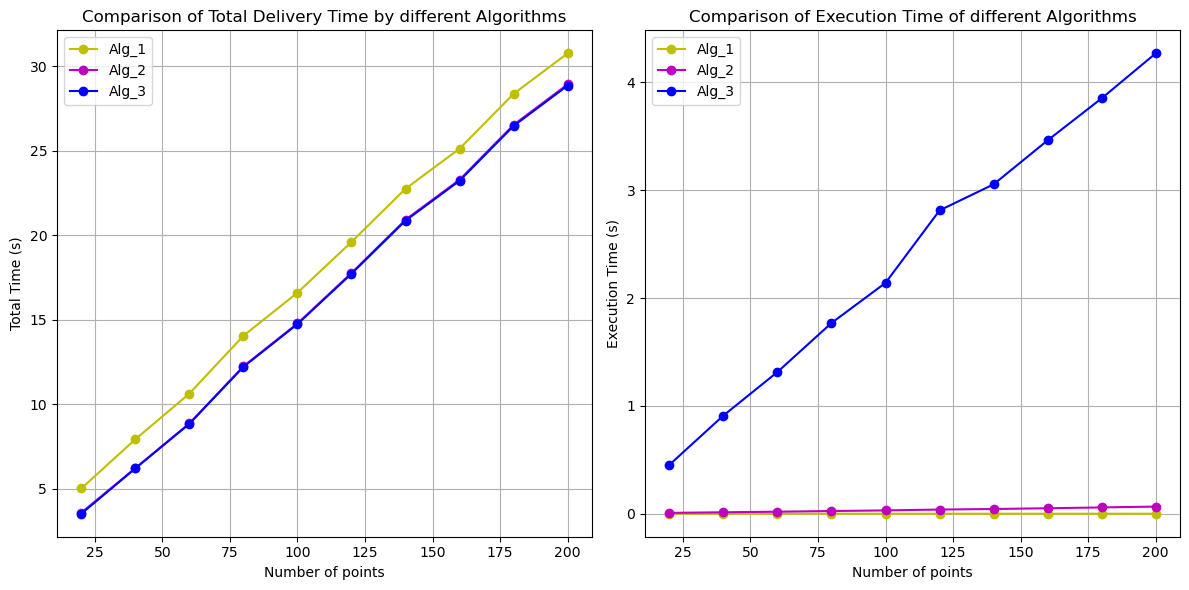

In [53]:
import time

R = 0.6  
v = 1.6
x_max = 2
num_trials = 10
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
points_list = [i for i in range(20, 201, 20)]
num_algs = 3
avg_alg_time = [[] for _ in range(num_algs)]
avg_exec_time = [[] for _ in range (num_algs)]

print(f"Range of Drone: {R}")
print(f"Velocity of Drone: {v}")
print(f"No. of Trials: {num_trials}")
print(f"Max. Truck Distance: {x_max}")

for num_points in points_list:
    alg_time = [[] for _ in range(num_algs)]
    exec_time = [[] for _ in range (num_algs)]

    for _ in range (num_trials):
        alg_time1 = [0 for _ in range(num_algs)]
        exec_time1 = [0 for _ in range (num_algs)]
       
        deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
        deliveries.sort(key = lambda x:x[0])

        start_time = time.time()
        alg_time1[0] = Alg_1(deliveries, v, x_max)
        end_time = time.time()
        exec_time1[0] = (end_time - start_time)

        start_time = time.time()
        _, alg_time1[1] = Alg_2(deliveries, R, v, x_max)
        end_time = time.time()
        exec_time1[1] = (end_time - start_time)

        start_time = time.time()
        _, alg_time1[2] = Alg_3(deliveries, R, v, x_max)
        end_time = time.time()
        exec_time1[2] = (end_time - start_time)
            
        for i in range(num_algs):
            exec_time[i].append(exec_time1[i])
            alg_time[i].append(alg_time1[i])
    
    for i in range(num_algs):
        avg_alg_time[i].append(sum(alg_time[i])/len(alg_time[i]))
        avg_exec_time[i].append(calculate_mean_IQR(exec_time[i]))
        
    print(f"\nTotal Number of points: {num_points}")
    print(f"Alg_1: {avg_alg_time[0][-1]:.2f}s, \texec_time: {avg_exec_time[0][-1]:.4f}s")
    print(f"Alg_2: {avg_alg_time[1][-1]:.2f}s, \texec_time: {avg_exec_time[1][-1]:.4f}s")
    print(f"Alg_3: {avg_alg_time[2][-1]:.2f}s, \texec_time: {avg_exec_time[2][-1]:.4f}s")
    

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(points_list, avg_alg_time[0],'yo-', label='Alg_1')
plt.plot(points_list, avg_alg_time[1],'mo-', label='Alg_2')
plt.plot(points_list, avg_alg_time[2],'bo-', label='Alg_3')
plt.title("Comparison of Total Delivery Time by different Algorithms")
plt.xlabel("Number of points")
plt.ylabel("Total Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(points_list, avg_exec_time[0], 'yo-', label='Alg_1')
plt.plot(points_list, avg_exec_time[1], 'mo-', label='Alg_2')
plt.plot(points_list, avg_exec_time[2], 'bo-', label='Alg_3')
plt.title("Comparison of Execution Time of different Algorithms")
plt.xlabel("Number of points")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()

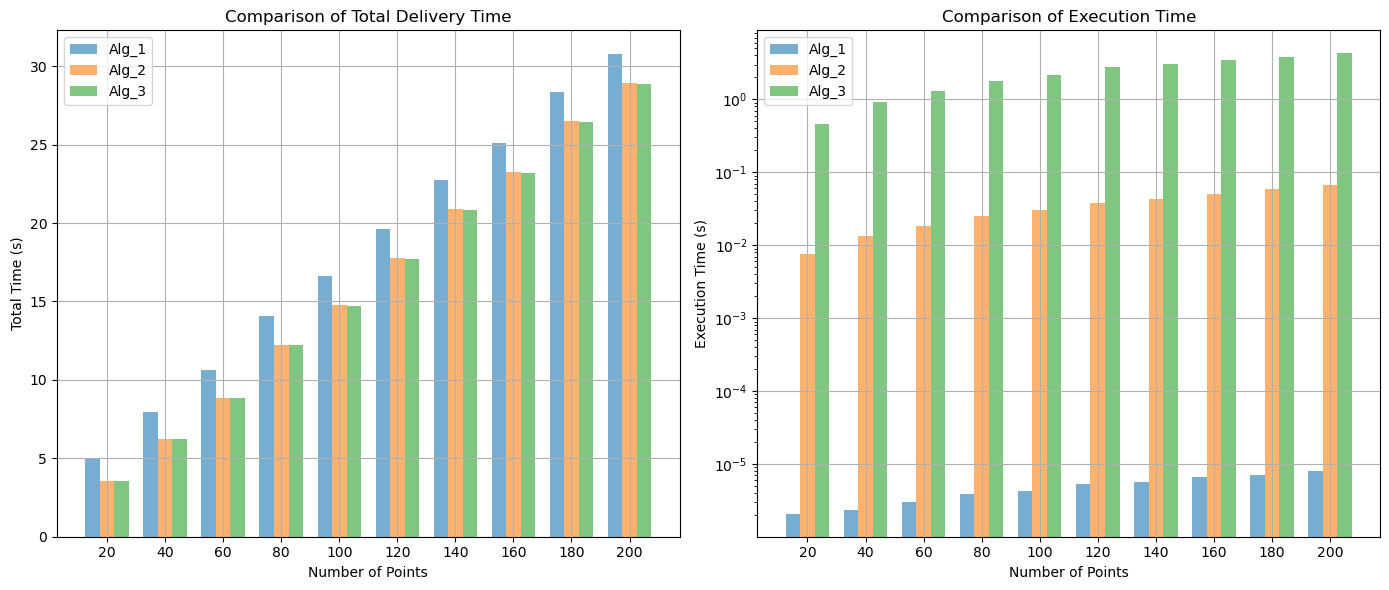

In [54]:
import numpy as np

x = np.arange(len(points_list))   # index positions
width = 0.25                      # bar width

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

# Bars
plt.bar(x - width, avg_alg_time[0], width, alpha=0.6, label='Alg_1')
plt.bar(x,         avg_alg_time[1], width, alpha=0.6, label='Alg_2')
plt.bar(x + width, avg_alg_time[2], width, alpha=0.6, label='Alg_3')

plt.title("Comparison of Total Delivery Time")
plt.xlabel("Number of Points")
plt.ylabel("Total Time (s)")
plt.xticks(x, points_list)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)

# Bars
plt.bar(x - width, avg_exec_time[0], width, alpha=0.6, label='Alg_1')
plt.bar(x,         avg_exec_time[1], width, alpha=0.6, label='Alg_2')
plt.bar(x + width, avg_exec_time[2], width, alpha=0.6, label='Alg_3')

plt.title("Comparison of Execution Time")
plt.xlabel("Number of Points")
plt.ylabel("Execution Time (s)")
plt.xticks(x, points_list)
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Comparison of all algorithms for different velocities

Range of Drone: 0.6
Number of points: 100
No. of Trials: 10
Max. Truck Distance: 2

Velocity: 1.2
Alg_1: 15.99s, 	exec_time: 0.0000s
Alg_2: 14.28s, 	exec_time: 0.0310s
Alg_3: 14.25s, 	exec_time: 2.5031s

Velocity: 1.4
Alg_1: 17.12s, 	exec_time: 0.0000s
Alg_2: 15.33s, 	exec_time: 0.0308s
Alg_3: 15.30s, 	exec_time: 2.2884s

Velocity: 1.6
Alg_1: 16.47s, 	exec_time: 0.0000s
Alg_2: 14.66s, 	exec_time: 0.0315s
Alg_3: 14.62s, 	exec_time: 2.1965s

Velocity: 1.8
Alg_1: 15.60s, 	exec_time: 0.0000s
Alg_2: 13.76s, 	exec_time: 0.0319s
Alg_3: 13.72s, 	exec_time: 2.1458s

Velocity: 2.0
Alg_1: 15.09s, 	exec_time: 0.0000s
Alg_2: 13.24s, 	exec_time: 0.0316s
Alg_3: 13.20s, 	exec_time: 1.9844s

Velocity: 2.2
Alg_1: 14.22s, 	exec_time: 0.0000s
Alg_2: 12.36s, 	exec_time: 0.0306s
Alg_3: 12.31s, 	exec_time: 1.8997s

Velocity: 2.4
Alg_1: 13.06s, 	exec_time: 0.0000s
Alg_2: 11.19s, 	exec_time: 0.0308s
Alg_3: 11.14s, 	exec_time: 1.9444s

Velocity: 2.6
Alg_1: 12.57s, 	exec_time: 0.0000s
Alg_2: 10.69s, 	exec_time: 

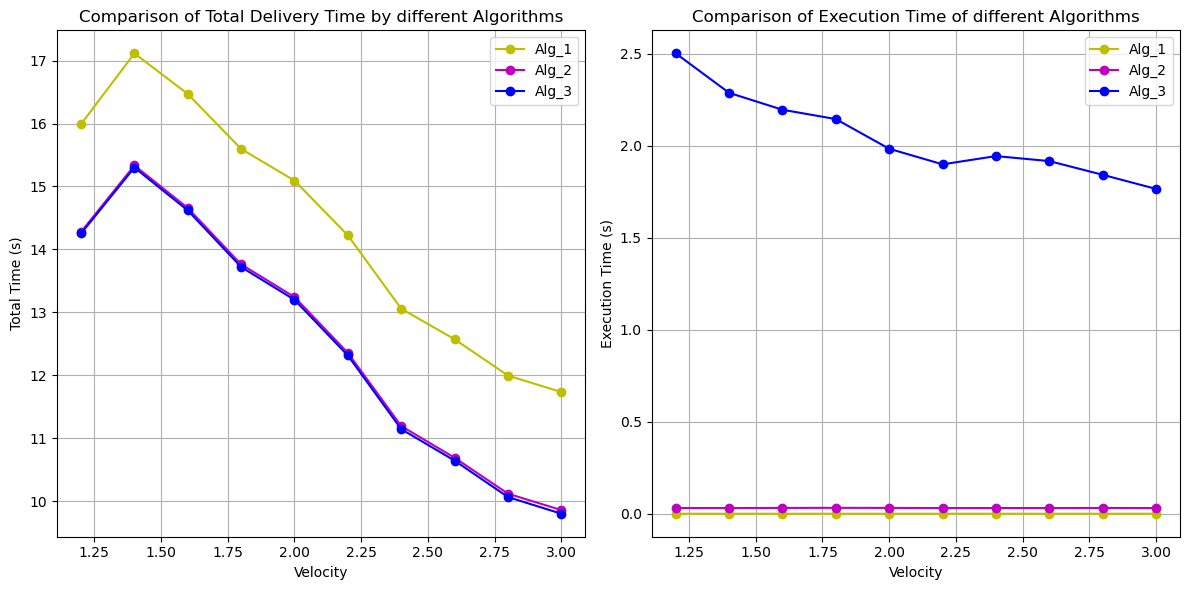

In [55]:
R = 0.6  
v = 1.6
x_max = 2
num_trials = 10
velocity_list = [i / 10.0 for i in range(12, 32, 2)]
num_algs = 3
avg_alg_time = [[] for _ in range(num_algs)]
avg_exec_time = [[] for _ in range (num_algs)]
num_points = 100

print(f"Range of Drone: {R}")
print(f"Number of points: {num_points}")
print(f"No. of Trials: {num_trials}")
print(f"Max. Truck Distance: {x_max}")

for v in velocity_list:
    alg_time = [[] for _ in range(num_algs)]
    exec_time = [[] for _ in range (num_algs)]
    m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
    
    for _ in range (num_trials):
        alg_time1 = [0 for _ in range(num_algs)]
        exec_time1 = [0 for _ in range (num_algs)]
        
        deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
        deliveries.sort(key = lambda x:x[0])

        start_time = time.time()
        alg_time1[0] = Alg_1(deliveries, v, x_max)
        end_time = time.time()
        exec_time1[0] = (end_time - start_time)

        start_time = time.time()
        _, alg_time1[1] = Alg_2(deliveries, R, v, x_max)
        end_time = time.time()
        exec_time1[1] = (end_time - start_time)

        start_time = time.time()
        _, alg_time1[2] = Alg_3(deliveries, R, v, x_max)
        end_time = time.time()
        exec_time1[2] = (end_time - start_time)
            
        for i in range(num_algs):    
            exec_time[i].append(exec_time1[i])
            alg_time[i].append(alg_time1[i])
    
    for i in range(num_algs):
        avg_alg_time[i].append(sum(alg_time[i])/len(alg_time[i]))
        avg_exec_time[i].append(calculate_mean_IQR(exec_time[i]))
        
    print(f"\nVelocity: {v}")
    print(f"Alg_1: {avg_alg_time[0][-1]:.2f}s, \texec_time: {avg_exec_time[0][-1]:.4f}s")
    print(f"Alg_2: {avg_alg_time[1][-1]:.2f}s, \texec_time: {avg_exec_time[1][-1]:.4f}s")
    print(f"Alg_3: {avg_alg_time[2][-1]:.2f}s, \texec_time: {avg_exec_time[2][-1]:.4f}s")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(velocity_list, avg_alg_time[0],'yo-', label='Alg_1')
plt.plot(velocity_list, avg_alg_time[1],'mo-', label='Alg_2')
plt.plot(velocity_list, avg_alg_time[2],'bo-', label='Alg_3')
plt.title("Comparison of Total Delivery Time by different Algorithms")
plt.xlabel("Velocity")
plt.ylabel("Total Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(velocity_list, avg_exec_time[0], 'yo-', label='Alg_1')
plt.plot(velocity_list, avg_exec_time[1], 'mo-', label='Alg_2')
plt.plot(velocity_list, avg_exec_time[2], 'bo-', label='Alg_3')
plt.title("Comparison of Execution Time of different Algorithms")
plt.xlabel("Velocity")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()

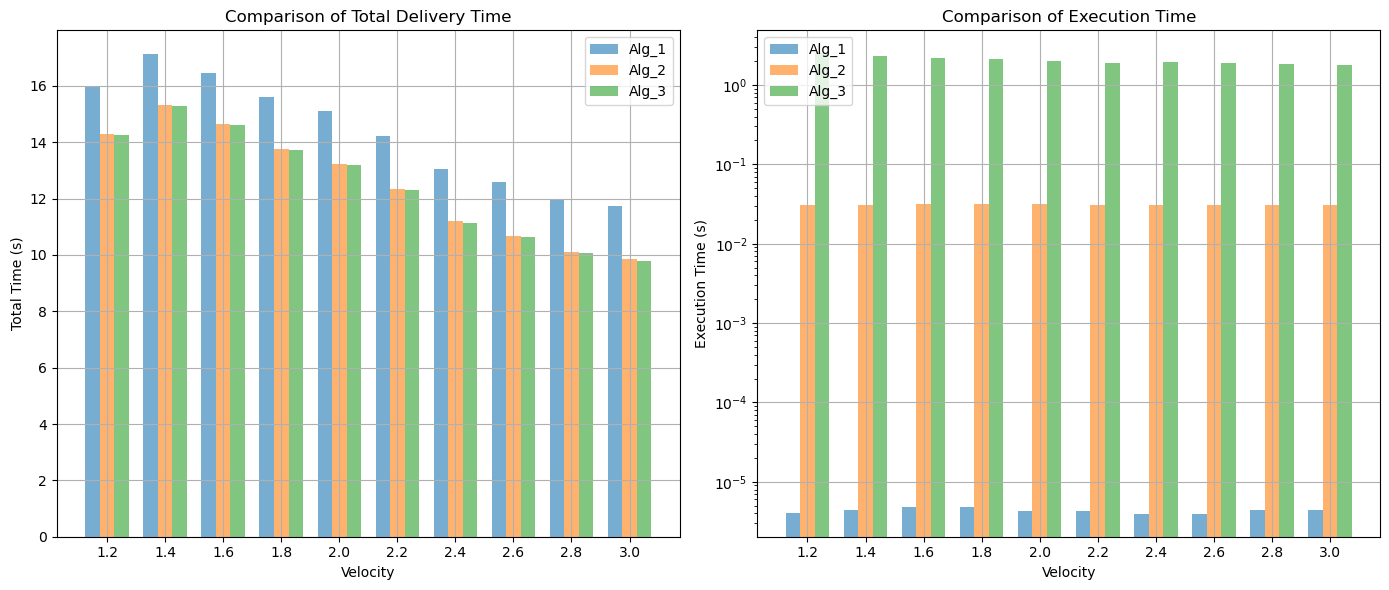

In [56]:
import numpy as np

x = np.arange(len(velocity_list))   # index positions
width = 0.25                      # bar width

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

# Bars
plt.bar(x - width, avg_alg_time[0], width, alpha=0.6, label='Alg_1')
plt.bar(x,         avg_alg_time[1], width, alpha=0.6, label='Alg_2')
plt.bar(x + width, avg_alg_time[2], width, alpha=0.6, label='Alg_3')

plt.title("Comparison of Total Delivery Time")
plt.xlabel("Velocity")
plt.ylabel("Total Time (s)")
plt.xticks(x, velocity_list)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)

# Bars
plt.bar(x - width, avg_exec_time[0], width, alpha=0.6, label='Alg_1')
plt.bar(x,         avg_exec_time[1], width, alpha=0.6, label='Alg_2')
plt.bar(x + width, avg_exec_time[2], width, alpha=0.6, label='Alg_3')

plt.title("Comparison of Execution Time")
plt.xlabel("Velocity")
plt.ylabel("Execution Time (s)")
plt.xticks(x, velocity_list)
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Comparison of all algorithms for different Ranges

Velocity of Drone: 1.6
Number of points: 100
No. of Trials: 10
Max. Truck Distance: 2

Range of Drone: 0.2
Alg_1: 6.95s, 	exec_time: 0.0000s
Alg_2: 5.35s, 	exec_time: 0.0303s
Alg_3: 5.32s, 	exec_time: 0.7099s

Range of Drone: 0.4
Alg_1: 11.77s, 	exec_time: 0.0000s
Alg_2: 10.01s, 	exec_time: 0.0309s
Alg_3: 9.97s, 	exec_time: 1.4031s

Range of Drone: 0.6
Alg_1: 16.63s, 	exec_time: 0.0000s
Alg_2: 14.82s, 	exec_time: 0.0315s
Alg_3: 14.78s, 	exec_time: 2.1714s

Range of Drone: 0.8
Alg_1: 21.20s, 	exec_time: 0.0000s
Alg_2: 19.36s, 	exec_time: 0.0312s
Alg_3: 19.32s, 	exec_time: 3.2308s

Range of Drone: 1.0
Alg_1: 26.20s, 	exec_time: 0.0000s
Alg_2: 24.34s, 	exec_time: 0.0312s
Alg_3: 24.30s, 	exec_time: 4.3509s

Range of Drone: 1.2
Alg_1: 31.39s, 	exec_time: 0.0000s
Alg_2: 29.51s, 	exec_time: 0.0306s
Alg_3: 29.47s, 	exec_time: 5.3700s

Range of Drone: 1.4
Alg_1: 36.64s, 	exec_time: 0.0000s
Alg_2: 34.75s, 	exec_time: 0.0309s
Alg_3: 34.70s, 	exec_time: 6.7227s

Range of Drone: 1.6
Alg_1: 40.58s, 

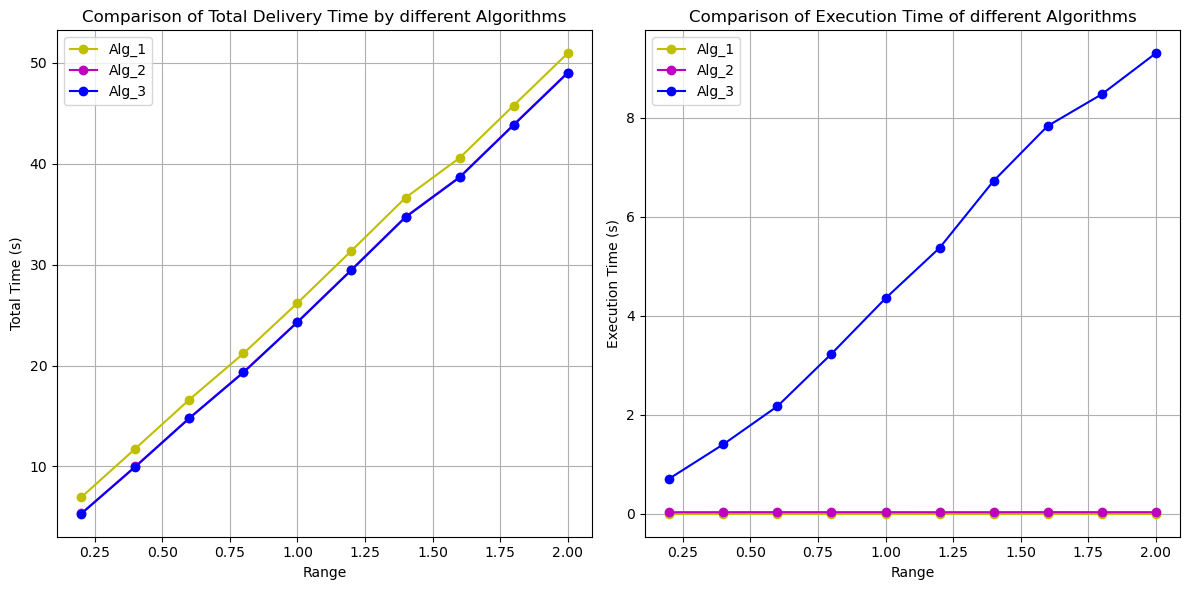

In [57]:
v = 1.6
x_max = 2
num_trials = 10
range_list = [i / 10.0 for i in range(2, 22, 2)]
num_algs = 3
avg_alg_time = [[] for _ in range(num_algs)]
avg_exec_time = [[] for _ in range (num_algs)]
num_points = 100

print(f"Velocity of Drone: {v}")
print(f"Number of points: {num_points}")
print(f"No. of Trials: {num_trials}")
print(f"Max. Truck Distance: {x_max}")

for R in range_list:
    alg_time = [[] for _ in range(num_algs)]
    exec_time = [[] for _ in range (num_algs)]
    m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
    
    for _ in range (num_trials):
        alg_time1 = [0 for _ in range(num_algs)]
        exec_time1 = [0 for _ in range (num_algs)]
        
        deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
        deliveries.sort(key = lambda x:x[0])

        start_time = time.time()
        alg_time1[0] = Alg_1(deliveries, v, x_max)
        end_time = time.time()
        exec_time1[0] = (end_time - start_time)

        start_time = time.time()
        _, alg_time1[1] = Alg_2(deliveries, R, v, x_max)
        end_time = time.time()
        exec_time1[1] = (end_time - start_time)

        start_time = time.time()
        _, alg_time1[2] = Alg_3(deliveries, R, v, x_max)
        end_time = time.time()
        exec_time1[2] = (end_time - start_time)
            
        for i in range(num_algs):    
            exec_time[i].append(exec_time1[i])
            alg_time[i].append(alg_time1[i])
    
    for i in range(num_algs):
        avg_alg_time[i].append(sum(alg_time[i])/len(alg_time[i]))
        avg_exec_time[i].append(calculate_mean_IQR(exec_time[i]))
        
    print(f"\nRange of Drone: {R}")
    print(f"Alg_1: {avg_alg_time[0][-1]:.2f}s, \texec_time: {avg_exec_time[0][-1]:.4f}s")
    print(f"Alg_2: {avg_alg_time[1][-1]:.2f}s, \texec_time: {avg_exec_time[1][-1]:.4f}s")
    print(f"Alg_3: {avg_alg_time[2][-1]:.2f}s, \texec_time: {avg_exec_time[2][-1]:.4f}s")
    
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range_list, avg_alg_time[0],'yo-', label='Alg_1')
plt.plot(range_list, avg_alg_time[1],'mo-', label='Alg_2')
plt.plot(range_list, avg_alg_time[2],'bo-', label='Alg_3')
plt.title("Comparison of Total Delivery Time by different Algorithms")
plt.xlabel("Range")
plt.ylabel("Total Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range_list, avg_exec_time[0], 'yo-', label='Alg_1')
plt.plot(range_list, avg_exec_time[1], 'mo-', label='Alg_2')
plt.plot(range_list, avg_exec_time[2], 'bo-', label='Alg_3')
plt.title("Comparison of Execution Time of different Algorithms")
plt.xlabel("Range")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()

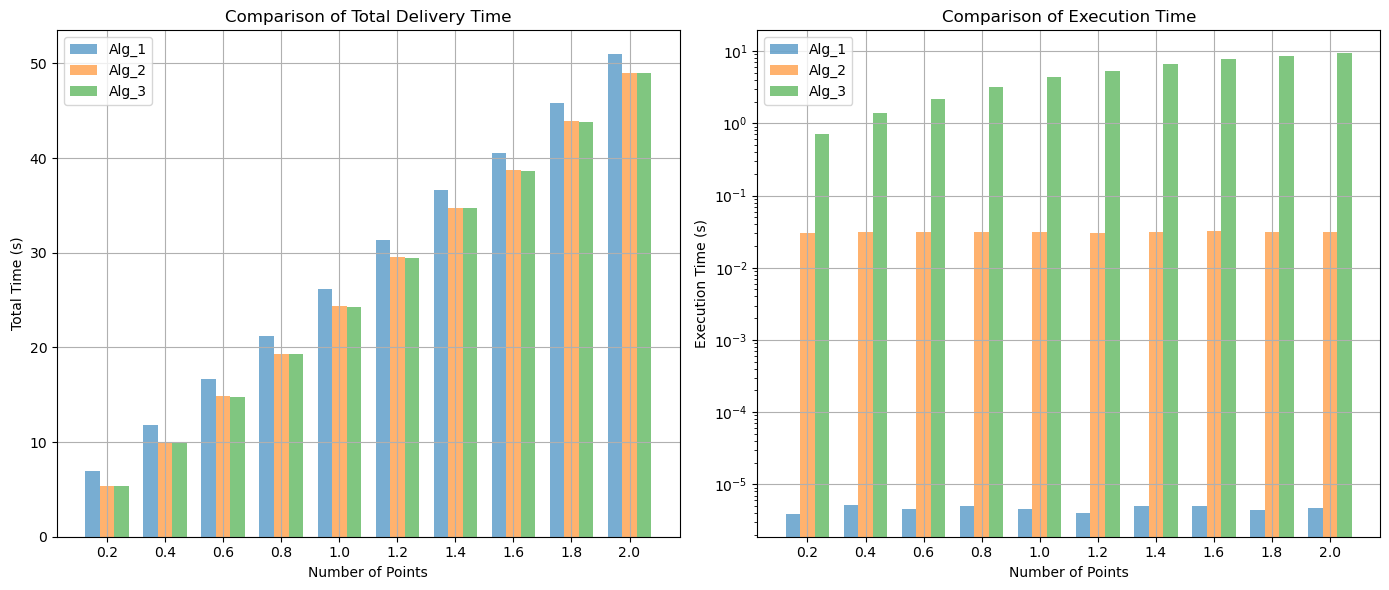

In [58]:
import numpy as np

x = np.arange(len(range_list))   # index positions
width = 0.25                      # bar width

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

# Bars
plt.bar(x - width, avg_alg_time[0], width, alpha=0.6, label='Alg_1')
plt.bar(x,         avg_alg_time[1], width, alpha=0.6, label='Alg_2')
plt.bar(x + width, avg_alg_time[2], width, alpha=0.6, label='Alg_3')

plt.title("Comparison of Total Delivery Time")
plt.xlabel("Number of Points")
plt.ylabel("Total Time (s)")
plt.xticks(x, range_list)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)

# Bars
plt.bar(x - width, avg_exec_time[0], width, alpha=0.6, label='Alg_1')
plt.bar(x,         avg_exec_time[1], width, alpha=0.6, label='Alg_2')
plt.bar(x + width, avg_exec_time[2], width, alpha=0.6, label='Alg_3')

plt.title("Comparison of Execution Time")
plt.xlabel("Number of Points")
plt.ylabel("Execution Time (s)")
plt.xticks(x, range_list)
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Comparison of all algorithms (including Alg_4) for different no. of points

Range of Drone: 0.6
Velocity of Drone: 1.6
No. of Trials: 10
Max. Truck Distance: 2

Total Number of points: 5
Alg_1: 2.69s, 	exec_time: 0.0000s
Alg_2: 2.05s, 	exec_time: 0.0020s
Alg_3: 2.02s, 	exec_time: 0.1172s
Alg_4: 2.02s, 	exec_time: 0.4197s

Total Number of points: 6
Alg_1: 2.79s, 	exec_time: 0.0000s
Alg_2: 2.10s, 	exec_time: 0.0022s
Alg_3: 2.06s, 	exec_time: 0.1261s
Alg_4: 2.06s, 	exec_time: 1.0054s

Total Number of points: 7
Alg_1: 2.99s, 	exec_time: 0.0000s
Alg_2: 2.19s, 	exec_time: 0.0027s
Alg_3: 2.10s, 	exec_time: 0.1669s
Alg_4: 2.09s, 	exec_time: 2.0095s

Total Number of points: 8
Alg_1: 3.05s, 	exec_time: 0.0000s
Alg_2: 2.20s, 	exec_time: 0.0030s
Alg_3: 2.15s, 	exec_time: 0.1730s
Alg_4: 2.15s, 	exec_time: 3.6753s

Total Number of points: 9
Alg_1: 3.34s, 	exec_time: 0.0000s
Alg_2: 2.28s, 	exec_time: 0.0041s
Alg_3: 2.22s, 	exec_time: 0.2111s
Alg_4: 2.21s, 	exec_time: 7.5924s

Total Number of points: 10
Alg_1: 3.35s, 	exec_time: 0.0000s
Alg_2: 2.29s, 	exec_time: 0.0046s
Alg_3

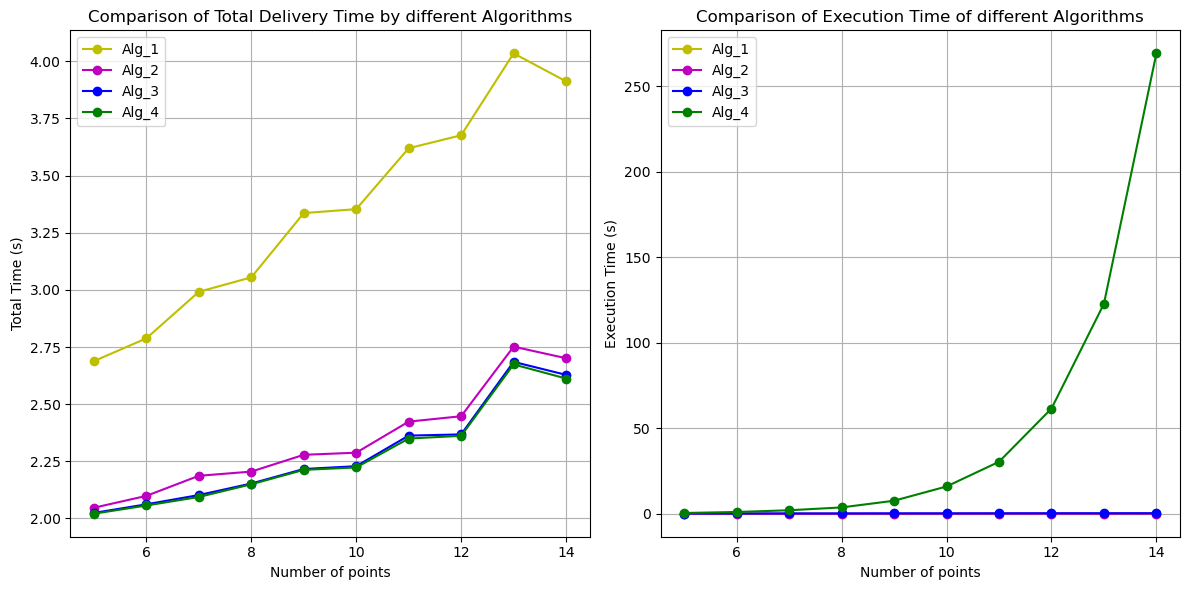

In [63]:
import time

R = 0.6  
v = 1.6
x_max = 2
num_trials = 10
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
points_list = [i for i in range(5, 15, 1)]
num_algs = 4
avg_alg_time = [[] for _ in range(num_algs)]
avg_exec_time = [[] for _ in range (num_algs)]

print(f"Range of Drone: {R}")
print(f"Velocity of Drone: {v}")
print(f"No. of Trials: {num_trials}")
print(f"Max. Truck Distance: {x_max}")

for num_points in points_list:
    alg_time = [[] for _ in range(num_algs)]
    exec_time = [[] for _ in range (num_algs)]

    for _ in range (num_trials):
        alg_time1 = [0 for _ in range(num_algs)]
        exec_time1 = [0 for _ in range (num_algs)]
        
        deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
        deliveries.sort(key = lambda x:x[0])

        start_time = time.time()
        alg_time1[0] = Alg_1(deliveries, v, x_max)
        end_time = time.time()
        exec_time1[0] = (end_time - start_time)

        start_time = time.time()
        _, alg_time1[1] = Alg_2(deliveries, R, v, x_max)
        end_time = time.time()
        exec_time1[1] = (end_time - start_time)

        start_time = time.time()
        _, alg_time1[2] = Alg_3(deliveries, R, v, x_max)
        end_time = time.time()
        exec_time1[2] = (end_time - start_time)

        start_time = time.time()
        _, alg_time1[3] = Alg_4(deliveries, R, v, x_max)
        end_time = time.time()
        exec_time1[3] = (end_time - start_time)
            
        for i in range(num_algs):
            exec_time[i].append(exec_time1[i])
            alg_time[i].append(alg_time1[i])
    
    for i in range(num_algs):
        avg_alg_time[i].append(sum(alg_time[i])/len(alg_time[i]))
        avg_exec_time[i].append(calculate_mean_IQR(exec_time[i]))
        
    print(f"\nTotal Number of points: {num_points}")
    print(f"Alg_1: {avg_alg_time[0][-1]:.2f}s, \texec_time: {avg_exec_time[0][-1]:.4f}s")
    print(f"Alg_2: {avg_alg_time[1][-1]:.2f}s, \texec_time: {avg_exec_time[1][-1]:.4f}s")
    print(f"Alg_3: {avg_alg_time[2][-1]:.2f}s, \texec_time: {avg_exec_time[2][-1]:.4f}s")
    print(f"Alg_4: {avg_alg_time[3][-1]:.2f}s, \texec_time: {avg_exec_time[3][-1]:.4f}s")
    

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(points_list, avg_alg_time[0],'yo-', label='Alg_1')
plt.plot(points_list, avg_alg_time[1],'mo-', label='Alg_2')
plt.plot(points_list, avg_alg_time[2],'bo-', label='Alg_3')
plt.plot(points_list, avg_alg_time[3],'go-', label='Alg_4')
plt.title("Comparison of Total Delivery Time by different Algorithms")
plt.xlabel("Number of points")
plt.ylabel("Total Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(points_list, avg_exec_time[0], 'yo-', label='Alg_1')
plt.plot(points_list, avg_exec_time[1], 'mo-', label='Alg_2')
plt.plot(points_list, avg_exec_time[2], 'bo-', label='Alg_3')
plt.plot(points_list, avg_exec_time[3], 'go-', label='Alg_4')
plt.title("Comparison of Execution Time of different Algorithms")
plt.xlabel("Number of points")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()

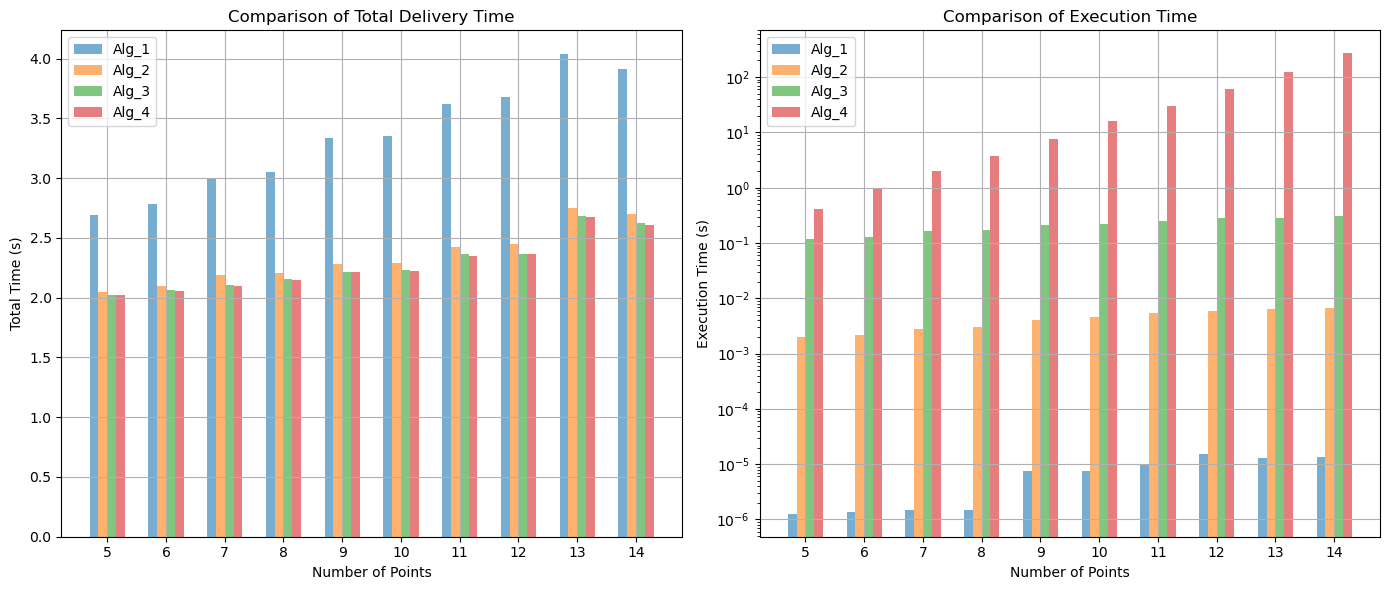

In [68]:
import numpy as np

x = np.arange(len(points_list))   # index positions
width = 0.15                      # bar width

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

plt.bar(x - 1.5*width, avg_alg_time[0], width, alpha=0.6, label='Alg_1')
plt.bar(x - 0.5*width, avg_alg_time[1], width, alpha=0.6, label='Alg_2')
plt.bar(x + 0.5*width, avg_alg_time[2], width, alpha=0.6, label='Alg_3')
plt.bar(x + 1.5*width, avg_alg_time[3], width, alpha=0.6, label='Alg_4')

plt.title("Comparison of Total Delivery Time")
plt.xlabel("Number of Points")
plt.ylabel("Total Time (s)")
plt.xticks(x, points_list)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)

# Bars
plt.bar(x - 1.5*width, avg_exec_time[0], width, alpha=0.6, label='Alg_1')
plt.bar(x - 0.5*width, avg_exec_time[1], width, alpha=0.6, label='Alg_2')
plt.bar(x + 0.5*width, avg_exec_time[2], width, alpha=0.6, label='Alg_3')
plt.bar(x + 1.5*width, avg_exec_time[3], width, alpha=0.6, label='Alg_4')

plt.title("Comparison of Execution Time")
plt.xlabel("Number of Points")
plt.ylabel("Execution Time (s)")
plt.xticks(x, points_list)
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<h2 style="text-align:center;">Appendix - Diagrams</h2>

### One drone and two drone schedule using greedy algorithm

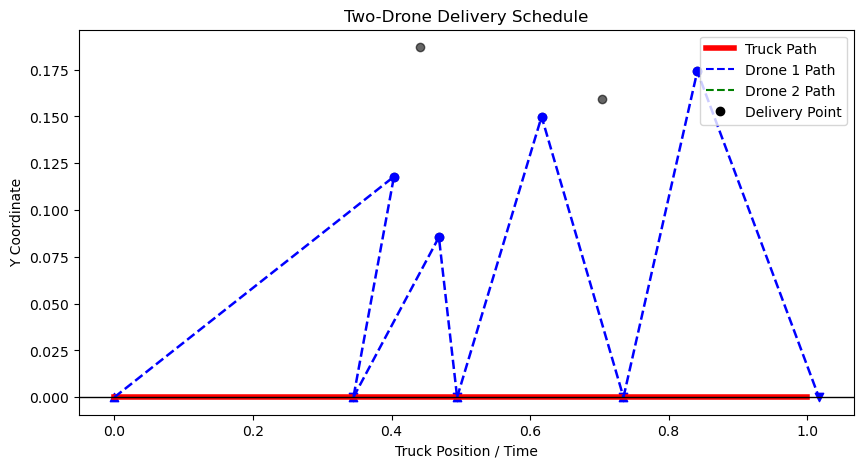

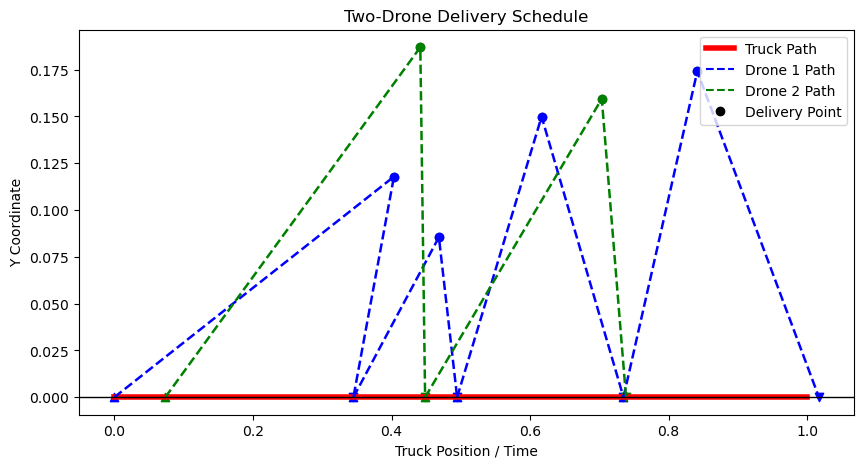

In [707]:
import matplotlib.pyplot as plt

def plot_two_drone_schedules(deliveries, schedule1, schedule2, title, x_max):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Delivery points
    all_x = [d[0] for d in deliveries]
    all_y = [d[1] for d in deliveries]
    ax.scatter(all_x, all_y, color="black", alpha=0.6, label="Delivery Points")

    # Truck path
    ax.plot([0, x_max], [0, 0], color="red", linewidth=4, label="Truck Path")

    # --- Drone 1 (Blue) ---
    for d, s, r in schedule1:
        x, y = d
        ax.plot([s, x, r], [0, y, 0], color="blue", linestyle="--", linewidth=1.8)
        ax.scatter(x, y, color="blue")
        ax.scatter(s, 0, color="blue", marker="^")
        ax.scatter(r, 0, color="blue", marker="v")

    # --- Drone 2 (Green) ---
    for d, s, r in schedule2:
        x, y = d
        ax.plot([s, x, r], [0, y, 0], color="green", linestyle="--", linewidth=1.8)
        ax.scatter(x, y, color="green")
        ax.scatter(s, 0, color="green", marker="^")
        ax.scatter(r, 0, color="green", marker="v")

    ax.axhline(0, color="black", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Truck Position / Time")
    ax.set_ylabel("Y Coordinate")

    ax.legend(
        handles=[
            plt.Line2D([], [], color="red", linewidth=4, label="Truck Path"),
            plt.Line2D([], [], color="blue", linestyle="--", label="Drone 1 Path"),
            plt.Line2D([], [], color="green", linestyle="--", label="Drone 2 Path"),
            plt.Line2D([], [], color="black", marker="o", linestyle="", label="Delivery Point")
        ],
        loc="upper right"
    )

    plt.show()

R = 0.6  
v = 1.6  
m = (R / (2 * v)) * math.sqrt(v**2 - 1) 
x_max = 1
num_points = 6
num_drones = 2

deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
deliveries.sort(key = lambda x:x[0])

SI_list, L_not_cons, L_not_schd = Sequential_Greedy(deliveries, R, v, num_drones, x_max)

schedule1 = []
for d, s in SI_list[0]:
    r = ret(s, v, d)
    schedule1.append((d, s, r))
    
schedule2 = []
for d, s in SI_list[1]:
    r = ret(s, v, d)
    schedule2.append((d, s, r))

plot_two_drone_schedules(deliveries, schedule1, [], "Two-Drone Delivery Schedule", x_max=1)
plot_two_drone_schedules(deliveries, schedule1, schedule2, "Two-Drone Delivery Schedule", x_max=1)

### Comparison of Naive and Greedy Algorithms

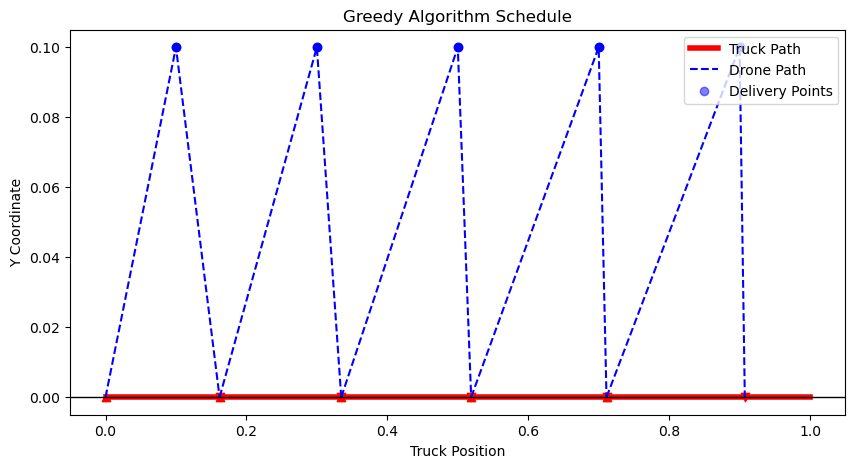

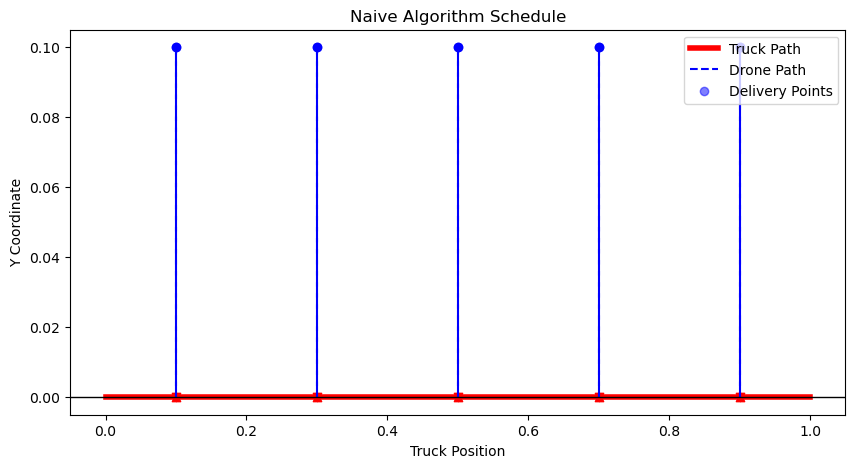

In [24]:
def plot_schedule(deliveries, schedule, title, x_max):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Delivery points
    all_x = [d[0] for d in deliveries]
    all_y = [d[1] for d in deliveries]
    delivery_scatter = ax.scatter(all_x, all_y, color="blue", alpha=0.5, label="Delivery Points")

    # Dummy lines for legend
    truck_line, = ax.plot([], [], color="red", linewidth=4, label="Truck Path")
    drone_line, = ax.plot([], [], color="blue", linestyle="--", linewidth=1.5, label="Drone Path")

    # Truck path along x-axis from 0 to x_max
    ax.plot([0, x_max], [0, 0], color="red", linewidth=4)

    # Drone paths
    for d, s, r in schedule:
        x, y = d
        ax.plot([s, x, r], [0, y, 0], color="blue", linestyle="--", linewidth=1.5)
        ax.scatter(x, y, color="blue")          # Delivery point
        ax.scatter(s, 0, color="red", marker="^")   # Launch
        ax.scatter(r, 0, color="red", marker="v")   # Return

    ax.axhline(0, color="black", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Truck Position")
    ax.set_ylabel("Y Coordinate")
    
    # Legend
    ax.legend(handles=[truck_line, drone_line, delivery_scatter], loc='upper right')
    plt.show()


R = 0.6
v = 1.6
m = (R / (2 * v)) * math.sqrt(v**2 - 1)
num_points = 4
x_max = 1

deliveries = [(0.1, 0.1), (0.3, 0.1), (0.5, 0.1), (0.7, 0.1), (0.9, 0.1)]
deliveries.sort(key=lambda x: x[0])

schedule = Greedy_Algorithm(deliveries, R, v)
schedule_greedy = []
for d, s in schedule:
    r = ret(s, v, d)
    schedule_greedy.append((d, s, r))
    
schedule_naive = []
for d in deliveries:
    schedule_naive.append((d, d[0], d[0]))

plot_schedule(deliveries, schedule_greedy, "Greedy Algorithm Schedule", x_max)
plot_schedule(deliveries, schedule_naive, "Naive Algorithm Schedule", x_max)

### Initial and Refined schedules for heuristic algorithm

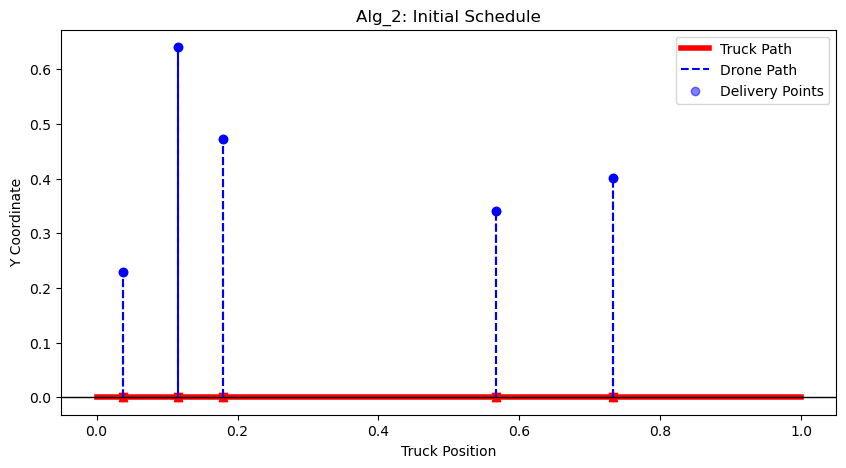

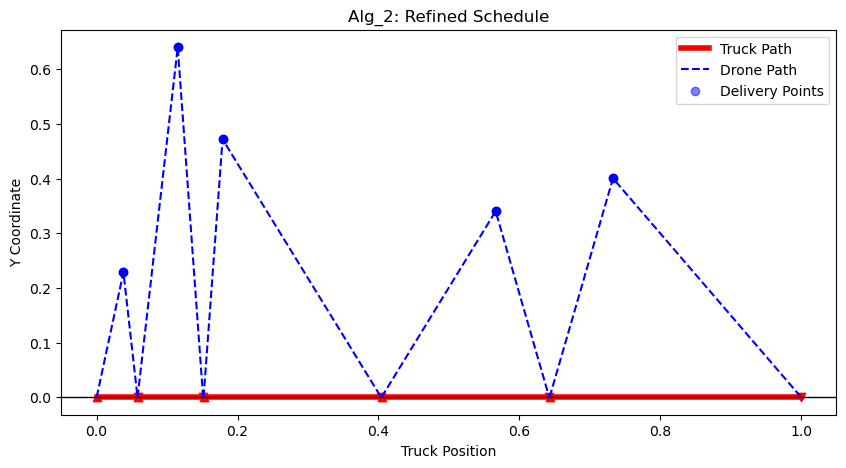

In [32]:
def calc_df(x, y):
    denom = math.sqrt(x*x + y*y)
    if denom < 1e-9:
        return math.inf
    return x / denom

def calc_Dist(d1, d2):
    x1, y1 = d1
    x2, y2 = d2
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def Alg_2_plot(deliveries, R, v, x_Max):
    num_points = len(deliveries)
    SI = []
    incr_val = 0.001

    boundary_reached = [False for _ in range(2 * num_points)]
    ret(clear_cache=True)

    deliveries.sort(key=lambda d: d[0])

    # Initialize boundaries
    for d in deliveries:
        SI.append([d, d[0], d[0]])

    plot_schedule(deliveries, SI, "Alg_2: Initial Schedule", x_Max)
    
    while not all(boundary_reached):
        min_df = math.inf
        min_i = None

        for i in range(num_points):
            d, s, r = SI[i]

            if not boundary_reached[2*i]:
                df = calc_df(d[0] - s, d[1])
                if df < min_df:
                    min_df = df
                    min_i = 2*i

            if not boundary_reached[2*i + 1]:
                df = calc_df(r - d[0], d[1])
                if df < min_df:
                    min_df = df
                    min_i = 2*i + 1

        if min_i is None:
            break

        i = min_i // 2
        d, s, r = SI[i]

        if r >= ret(s, v, d):
            boundary_reached[min_i] = True
            continue

        # Neighbor safety
        if i == 0:
            r_prev = 0
        else:
            r_prev = SI[i-1][2]

        if i == num_points - 1:
            s_nxt = x_Max
        else:
            s_nxt = SI[i+1][1]

        if min_i % 2 == 0:  # move s left
            t1 = (calc_Dist((s - incr_val, 0), d) + calc_Dist(d, (r, 0))) / v
            t2 = r - s + incr_val
            if s - incr_val < r_prev or t1 < t2: 
                boundary_reached[min_i] = True
            else:
                s -= incr_val
        else:  # move r right
            t1 = (calc_Dist((s, 0), d) + calc_Dist(d, (r + incr_val, 0))) / v
            t2 = r - s + incr_val
            if r + incr_val > s_nxt or t1 < t2:
                boundary_reached[min_i] = True
            else:
                r += incr_val

        SI[i][1] = s
        SI[i][2] = r
    
    
    plot_schedule(deliveries, SI, "Alg_2: Refined Schedule", x_Max)

    total_Time = 0
    r_prev = 0
    for i in range(num_points):
        d, s, r = SI[i]

        total_Time += (s - r_prev)

        t1 = (calc_Dist((s, 0), d) + calc_Dist(d, (r, 0))) / v
        t2 = r - s
        
        if t1 < t2:
            print(i, t1, t2)

        total_Time += t1

        r_prev = r
        
        
    if r_prev < x_Max:
        total_Time += x_Max - r_prev

    return SI, total_Time

R = 0.6
v = 1.6
x_max = 1.0
num_points = 5

deliveries = [(random.uniform(0, x_max), random.uniform(0, m)) for _ in range(num_points)]
deliveries.sort(key=lambda x: x[0])
SI, tot = Alg_2_plot(deliveries, R, v, x_max)


### Comparison of all algorithms for third scenario 

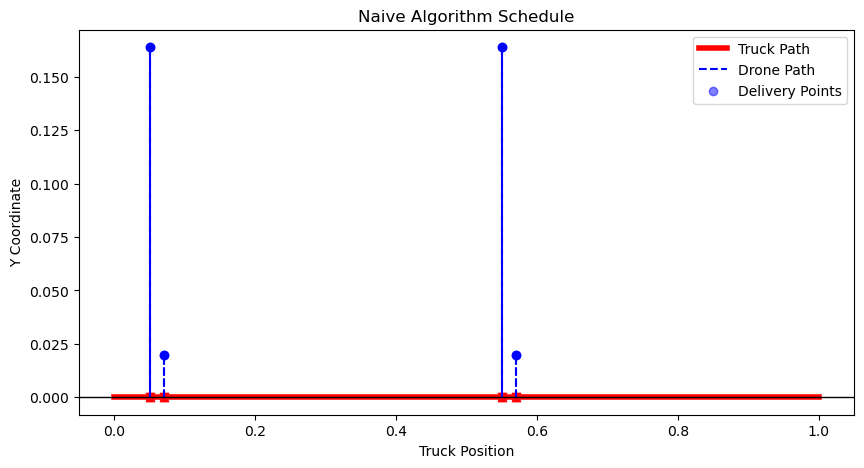

Total time taken using Alg_1: 1.46s


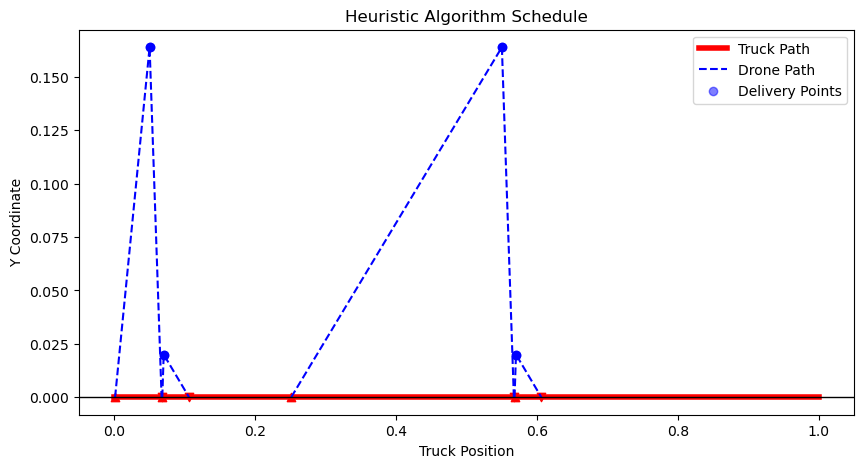

Total time taken using Alg_2: 1.14s


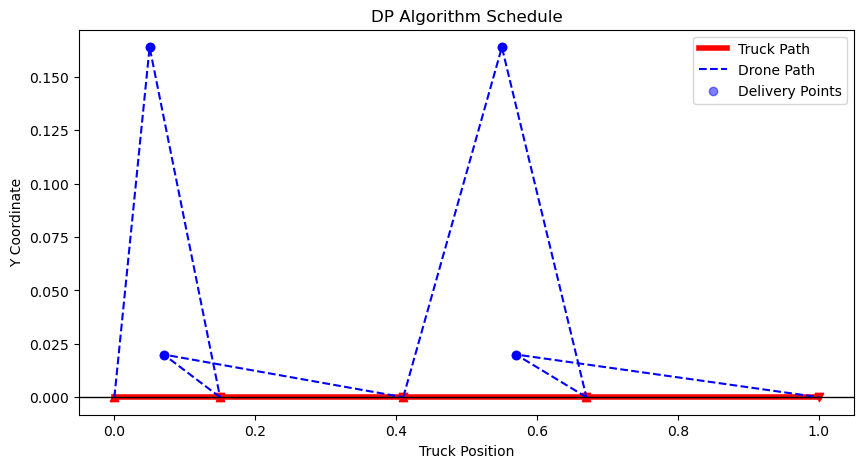

Total time taken using Alg_3: 1.09s


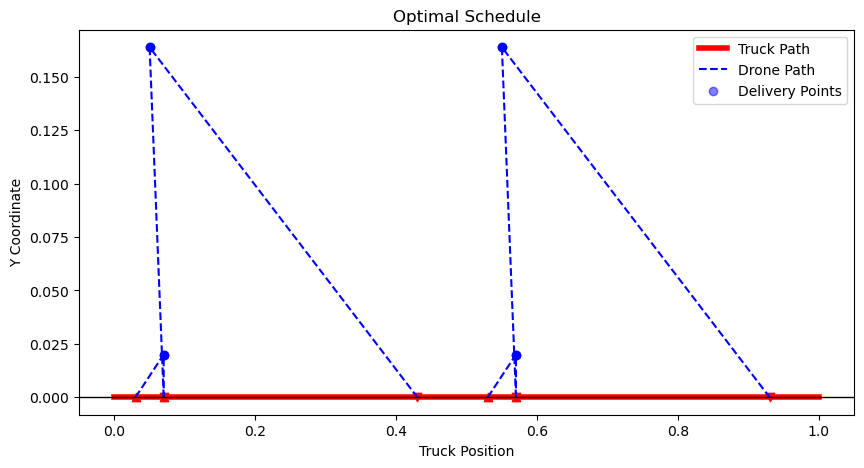

Total time taken using Alg_4: 1.00s


In [26]:
R = 0.6
v = 1.6
m = (R / (2 * v)) * math.sqrt(v**2 - 1)
num_points = 2
x_max = 1

deliveries = [(0.05, 0.7*m), (0.07, 0.02), (0.55, 0.7*m), (0.57, 0.02)]
deliveries.sort(key=lambda x: x[0])

tot_time_alg_1 = Alg_1(deliveries, v, x_max)
schedule_alg_1 = []
for i in range(len(deliveries)):
    schedule_alg_1.append((deliveries[i], deliveries[i][0], deliveries[i][0]))

schedule_alg_2, tot_time_alg_2 = Alg_2(deliveries, R, v, x_max)
schedule, tot_time_alg_3 = Alg_3(deliveries, R, v, x_max)

schedule_alg_3 = []
for i, item in enumerate(schedule, start = 0):
    s, r = item
    schedule_alg_3.append((deliveries[i], s, r))

schedule, tot_time_alg_4 = Alg_4(deliveries, R, v, x_max)
schedule_alg_4 = []
for i, item in enumerate(schedule, start = 0):
    j, s, r = item
    schedule_alg_4.append((deliveries[j], s, r))

plot_schedule(deliveries, schedule_alg_1, "Naive Algorithm Schedule", x_max)
print(f"Total time taken using Alg_1: {tot_time_alg_1:.2f}s")

plot_schedule(deliveries, schedule_alg_2, "Heuristic Algorithm Schedule", x_max)
print(f"Total time taken using Alg_2: {tot_time_alg_2:.2f}s")

plot_schedule(deliveries, schedule_alg_3, "DP Algorithm Schedule", x_max)
print(f"Total time taken using Alg_3: {tot_time_alg_3:.2f}s")

plot_schedule(deliveries, schedule_alg_4, "Optimal Schedule", x_max)
print(f"Total time taken using Alg_4: {tot_time_alg_4:.2f}s")

